## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


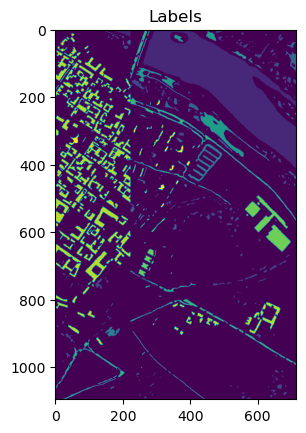

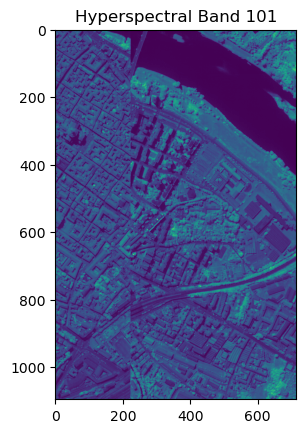

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 20 train


 -- Test set created with: 
	147927 samples
	shape (147927, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(180, 5, 5, 102)
(45, 5, 5, 102)
(147927, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1718, PSNR: 3.0823


	 Training Batch [200/1852], Loss: 0.0985, PSNR: 6.7820


	 Training Batch [400/1852], Loss: 0.0474, PSNR: 9.5977


	 Training Batch [600/1852], Loss: 0.0259, PSNR: 11.2568


	 Training Batch [800/1852], Loss: 0.0154, PSNR: 17.0728


	 Training Batch [1000/1852], Loss: 0.0121, PSNR: 16.7544


	 Training Batch [1200/1852], Loss: 0.0099, PSNR: 16.2820


	 Training Batch [1400/1852], Loss: 0.0073, PSNR: 18.3112


	 Training Batch [1600/1852], Loss: 0.0072, PSNR: 17.0095


	 Training Batch [1800/1852], Loss: 0.0050, PSNR: 19.9012


Epoch [1/50] Training Loss: 0.0331, PSNR: 13.6564
	[Val]   Batch [1/463] Loss: 0.0053, PSNR: 18.0108
	[Val]   Batch [10/463] Loss: 0.0049, PSNR: 19.2021
	[Val]   Batch [20/463] Loss: 0.0049, PSNR: 18.2069
	[Val]   Batch [30/463] Loss: 0.0060, PSNR: 18.7348
	[Val]   Batch [40/463] Loss: 0.0047, PSNR: 17.8844
	[Val]   Batch [50/463] Loss: 0.0050, PSNR: 18.0827
	[Val]   Batch [60/463] Loss: 0.0047, PSNR: 18.1384


	[Val]   Batch [70/463] Loss: 0.0067, PSNR: 18.4696
	[Val]   Batch [80/463] Loss: 0.0059, PSNR: 20.3996
	[Val]   Batch [90/463] Loss: 0.0057, PSNR: 19.4746
	[Val]   Batch [100/463] Loss: 0.0058, PSNR: 19.1962
	[Val]   Batch [110/463] Loss: 0.0067, PSNR: 18.6020
	[Val]   Batch [120/463] Loss: 0.0046, PSNR: 18.1290
	[Val]   Batch [130/463] Loss: 0.0054, PSNR: 19.4908
	[Val]   Batch [140/463] Loss: 0.0063, PSNR: 19.0362


	[Val]   Batch [150/463] Loss: 0.0072, PSNR: 19.0809
	[Val]   Batch [160/463] Loss: 0.0058, PSNR: 19.3350
	[Val]   Batch [170/463] Loss: 0.0074, PSNR: 18.2676
	[Val]   Batch [180/463] Loss: 0.0054, PSNR: 19.0744
	[Val]   Batch [190/463] Loss: 0.0058, PSNR: 19.4195
	[Val]   Batch [200/463] Loss: 0.0058, PSNR: 18.8166
	[Val]   Batch [210/463] Loss: 0.0057, PSNR: 18.3888
	[Val]   Batch [220/463] Loss: 0.0056, PSNR: 19.5681


	[Val]   Batch [230/463] Loss: 0.0066, PSNR: 19.4312
	[Val]   Batch [240/463] Loss: 0.0050, PSNR: 18.2600
	[Val]   Batch [250/463] Loss: 0.0065, PSNR: 17.4112
	[Val]   Batch [260/463] Loss: 0.0056, PSNR: 18.4260
	[Val]   Batch [270/463] Loss: 0.0043, PSNR: 17.6499
	[Val]   Batch [280/463] Loss: 0.0053, PSNR: 20.3046
	[Val]   Batch [290/463] Loss: 0.0058, PSNR: 17.3400


	[Val]   Batch [300/463] Loss: 0.0059, PSNR: 19.5806
	[Val]   Batch [310/463] Loss: 0.0054, PSNR: 19.4514
	[Val]   Batch [320/463] Loss: 0.0055, PSNR: 19.3390
	[Val]   Batch [330/463] Loss: 0.0064, PSNR: 18.7449
	[Val]   Batch [340/463] Loss: 0.0052, PSNR: 19.6964
	[Val]   Batch [350/463] Loss: 0.0069, PSNR: 19.5916
	[Val]   Batch [360/463] Loss: 0.0046, PSNR: 20.5412


	[Val]   Batch [370/463] Loss: 0.0068, PSNR: 18.6381
	[Val]   Batch [380/463] Loss: 0.0066, PSNR: 18.8129
	[Val]   Batch [390/463] Loss: 0.0061, PSNR: 18.6446
	[Val]   Batch [400/463] Loss: 0.0054, PSNR: 17.6892
	[Val]   Batch [410/463] Loss: 0.0052, PSNR: 20.0315
	[Val]   Batch [420/463] Loss: 0.0054, PSNR: 18.7906
	[Val]   Batch [430/463] Loss: 0.0053, PSNR: 18.2155


	[Val]   Batch [440/463] Loss: 0.0052, PSNR: 19.2053
	[Val]   Batch [450/463] Loss: 0.0041, PSNR: 16.5635
	[Val]   Batch [460/463] Loss: 0.0057, PSNR: 17.9505
Epoch [1/50] Validation Loss: 0.0056, PSNR: 18.7775

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0064, PSNR: 19.8474


	 Training Batch [200/1852], Loss: 0.0056, PSNR: 19.1111


	 Training Batch [400/1852], Loss: 0.0050, PSNR: 19.3906


	 Training Batch [600/1852], Loss: 0.0043, PSNR: 19.2755


	 Training Batch [800/1852], Loss: 0.0048, PSNR: 20.0850


	 Training Batch [1000/1852], Loss: 0.0035, PSNR: 19.1634


	 Training Batch [1200/1852], Loss: 0.0032, PSNR: 20.4025


	 Training Batch [1400/1852], Loss: 0.0042, PSNR: 20.4251


	 Training Batch [1600/1852], Loss: 0.0040, PSNR: 21.8246


	 Training Batch [1800/1852], Loss: 0.0027, PSNR: 20.6752


Epoch [2/50] Training Loss: 0.0043, PSNR: 20.1568
	[Val]   Batch [1/463] Loss: 0.0025, PSNR: 21.2899
	[Val]   Batch [10/463] Loss: 0.0023, PSNR: 22.5669
	[Val]   Batch [20/463] Loss: 0.0022, PSNR: 21.7121
	[Val]   Batch [30/463] Loss: 0.0028, PSNR: 21.9414
	[Val]   Batch [40/463] Loss: 0.0022, PSNR: 21.1351
	[Val]   Batch [50/463] Loss: 0.0023, PSNR: 21.3877
	[Val]   Batch [60/463] Loss: 0.0022, PSNR: 21.4192


	[Val]   Batch [70/463] Loss: 0.0032, PSNR: 21.6106
	[Val]   Batch [80/463] Loss: 0.0029, PSNR: 23.5582
	[Val]   Batch [90/463] Loss: 0.0027, PSNR: 22.7610
	[Val]   Batch [100/463] Loss: 0.0029, PSNR: 22.1465
	[Val]   Batch [110/463] Loss: 0.0033, PSNR: 21.7527
	[Val]   Batch [120/463] Loss: 0.0022, PSNR: 21.3787
	[Val]   Batch [130/463] Loss: 0.0025, PSNR: 22.8342
	[Val]   Batch [140/463] Loss: 0.0031, PSNR: 22.1795


	[Val]   Batch [150/463] Loss: 0.0033, PSNR: 22.4119
	[Val]   Batch [160/463] Loss: 0.0029, PSNR: 22.3001
	[Val]   Batch [170/463] Loss: 0.0037, PSNR: 21.2910
	[Val]   Batch [180/463] Loss: 0.0028, PSNR: 21.9864
	[Val]   Batch [190/463] Loss: 0.0027, PSNR: 22.7682
	[Val]   Batch [200/463] Loss: 0.0027, PSNR: 22.1060
	[Val]   Batch [210/463] Loss: 0.0029, PSNR: 21.2260


	[Val]   Batch [220/463] Loss: 0.0028, PSNR: 22.6038
	[Val]   Batch [230/463] Loss: 0.0030, PSNR: 22.8093
	[Val]   Batch [240/463] Loss: 0.0024, PSNR: 21.5113
	[Val]   Batch [250/463] Loss: 0.0032, PSNR: 20.4657
	[Val]   Batch [260/463] Loss: 0.0028, PSNR: 21.5184
	[Val]   Batch [270/463] Loss: 0.0019, PSNR: 21.1088
	[Val]   Batch [280/463] Loss: 0.0025, PSNR: 23.5154
	[Val]   Batch [290/463] Loss: 0.0028, PSNR: 20.5984


	[Val]   Batch [300/463] Loss: 0.0028, PSNR: 22.7302
	[Val]   Batch [310/463] Loss: 0.0028, PSNR: 22.4113
	[Val]   Batch [320/463] Loss: 0.0027, PSNR: 22.4637
	[Val]   Batch [330/463] Loss: 0.0029, PSNR: 22.1251
	[Val]   Batch [340/463] Loss: 0.0025, PSNR: 22.8784
	[Val]   Batch [350/463] Loss: 0.0035, PSNR: 22.4976
	[Val]   Batch [360/463] Loss: 0.0024, PSNR: 23.3641
	[Val]   Batch [370/463] Loss: 0.0032, PSNR: 21.8968


	[Val]   Batch [380/463] Loss: 0.0029, PSNR: 22.3377
	[Val]   Batch [390/463] Loss: 0.0028, PSNR: 22.0659
	[Val]   Batch [400/463] Loss: 0.0027, PSNR: 20.7413
	[Val]   Batch [410/463] Loss: 0.0024, PSNR: 23.3872
	[Val]   Batch [420/463] Loss: 0.0025, PSNR: 22.1747
	[Val]   Batch [430/463] Loss: 0.0027, PSNR: 21.2348


	[Val]   Batch [440/463] Loss: 0.0027, PSNR: 22.1463
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.7099
	[Val]   Batch [460/463] Loss: 0.0026, PSNR: 21.3038
Epoch [2/50] Validation Loss: 0.0027, PSNR: 22.0053

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0033, PSNR: 21.1722


	 Training Batch [200/1852], Loss: 0.0028, PSNR: 23.4245


	 Training Batch [400/1852], Loss: 0.0029, PSNR: 21.1299


	 Training Batch [600/1852], Loss: 0.0030, PSNR: 21.3667


	 Training Batch [800/1852], Loss: 0.0025, PSNR: 23.0575


	 Training Batch [1000/1852], Loss: 0.0018, PSNR: 23.0435


	 Training Batch [1200/1852], Loss: 0.0018, PSNR: 22.2922


	 Training Batch [1400/1852], Loss: 0.0025, PSNR: 22.9787


	 Training Batch [1600/1852], Loss: 0.0019, PSNR: 23.3542


	 Training Batch [1800/1852], Loss: 0.0017, PSNR: 22.6735


Epoch [3/50] Training Loss: 0.0023, PSNR: 22.7644
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.5534
	[Val]   Batch [10/463] Loss: 0.0013, PSNR: 24.8326
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 24.0374
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.4359
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.1225
	[Val]   Batch [50/463] Loss: 0.0014, PSNR: 23.4976


	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.4689
	[Val]   Batch [70/463] Loss: 0.0018, PSNR: 24.0904
	[Val]   Batch [80/463] Loss: 0.0016, PSNR: 26.0727
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 25.0716
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.5099
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.3093
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.4057


	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.3923
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.5643
	[Val]   Batch [150/463] Loss: 0.0017, PSNR: 25.2129
	[Val]   Batch [160/463] Loss: 0.0018, PSNR: 24.3501
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.5830
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.0931
	[Val]   Batch [190/463] Loss: 0.0015, PSNR: 25.2001


	[Val]   Batch [200/463] Loss: 0.0015, PSNR: 24.6353
	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.2574
	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.7545
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.7285
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.7632
	[Val]   Batch [250/463] Loss: 0.0019, PSNR: 22.6240
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6572
	[Val]   Batch [270/463] Loss: 0.0012, PSNR: 23.1603
	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.7649


	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 22.9184
	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.9241
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.3614
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.7186
	[Val]   Batch [330/463] Loss: 0.0016, PSNR: 24.7127
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.1032
	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.8387
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.9263


	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.4354
	[Val]   Batch [380/463] Loss: 0.0015, PSNR: 25.1577
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.7312
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.7405
	[Val]   Batch [410/463] Loss: 0.0014, PSNR: 25.7019
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.5015
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.2178
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.2792


	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.5172
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.5606
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.3160

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0016, PSNR: 22.2833


	 Training Batch [200/1852], Loss: 0.0017, PSNR: 25.4638


	 Training Batch [400/1852], Loss: 0.0025, PSNR: 23.7180


	 Training Batch [600/1852], Loss: 0.0020, PSNR: 22.4368


	 Training Batch [800/1852], Loss: 0.0019, PSNR: 23.3411


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 24.7590


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 24.2784


	 Training Batch [1400/1852], Loss: 0.0017, PSNR: 25.9725


	 Training Batch [1600/1852], Loss: 0.0013, PSNR: 24.6181


	 Training Batch [1800/1852], Loss: 0.0014, PSNR: 24.2668


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.3196
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.8370
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.1351
	[Val]   Batch [20/463] Loss: 0.0009, PSNR: 25.3735
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.8095
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.3476
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.7692
	[Val]   Batch [60/463] Loss: 0.0010, PSNR: 24.6928


	[Val]   Batch [70/463] Loss: 0.0013, PSNR: 25.4704
	[Val]   Batch [80/463] Loss: 0.0011, PSNR: 27.6351
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.4316
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 25.8940
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.7897
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.6826
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.8335
	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.9535


	[Val]   Batch [150/463] Loss: 0.0012, PSNR: 26.7101
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.5342
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 24.8162
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.3278
	[Val]   Batch [190/463] Loss: 0.0011, PSNR: 26.5324
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.1308
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4633
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.9832


	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.3682
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.1304
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.8521
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.8555
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.4888
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.1155
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.2914
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.1883


	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.5698
	[Val]   Batch [320/463] Loss: 0.0011, PSNR: 26.1216
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.1821
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.4335
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.1563
	[Val]   Batch [360/463] Loss: 0.0013, PSNR: 25.8862
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.8902
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.7514


	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.2319
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.9172
	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.0888
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.8149
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.3160
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.5972
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.7100
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.8395


Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.6617

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 26.4614


	 Training Batch [200/1852], Loss: 0.0015, PSNR: 24.9187


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 25.3826


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 24.1286


	 Training Batch [800/1852], Loss: 0.0013, PSNR: 23.9768


	 Training Batch [1000/1852], Loss: 0.0011, PSNR: 24.9984


	 Training Batch [1200/1852], Loss: 0.0014, PSNR: 25.6194


	 Training Batch [1400/1852], Loss: 0.0012, PSNR: 25.5785


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 25.4463


	 Training Batch [1800/1852], Loss: 0.0016, PSNR: 28.0463


Epoch [5/50] Training Loss: 0.0013, PSNR: 25.3835
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.8430
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.2182
	[Val]   Batch [20/463] Loss: 0.0007, PSNR: 26.4663
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.8139
	[Val]   Batch [40/463] Loss: 0.0008, PSNR: 25.3129
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 25.8639
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.6676


	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.4660
	[Val]   Batch [80/463] Loss: 0.0008, PSNR: 28.8276
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.4858
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.9710
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.8957
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.7248
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.8545


	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 27.0039
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.8310
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.5093
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.7396
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3400
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.5671
	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.2913
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.4574


	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 26.9520
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.4790
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.2171
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.8609
	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 25.7989
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.6933
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.2001
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.3513


	[Val]   Batch [300/463] Loss: 0.0010, PSNR: 27.1026
	[Val]   Batch [310/463] Loss: 0.0010, PSNR: 26.6427
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.2648
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.2559
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.4755
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.1044
	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.6534


	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.9574
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.8902
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.3035
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8885
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.1650
	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.8051
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.2611
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.5462


	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.7387
	[Val]   Batch [460/463] Loss: 0.0009, PSNR: 25.8555
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.7164

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 25.5642


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 25.7229


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 26.2099


	 Training Batch [600/1852], Loss: 0.0012, PSNR: 26.2529


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.3980


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 26.0041


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 27.8521


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 26.6191


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 26.4062


	 Training Batch [1800/1852], Loss: 0.0013, PSNR: 25.7416


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.2205
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.6565
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0649
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.3307
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.6388
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.0547
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.7201
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4324


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.3156
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.8733
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.3786
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.8737
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.8144
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.5059
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.7140
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 27.8694


	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.7898
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.2479
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.5396
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.1676
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.3619
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.2248
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.2706
	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.6727
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.4869


	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 27.0916
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.6597
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.5294
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.5577
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.0301
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.2172
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.8318
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.4022


	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.2093
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.1511
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.3758
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.9031
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.1828
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.8640
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.9017


	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.2399
	[Val]   Batch [400/463] Loss: 0.0009, PSNR: 25.6394
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 29.0360
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.6639
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 25.9652
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.3340
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.5252
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.6843
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.5720

LOG: Epoch [7/50]


	 Training Batch [1/1852], Loss: 0.0011, PSNR: 25.9638


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 26.2762


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.9811


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 27.0688


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 27.7582


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.2587


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 25.1246


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.2486


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 25.3209


	 Training Batch [1800/1852], Loss: 0.0010, PSNR: 26.3688


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.9105
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.3088
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.8554
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.0785
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 28.3383
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.7937
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.4795
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.1247


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.0024
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.6883
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.1140
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.6238
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.5528
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.3315
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 29.3821


	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.6038
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.5293
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.9921
	[Val]   Batch [170/463] Loss: 0.0010, PSNR: 27.2034
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.0114
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.0345


	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.9834
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.0120
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.4752
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 30.2188
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.8009
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.3300
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.2450


	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.4408
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.7982
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 26.9470
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.4908
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.1837
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 28.9948


	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.8954
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.1568
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.6410
	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.7465
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.5844
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.6448
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 29.0226


	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.3515
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.7219
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.4246
	[Val]   Batch [430/463] Loss: 0.0008, PSNR: 26.7251
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.0825
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.3765
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.3633
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.3236

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.3073


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.1222


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.6490


	 Training Batch [600/1852], Loss: 0.0011, PSNR: 26.0758


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.6470


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 26.6506


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 26.2381


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 25.7633


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 26.4903


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.9170


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.4516
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.7952
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.3023
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.4754
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.9174
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.2308
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 27.8887
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.5241


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.5893
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.2222
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.6419
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 29.1989
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.1969
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.7963
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.9487


	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.1776
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 30.0850
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.3772
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 27.7778
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.5600
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.5008
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.4351
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.5521


	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 28.9863
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.8063
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.3071
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 26.8603
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.7392
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.8932
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.3227


	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.5295
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.8552
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.6479
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.5969
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.4119
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.6757
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.2415


	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.0639
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.2142
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 30.1886
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.6320
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.8317
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.1097


	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 28.8814
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 27.2291
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.6125
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.8303
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.8246
Epoch [8/50] Validation Loss: 0.0006, PSNR: 28.8371

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 27.9126


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 27.8991


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 26.6761


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 28.1672


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 27.7632


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 27.0912


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 26.6082


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.4952


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.2234


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 29.9454


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.9519
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.5127
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.1785
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.4138
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.6340
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 28.0248
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.7948


	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 28.2689
	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 29.2946
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.1837
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.3856
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.9240
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.9226
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.6241


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.7088
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.9070
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.9621
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.1710
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.4143
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.3821
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.2546
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.3218


	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.3210
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.6852
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.5855
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.1840
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.5821
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.4587
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.8796
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.1383


	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.2754
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.5610
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.4550
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.4050
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 30.2356
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.4894
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 29.8964
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6432
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.9264


	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.1018
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.4136
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.5092
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.8862
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.7474
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 28.0164
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.2544


	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.6829
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.5947
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.6363

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 26.4149


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 28.6498


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.2173


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.2602


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 27.4554


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 27.6288


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.7624


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.9493


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.1308


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.1350


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.3762
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.7964
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.4880
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.7620
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.9464
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.3636
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.2498
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.6161


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.5729
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.4552
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.6612
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.2156
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.1964
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.9499
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.9598


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.1952
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.2468
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.5660
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.7469
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.7180
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.5471
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.6955
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.7300


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.9843
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.7951
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.5413
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.9862
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.8641
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.2654
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.4750


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.6286
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 29.8910
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.8303
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.7942
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.5042
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.7968
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.1783


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.8705
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.2331
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.4109
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.6426
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.8159
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.2400


	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.0562
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.3945
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.5527
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.0801
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 28.9799
Epoch [10/50] Validation Loss: 0.0004, PSNR: 29.9635

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.2516


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 27.7637


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 29.0709


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.8797


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.3046


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 27.2876


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.5067


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.0050


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 27.9782


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 30.3188


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.7307
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.3479
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.0978
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.2545
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.5912
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.7542
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.7835


	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.0387
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.3237
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.2336
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.3960
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.8823
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.9444
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.3452
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.5893


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.8475
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 32.0842
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.0741
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.4119
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.2801
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.1138
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.2619
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.3429


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.4647
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.5349
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.0984
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.6127
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.4514
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.6413


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.9646
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.3159
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.3594
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.2563
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.4044
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.1964
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.3689


	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.8783
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.1400
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.9057
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.2228
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.3623
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.3053
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.6831


	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.6316
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.8635
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.0021
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.4330
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.5502
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.5606

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.4780


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 29.4209


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.3161


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.3641


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.9760


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.9546


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 30.2422


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 26.9746


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.8103


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.9866


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.0338
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.6685
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.4683
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.6305
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.9635
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.1141
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.2330
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.4486


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.7037
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.5202
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.7234
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.2224
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.3106
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.6603
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.9328
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.1588


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.5357
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.4963
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.7540
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.6676
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.4361
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.6638


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.7797
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7243
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.8929
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.4991
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.0096
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.8809
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.0438


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.3024
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.6688
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.6872
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.6425
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.7629
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.5668
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.7460
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.1749


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3765
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.2650
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.6345
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.6918
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.6463
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.0187
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0200


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.2307
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.2840
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.7813
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.9698
Epoch [12/50] Validation Loss: 0.0003, PSNR: 30.9243

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 27.6452


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 30.5992


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.8693


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.8059


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.6519


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.2127


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.1592


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 30.3357


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 27.6751


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 28.7756


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.3221
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.0534
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.8837
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 31.0117
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.3544
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.4623
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.6041
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.8626


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.1867
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 34.0114
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.1369
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.6781
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.7799
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0277
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.3379
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.6231


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.0600
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.9332
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.1744
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.0888
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.8386
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.1039
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.2705
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.1192


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.2557
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.9494
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.3877
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.3119
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.5017
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.6719
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.0930
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.0570


	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.1189
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.1559
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.9745
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.1980
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.6904
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6116
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.6296


	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.9861
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.1139
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.0209
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.3357
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.4131
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6757
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.7398


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.2284
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.3745
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.3489

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.8672


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 27.6878


	 Training Batch [400/1852], Loss: 0.0003, PSNR: 31.6279


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.4509


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 28.0486


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 30.9755


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.8737


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.1171


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.4219


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.5396


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.5720
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.3422
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.1442
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.3000
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.6908
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.7657
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.9468


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.2267
	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.5624
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.3288
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.4403
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.9760
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.0959
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.2826


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.6253
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.9439
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.3936
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.3323
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5183
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.3900
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.0715
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.3633


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.6323
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.4040
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.6414
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.2678
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.7451
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.7573
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.7786


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.9997
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.4285
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3501
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.3869
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.4685
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.2918
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.4740


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.0160
	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8145
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.0302
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.4130
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.4001
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.3151
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.5792


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6891
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9428
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 30.9978
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.4932
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.7121
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.6615

LOG: Epoch [15/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 29.6440


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.7628


	 Training Batch [400/1852], Loss: 0.0003, PSNR: 31.4399


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 30.2047


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 29.8308


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 30.8270


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 30.0692


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 30.7604


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.3052


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 30.4497


Epoch [15/50] Training Loss: 0.0005, PSNR: 29.7934
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.3320
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.2087
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.3497
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.6086
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.8494
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 31.0204
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3983


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.5068
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.2074
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.4218
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.9292
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.0586
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.3170
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.6247
	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.9054


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.4022
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.4665
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5609
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.3904
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.0708
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.2761
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.6728


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.3106
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.5443
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.2833
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.8313
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.8738
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.8015
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.9562


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.4380
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.4883
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.4006
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.4779
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.2593
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.4502
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.9451


	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8699
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.9965
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.3960
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.3158
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.3806
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.5924
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6896


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9929
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.9488
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.5300
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.7892
Epoch [15/50] Validation Loss: 0.0003, PSNR: 31.6609
Early stopping triggered at epoch 15. No improvement for 3 epochs.


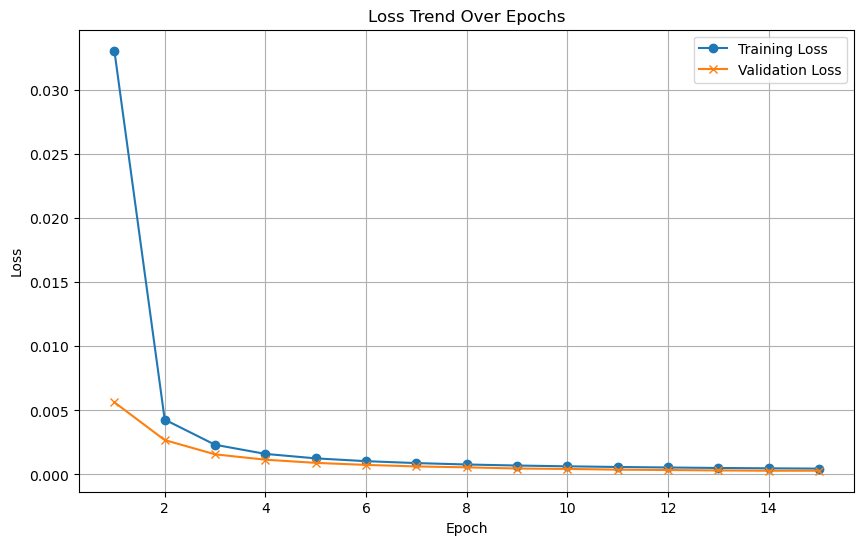

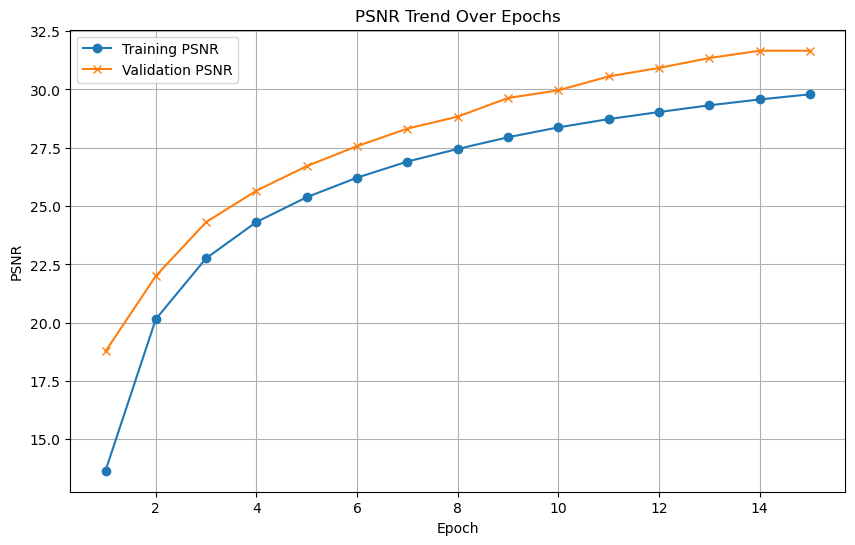

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2203
    Validation Batch [1/1], Loss: 2.2026
Validation Loss: 2.2026, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2026. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1556
    Validation Batch [1/1], Loss: 2.2026
Validation Loss: 2.2026, Validation Accuracy: 11.11%
Validation loss improved from 2.2026 to 2.2026. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1214
    Validation Batch [1/1], Loss: 2.2026
Validation Loss: 2.2026, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0771
    Validation Batch [1/1], Loss: 2.2026
Validation Loss: 2.2026, Validation Accuracy: 11.11%
Validation loss improved from 2.2026 to 2.2026. Saving model...

LOG: Epoch [5/1000] - Training
Ep

    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss improved from 2.2025 to 2.2024. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 1.9906
    Validation Batch [1/1], Loss: 2.2023
Validation Loss: 2.2023, Validation Accuracy: 11.11%
Validation loss improved from 2.2024 to 2.2023. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 1.9718
    Validation Batch [1/1], Loss: 2.2021
Validation Loss: 2.2021, Validation Accuracy: 11.11%
Validation loss improved from 2.2023 to 2.2021. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 1.9644
    Validation Batch [1/1], Loss: 2.2018
Validation Loss: 2.2018, Validation Accuracy: 11.11%
Validation loss improved from 2.2021 to 2.2018. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 1.9432
    Valida

    Validation Batch [1/1], Loss: 2.0291
Validation Loss: 2.0291, Validation Accuracy: 37.78%
Validation loss improved from 2.0493 to 2.0291. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.6103
    Validation Batch [1/1], Loss: 2.0070
Validation Loss: 2.0070, Validation Accuracy: 44.44%
Validation loss improved from 2.0291 to 2.0070. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.5974
    Validation Batch [1/1], Loss: 1.9833
Validation Loss: 1.9833, Validation Accuracy: 46.67%
Validation loss improved from 2.0070 to 1.9833. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.5896
    Validation Batch [1/1], Loss: 1.9578
Validation Loss: 1.9578, Validation Accuracy: 51.11%
Validation loss improved from 1.9833 to 1.9578. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.5845
    Vali

Epoch [66/1000] completed, Average Training Loss: 1.3546
    Validation Batch [1/1], Loss: 1.4112
Validation Loss: 1.4112, Validation Accuracy: 86.67%
Validation loss improved from 1.4220 to 1.4112. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.3510
    Validation Batch [1/1], Loss: 1.3933
Validation Loss: 1.3933, Validation Accuracy: 84.44%
Validation loss improved from 1.4112 to 1.3933. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.3423
    Validation Batch [1/1], Loss: 1.3783
Validation Loss: 1.3783, Validation Accuracy: 82.22%
Validation loss improved from 1.3933 to 1.3783. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.3069
    Validation Batch [1/1], Loss: 1.3694
Validation Loss: 1.3694, Validation Accuracy: 82.22%
Validation loss improved from 1.3783 to 1.3694. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [7

Epoch [95/1000] completed, Average Training Loss: 1.1271
    Validation Batch [1/1], Loss: 1.1475
Validation Loss: 1.1475, Validation Accuracy: 84.44%
Validation loss improved from 1.1500 to 1.1475. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.1047
    Validation Batch [1/1], Loss: 1.1319
Validation Loss: 1.1319, Validation Accuracy: 84.44%
Validation loss improved from 1.1475 to 1.1319. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.1312
    Validation Batch [1/1], Loss: 1.1210
Validation Loss: 1.1210, Validation Accuracy: 84.44%
Validation loss improved from 1.1319 to 1.1210. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.0944
    Validation Batch [1/1], Loss: 1.1093
Validation Loss: 1.1093, Validation Accuracy: 84.44%
Validation loss improved from 1.1210 to 1.1093. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [9

Epoch [124/1000] completed, Average Training Loss: 0.8792
    Validation Batch [1/1], Loss: 0.9382
Validation Loss: 0.9382, Validation Accuracy: 88.89%
Validation loss improved from 0.9422 to 0.9382. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.9215
    Validation Batch [1/1], Loss: 0.9325
Validation Loss: 0.9325, Validation Accuracy: 88.89%
Validation loss improved from 0.9382 to 0.9325. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.8952
    Validation Batch [1/1], Loss: 0.9238
Validation Loss: 0.9238, Validation Accuracy: 88.89%
Validation loss improved from 0.9325 to 0.9238. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.8761
    Validation Batch [1/1], Loss: 0.9153
Validation Loss: 0.9153, Validation Accuracy: 91.11%
Validation loss improved from 0.9238 to 0.9153. Saving model...

LOG: Epoch [128/1000] - Training


Epoch [152/1000] completed, Average Training Loss: 0.7318
    Validation Batch [1/1], Loss: 0.7715
Validation Loss: 0.7715, Validation Accuracy: 91.11%
Validation loss improved from 0.7845 to 0.7715. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.6966
    Validation Batch [1/1], Loss: 0.7630
Validation Loss: 0.7630, Validation Accuracy: 88.89%
Validation loss improved from 0.7715 to 0.7630. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.6813
    Validation Batch [1/1], Loss: 0.7582
Validation Loss: 0.7582, Validation Accuracy: 88.89%
Validation loss improved from 0.7630 to 0.7582. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.7006
    Validation Batch [1/1], Loss: 0.7508
Validation Loss: 0.7508, Validation Accuracy: 88.89%
Validation loss improved from 0.7582 to 0.7508. Saving model...

LOG: Epoch [156/1000] - Training


    Validation Batch [1/1], Loss: 0.6269
Validation Loss: 0.6269, Validation Accuracy: 91.11%
Validation loss improved from 0.6290 to 0.6269. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 0.5488
    Validation Batch [1/1], Loss: 0.6251
Validation Loss: 0.6251, Validation Accuracy: 88.89%
Validation loss improved from 0.6269 to 0.6251. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.5218
    Validation Batch [1/1], Loss: 0.6256
Validation Loss: 0.6256, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.5294
    Validation Batch [1/1], Loss: 0.6087
Validation Loss: 0.6087, Validation Accuracy: 88.89%
Validation loss improved from 0.6251 to 0.6087. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.4740
    Validation 

Epoch [210/1000] completed, Average Training Loss: 0.4154
    Validation Batch [1/1], Loss: 0.5314
Validation Loss: 0.5314, Validation Accuracy: 88.89%
Validation loss improved from 0.5349 to 0.5314. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.3864
    Validation Batch [1/1], Loss: 0.5275
Validation Loss: 0.5275, Validation Accuracy: 91.11%
Validation loss improved from 0.5314 to 0.5275. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.3865
    Validation Batch [1/1], Loss: 0.5190
Validation Loss: 0.5190, Validation Accuracy: 88.89%
Validation loss improved from 0.5275 to 0.5190. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.3801
    Validation Batch [1/1], Loss: 0.5172
Validation Loss: 0.5172, Validation Accuracy: 88.89%
Validation loss improved from 0.5190 to 0.5172. Saving model...

LOG: Epoch [214/1000] - Training


    Validation Batch [1/1], Loss: 0.4492
Validation Loss: 0.4492, Validation Accuracy: 88.89%
Validation loss improved from 0.4515 to 0.4492. Saving model...

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.3163
    Validation Batch [1/1], Loss: 0.4538
Validation Loss: 0.4538, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.2975
    Validation Batch [1/1], Loss: 0.4535
Validation Loss: 0.4535, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.2920
    Validation Batch [1/1], Loss: 0.4565
Validation Loss: 0.4565, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.3263
    Validation Batch [1/1], Loss: 0.4511
Vali

Epoch [268/1000] completed, Average Training Loss: 0.2119
    Validation Batch [1/1], Loss: 0.4175
Validation Loss: 0.4175, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.2361
    Validation Batch [1/1], Loss: 0.4148
Validation Loss: 0.4148, Validation Accuracy: 88.89%
Validation loss improved from 0.4165 to 0.4148. Saving model...

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.2123
    Validation Batch [1/1], Loss: 0.4123
Validation Loss: 0.4123, Validation Accuracy: 88.89%
Validation loss improved from 0.4148 to 0.4123. Saving model...

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.2135
    Validation Batch [1/1], Loss: 0.4128
Validation Loss: 0.4128, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Av

Epoch [297/1000] completed, Average Training Loss: 0.1654
    Validation Batch [1/1], Loss: 0.4008
Validation Loss: 0.4008, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.1855
    Validation Batch [1/1], Loss: 0.3873
Validation Loss: 0.3873, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.1725
    Validation Batch [1/1], Loss: 0.3848
Validation Loss: 0.3848, Validation Accuracy: 91.11%
Validation loss improved from 0.3856 to 0.3848. Saving model...

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.1655
    Validation Batch [1/1], Loss: 0.3838
Validation Loss: 0.3838, Validation Accuracy: 91.11%
Validation loss improved from 0.3848 to 0.3838. Saving model...

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Av

Epoch [323/1000] completed, Average Training Loss: 0.1531
    Validation Batch [1/1], Loss: 0.3632
Validation Loss: 0.3632, Validation Accuracy: 88.89%
Validation loss improved from 0.3689 to 0.3632. Saving model...

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.1382
    Validation Batch [1/1], Loss: 0.3590
Validation Loss: 0.3590, Validation Accuracy: 88.89%
Validation loss improved from 0.3632 to 0.3590. Saving model...

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.1558
    Validation Batch [1/1], Loss: 0.3603
Validation Loss: 0.3603, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.1287
    Validation Batch [1/1], Loss: 0.3604
Validation Loss: 0.3604, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Av

Epoch [352/1000] completed, Average Training Loss: 0.1032
    Validation Batch [1/1], Loss: 0.3552
Validation Loss: 0.3552, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.1079
    Validation Batch [1/1], Loss: 0.3606
Validation Loss: 0.3606, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.1000
    Validation Batch [1/1], Loss: 0.3637
Validation Loss: 0.3637, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.1135
    Validation Batch [1/1], Loss: 0.3623
Validation Loss: 0.3623, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.1186
  

    Validation Batch [1/1], Loss: 0.3670
Validation Loss: 0.3670, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.0922
    Validation Batch [1/1], Loss: 0.3752
Validation Loss: 0.3752, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.1119
    Validation Batch [1/1], Loss: 0.3621
Validation Loss: 0.3621, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.1014
    Validation Batch [1/1], Loss: 0.3546
Validation Loss: 0.3546, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.1007
    Validation Batch [1/1], Loss: 0.3569
Validation Loss: 0.

Epoch [412/1000] completed, Average Training Loss: 0.0796
    Validation Batch [1/1], Loss: 0.3458
Validation Loss: 0.3458, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.0794
    Validation Batch [1/1], Loss: 0.3451
Validation Loss: 0.3451, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0756
    Validation Batch [1/1], Loss: 0.3488
Validation Loss: 0.3488, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.0840
    Validation Batch [1/1], Loss: 0.3546
Validation Loss: 0.3546, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.078

Epoch [442/1000] completed, Average Training Loss: 0.0645
    Validation Batch [1/1], Loss: 0.3368
Validation Loss: 0.3368, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.0671
    Validation Batch [1/1], Loss: 0.3415
Validation Loss: 0.3415, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.0608
    Validation Batch [1/1], Loss: 0.3506
Validation Loss: 0.3506, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0598
    Validation Batch [1/1], Loss: 0.3642
Validation Loss: 0.3642, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.0628
  

Epoch [470/1000] completed, Average Training Loss: 0.0529
    Validation Batch [1/1], Loss: 0.3517
Validation Loss: 0.3517, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0580
    Validation Batch [1/1], Loss: 0.3412
Validation Loss: 0.3412, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0521
    Validation Batch [1/1], Loss: 0.3399
Validation Loss: 0.3399, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.0572
    Validation Batch [1/1], Loss: 0.3468
Validation Loss: 0.3468, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.060

Epoch [500/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.3707
Validation Loss: 0.3707, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0488
    Validation Batch [1/1], Loss: 0.3774
Validation Loss: 0.3774, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0473
    Validation Batch [1/1], Loss: 0.3732
Validation Loss: 0.3732, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0402
    Validation Batch [1/1], Loss: 0.3681
Validation Loss: 0.3681, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.044

    Validation Batch [1/1], Loss: 0.3981
Validation Loss: 0.3981, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0454
    Validation Batch [1/1], Loss: 0.3798
Validation Loss: 0.3798, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.3797
Validation Loss: 0.3797, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.4026
Validation Loss: 0.4026, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0407
    Validation Batch [1/1], Loss: 0.3955
Validation Loss

Epoch [560/1000] completed, Average Training Loss: 0.0376
    Validation Batch [1/1], Loss: 0.3730
Validation Loss: 0.3730, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0296
    Validation Batch [1/1], Loss: 0.3736
Validation Loss: 0.3736, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0350
    Validation Batch [1/1], Loss: 0.3707
Validation Loss: 0.3707, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.3660
Validation Loss: 0.3660, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.037

    Validation Batch [1/1], Loss: 0.3619
Validation Loss: 0.3619, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.3638
Validation Loss: 0.3638, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0339
    Validation Batch [1/1], Loss: 0.3660
Validation Loss: 0.3660, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0330
    Validation Batch [1/1], Loss: 0.3685
Validation Loss: 0.3685, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0322
    Validation Batch [1/1], Loss: 0.3703
Validation Loss

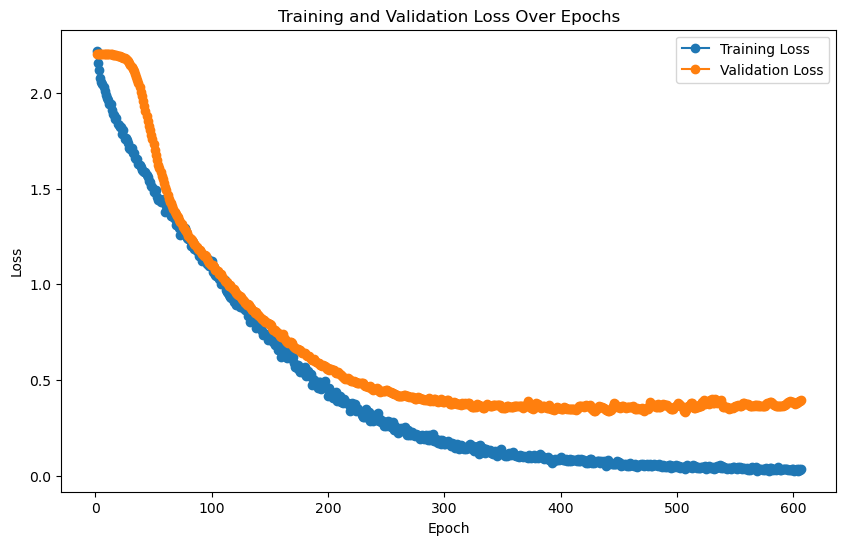

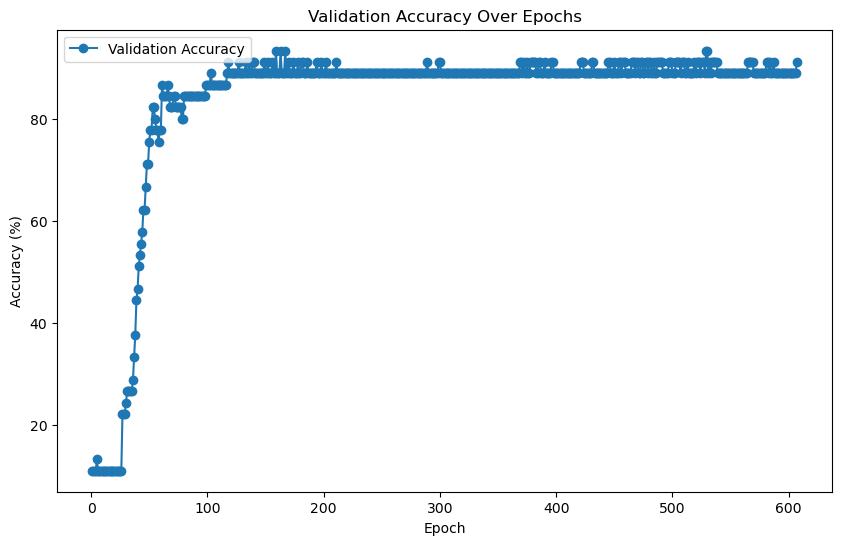


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.0957



Final Test Loss: 0.0968, Test Accuracy: 97.64%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.


  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.


  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.


  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.


  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.


Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147927, 64), Test labels shape: (147927,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.60      0.75         5
           2       0.83      1.00      0.91         5
           3       0.75      0.60      0.67         5
           4       0.80      0.80      0.80         5
           5       0.83      1.00      0.91         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00    

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147927, 64)
Test labels shape: (147927,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3218  |  Val Loss: 2.1308
Validation loss improved from inf to 2.1308.


[Epoch 2/1000] Train Loss: 2.1051  |  Val Loss: 1.9915
Validation loss improved from 2.1308 to 1.9915.
[Epoch 3/1000] Train Loss: 1.9562  |  Val Loss: 1.8643
Validation loss improved from 1.9915 to 1.8643.
[Epoch 4/1000] Train Loss: 1.8239  |  Val Loss: 1.7434
Validation loss improved from 1.8643 to 1.7434.
[Epoch 5/1000] Train Loss: 1.6959  |  Val Loss: 1.6255
Validation loss improved from 1.7434 to 1.6255.
[Epoch 6/1000] Train Loss: 1.5746  |  Val Loss: 1.5130
Validation loss improved from 1.6255 to 1.5130.
[Epoch 7/1000] Train Loss: 1.4561  |  Val Loss: 1.3980
Validation loss improved from 1.5130 to 1.3980.
[Epoch 8/1000] Train Loss: 1.3423  |  Val Loss: 1.2795
Validation loss improved from 1.3980 to 1.2795.
[Epoch 9/1000] Train Loss: 1.2217  |  Val Loss: 1.1693
Validation loss improved from 1.2795 to 1.1693.
[Epoch 10/1000] Train Loss: 1.1161  |  Val Loss: 1.0693
Validation loss improved from 1.1693 to 1.0693.
[Epoch 11/1000] Train Loss: 1.0115  |  Val Loss: 0.9775
Validation loss 

[Epoch 35/1000] Train Loss: 0.1864  |  Val Loss: 0.2930
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 36/1000] Train Loss: 0.1821  |  Val Loss: 0.2735
Validation loss improved from 0.2818 to 0.2735.
[Epoch 37/1000] Train Loss: 0.1723  |  Val Loss: 0.2706
Validation loss improved from 0.2735 to 0.2706.
[Epoch 38/1000] Train Loss: 0.1643  |  Val Loss: 0.2759
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.1593  |  Val Loss: 0.2845
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 40/1000] Train Loss: 0.1503  |  Val Loss: 0.2652
Validation loss improved from 0.2706 to 0.2652.
[Epoch 41/1000] Train Loss: 0.1522  |  Val Loss: 0.2682
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.1372  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 43/1000] Train Loss: 0.1405  |  Val Loss: 0.2786
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 44/1000] Train Loss: 

[Epoch 66/1000] Train Loss: 0.0662  |  Val Loss: 0.3294
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 67/1000] Train Loss: 0.0648  |  Val Loss: 0.3219
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 68/1000] Train Loss: 0.0677  |  Val Loss: 0.3401
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 69/1000] Train Loss: 0.0611  |  Val Loss: 0.3346
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 70/1000] Train Loss: 0.0618  |  Val Loss: 0.3366
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 71/1000] Train Loss: 0.0573  |  Val Loss: 0.3550
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 72/1000] Train Loss: 0.0589  |  Val Loss: 0.3534
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 73/1000] Train Loss: 0.0591  |  Val Loss: 0.3432
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 74/1000] Train Loss: 0.0567  |  Val Loss: 0.3582
!! Validation loss did NOT improve !! Patience: 34/100
[

[Epoch 97/1000] Train Loss: 0.0377  |  Val Loss: 0.4375
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 98/1000] Train Loss: 0.0335  |  Val Loss: 0.4349
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 99/1000] Train Loss: 0.0333  |  Val Loss: 0.4312
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 100/1000] Train Loss: 0.0325  |  Val Loss: 0.4429
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 101/1000] Train Loss: 0.0309  |  Val Loss: 0.4539
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 102/1000] Train Loss: 0.0312  |  Val Loss: 0.4590
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 103/1000] Train Loss: 0.0304  |  Val Loss: 0.4567
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 104/1000] Train Loss: 0.0302  |  Val Loss: 0.4521
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 105/1000] Train Loss: 0.0306  |  Val Loss: 0.4666
!! Validation loss did NOT improve !! Patience: 65

[Epoch 129/1000] Train Loss: 0.0200  |  Val Loss: 0.5327
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 130/1000] Train Loss: 0.0186  |  Val Loss: 0.5497
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 131/1000] Train Loss: 0.0181  |  Val Loss: 0.5489
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 132/1000] Train Loss: 0.0186  |  Val Loss: 0.5446
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 133/1000] Train Loss: 0.0167  |  Val Loss: 0.5576
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 134/1000] Train Loss: 0.0185  |  Val Loss: 0.5591
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 135/1000] Train Loss: 0.0173  |  Val Loss: 0.5414
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 136/1000] Train Loss: 0.0171  |  Val Loss: 0.5565
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 137/1000] Train Loss: 0.0159  |  Val Loss: 0.5688
!! Validation loss did NOT improve !! Patience:

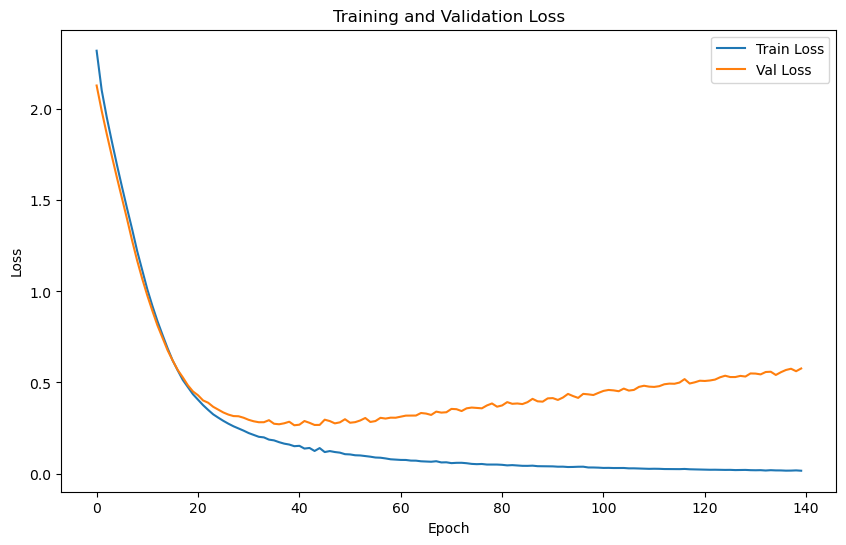

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.1700 | Test Accuracy: 95.86%


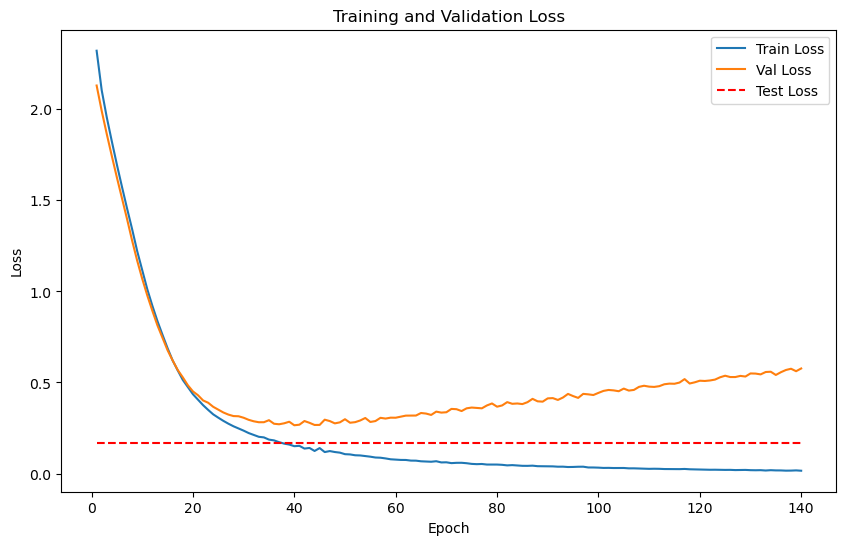

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.8381
Epoch [1/2000], Avg Train Loss: 8.8381
Epoch [1/2000], Avg Val Loss: 3.8815
Validation loss improved from inf to 3.8815. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.8315
Epoch [2/2000], Avg Train Loss: 8.8315
Epoch [2/2000], Avg Val Loss: 3.8357
Validation loss improved from 3.8815 to 3.8357. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.6805
Epoch [3/2000], Avg Train Loss: 8.6805
Epoch [3/2000], Avg Val Loss: 3.7912
Validation loss improved from 3.8357 to 3.7912. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.7387
Epoch [4/2000], Avg Train Loss: 8.7387
Epoch [4/2000], Avg Val Loss: 3.7479
Validation loss improved from 3.7912 to 3.7479. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.5567
Epoch [5/2000], Avg Train Loss: 8.5567
Epoch [5/2000], Avg Val Loss: 3.7058
Validation loss improved from 3.7479 to 3.7058. Saving mode

    Batch [1/1], Train Loss: 8.0026
Epoch [14/2000], Avg Train Loss: 8.0026
Epoch [14/2000], Avg Val Loss: 3.3765
Validation loss improved from 3.4089 to 3.3765. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.9364
Epoch [15/2000], Avg Train Loss: 7.9364
Epoch [15/2000], Avg Val Loss: 3.3452
Validation loss improved from 3.3765 to 3.3452. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.7139
Epoch [16/2000], Avg Train Loss: 7.7139
Epoch [16/2000], Avg Val Loss: 3.3149
Validation loss improved from 3.3452 to 3.3149. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.6856
Epoch [17/2000], Avg Train Loss: 7.6856
Epoch [17/2000], Avg Val Loss: 3.2855
Validation loss improved from 3.3149 to 3.2855. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.6709
Epoch [18/2000], Avg Train Loss: 7.6709
Epoch [18/2000], Avg Val Loss: 3.2570
Validation loss improved from 3.2855 to 3.

    Batch [1/1], Train Loss: 6.2686
Epoch [43/2000], Avg Train Loss: 6.2686
Epoch [43/2000], Avg Val Loss: 2.7890
Validation loss improved from 2.8004 to 2.7890. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 6.0836
Epoch [44/2000], Avg Train Loss: 6.0836
Epoch [44/2000], Avg Val Loss: 2.7780
Validation loss improved from 2.7890 to 2.7780. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.9892
Epoch [45/2000], Avg Train Loss: 5.9892
Epoch [45/2000], Avg Val Loss: 2.7675
Validation loss improved from 2.7780 to 2.7675. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.0420
Epoch [46/2000], Avg Train Loss: 6.0420
Epoch [46/2000], Avg Val Loss: 2.7575
Validation loss improved from 2.7675 to 2.7575. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.1007
Epoch [47/2000], Avg Train Loss: 6.1007
Epoch [47/2000], Avg Val Loss: 2.7479
Validation loss improved from 2.7575 to 2.

Epoch [56/2000], Avg Val Loss: 2.6778
Validation loss improved from 2.6843 to 2.6778. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.7019
Epoch [57/2000], Avg Train Loss: 5.7019
Epoch [57/2000], Avg Val Loss: 2.6715
Validation loss improved from 2.6778 to 2.6715. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.6622
Epoch [58/2000], Avg Train Loss: 5.6622
Epoch [58/2000], Avg Val Loss: 2.6655
Validation loss improved from 2.6715 to 2.6655. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.5792
Epoch [59/2000], Avg Train Loss: 5.5792
Epoch [59/2000], Avg Val Loss: 2.6598
Validation loss improved from 2.6655 to 2.6598. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.5254
Epoch [60/2000], Avg Train Loss: 5.5254
Epoch [60/2000], Avg Val Loss: 2.6543
Validation loss improved from 2.6598 to 2.6543. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Trai

Epoch [82/2000], Avg Val Loss: 2.5786
Validation loss improved from 2.5808 to 2.5786. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 4.9523
Epoch [83/2000], Avg Train Loss: 4.9523
Epoch [83/2000], Avg Val Loss: 2.5766
Validation loss improved from 2.5786 to 2.5766. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 4.9824
Epoch [84/2000], Avg Train Loss: 4.9824
Epoch [84/2000], Avg Val Loss: 2.5746
Validation loss improved from 2.5766 to 2.5746. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 5.0276
Epoch [85/2000], Avg Train Loss: 5.0276
Epoch [85/2000], Avg Val Loss: 2.5728
Validation loss improved from 2.5746 to 2.5728. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 5.0191
Epoch [86/2000], Avg Train Loss: 5.0191
Epoch [86/2000], Avg Val Loss: 2.5711
Validation loss improved from 2.5728 to 2.5711. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.7931
Epoch [97/2000], Avg Train Loss: 4.7931
Epoch [97/2000], Avg Val Loss: 2.5554
Validation loss improved from 2.5566 to 2.5554. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.9019
Epoch [98/2000], Avg Train Loss: 4.9019
Epoch [98/2000], Avg Val Loss: 2.5542
Validation loss improved from 2.5554 to 2.5542. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.8081
Epoch [99/2000], Avg Train Loss: 4.8081
Epoch [99/2000], Avg Val Loss: 2.5531
Validation loss improved from 2.5542 to 2.5531. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.7427
Epoch [100/2000], Avg Train Loss: 4.7427
Epoch [100/2000], Avg Val Loss: 2.5519
Validation loss improved from 2.5531 to 2.5519. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.8309
Epoch [101/2000], Avg Train Loss: 4.8309
Epoch [101/2000], Avg Val Loss: 2.5508
Validation loss improved from 2.5519

    Batch [1/1], Train Loss: 4.5574
Epoch [128/2000], Avg Train Loss: 4.5574
Epoch [128/2000], Avg Val Loss: 2.5280
Validation loss improved from 2.5287 to 2.5280. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.5680
Epoch [129/2000], Avg Train Loss: 4.5680
Epoch [129/2000], Avg Val Loss: 2.5273
Validation loss improved from 2.5280 to 2.5273. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.6430
Epoch [130/2000], Avg Train Loss: 4.6430
Epoch [130/2000], Avg Val Loss: 2.5266
Validation loss improved from 2.5273 to 2.5266. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.6007
Epoch [131/2000], Avg Train Loss: 4.6007
Epoch [131/2000], Avg Val Loss: 2.5259
Validation loss improved from 2.5266 to 2.5259. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.5987
Epoch [132/2000], Avg Train Loss: 4.5987
Epoch [132/2000], Avg Val Loss: 2.5252
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4604
Epoch [145/2000], Avg Train Loss: 4.4604
Epoch [145/2000], Avg Val Loss: 2.5161
Validation loss improved from 2.5169 to 2.5161. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.4582
Epoch [146/2000], Avg Train Loss: 4.4582
Epoch [146/2000], Avg Val Loss: 2.5154
Validation loss improved from 2.5161 to 2.5154. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.4301
Epoch [147/2000], Avg Train Loss: 4.4301
Epoch [147/2000], Avg Val Loss: 2.5146
Validation loss improved from 2.5154 to 2.5146. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.5046
Epoch [148/2000], Avg Train Loss: 4.5046
Epoch [148/2000], Avg Val Loss: 2.5139
Validation loss improved from 2.5146 to 2.5139. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.4347
Epoch [149/2000], Avg Train Loss: 4.4347
Epoch [149/2000], Avg Val Loss: 2.5132
Validation loss improved fro

Epoch [175/2000], Avg Val Loss: 2.4917
Validation loss improved from 2.4925 to 2.4917. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.3710
Epoch [176/2000], Avg Train Loss: 4.3710
Epoch [176/2000], Avg Val Loss: 2.4908
Validation loss improved from 2.4917 to 2.4908. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.3600
Epoch [177/2000], Avg Train Loss: 4.3600
Epoch [177/2000], Avg Val Loss: 2.4900
Validation loss improved from 2.4908 to 2.4900. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.3447
Epoch [178/2000], Avg Train Loss: 4.3447
Epoch [178/2000], Avg Val Loss: 2.4892
Validation loss improved from 2.4900 to 2.4892. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.3646
Epoch [179/2000], Avg Train Loss: 4.3646
Epoch [179/2000], Avg Val Loss: 2.4884
Validation loss improved from 2.4892 to 2.4884. Saving model...

LOG: Epoch [180/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3030
Epoch [191/2000], Avg Train Loss: 4.3030
Epoch [191/2000], Avg Val Loss: 2.4786
Validation loss improved from 2.4795 to 2.4786. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.3163
Epoch [192/2000], Avg Train Loss: 4.3163
Epoch [192/2000], Avg Val Loss: 2.4778
Validation loss improved from 2.4786 to 2.4778. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.2510
Epoch [193/2000], Avg Train Loss: 4.2510
Epoch [193/2000], Avg Val Loss: 2.4769
Validation loss improved from 2.4778 to 2.4769. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.2729
Epoch [194/2000], Avg Train Loss: 4.2729
Epoch [194/2000], Avg Val Loss: 2.4760
Validation loss improved from 2.4769 to 2.4760. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.2738
Epoch [195/2000], Avg Train Loss: 4.2738
Epoch [195/2000], Avg Val Loss: 2.4752
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2523
Epoch [217/2000], Avg Train Loss: 4.2523
Epoch [217/2000], Avg Val Loss: 2.4574
Validation loss improved from 2.4582 to 2.4574. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.2227
Epoch [218/2000], Avg Train Loss: 4.2227
Epoch [218/2000], Avg Val Loss: 2.4566
Validation loss improved from 2.4574 to 2.4566. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.2226
Epoch [219/2000], Avg Train Loss: 4.2226
Epoch [219/2000], Avg Val Loss: 2.4558
Validation loss improved from 2.4566 to 2.4558. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.1979
Epoch [220/2000], Avg Train Loss: 4.1979
Epoch [220/2000], Avg Val Loss: 2.4550
Validation loss improved from 2.4558 to 2.4550. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.2494
Epoch [221/2000], Avg Train Loss: 4.2494
Epoch [221/2000], Avg Val Loss: 2.4542
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1919
Epoch [233/2000], Avg Train Loss: 4.1919
Epoch [233/2000], Avg Val Loss: 2.4449
Validation loss improved from 2.4456 to 2.4449. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 4.2398
Epoch [234/2000], Avg Train Loss: 4.2398
Epoch [234/2000], Avg Val Loss: 2.4441
Validation loss improved from 2.4449 to 2.4441. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.2001
Epoch [235/2000], Avg Train Loss: 4.2001
Epoch [235/2000], Avg Val Loss: 2.4434
Validation loss improved from 2.4441 to 2.4434. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.1348
Epoch [236/2000], Avg Train Loss: 4.1348
Epoch [236/2000], Avg Val Loss: 2.4427
Validation loss improved from 2.4434 to 2.4427. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.1535
Epoch [237/2000], Avg Train Loss: 4.1535
Epoch [237/2000], Avg Val Loss: 2.4419
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1689
Epoch [257/2000], Avg Train Loss: 4.1689
Epoch [257/2000], Avg Val Loss: 2.4268
Validation loss improved from 2.4275 to 2.4268. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 4.1465
Epoch [258/2000], Avg Train Loss: 4.1465
Epoch [258/2000], Avg Val Loss: 2.4260
Validation loss improved from 2.4268 to 2.4260. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.1515
Epoch [259/2000], Avg Train Loss: 4.1515
Epoch [259/2000], Avg Val Loss: 2.4253
Validation loss improved from 2.4260 to 2.4253. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.1451
Epoch [260/2000], Avg Train Loss: 4.1451
Epoch [260/2000], Avg Val Loss: 2.4245
Validation loss improved from 2.4253 to 2.4245. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.1256
Epoch [261/2000], Avg Train Loss: 4.1256
Epoch [261/2000], Avg Val Loss: 2.4238
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0488
Epoch [276/2000], Avg Train Loss: 4.0488
Epoch [276/2000], Avg Val Loss: 2.4128
Validation loss improved from 2.4135 to 2.4128. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.0729
Epoch [277/2000], Avg Train Loss: 4.0729
Epoch [277/2000], Avg Val Loss: 2.4121
Validation loss improved from 2.4128 to 2.4121. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 4.1207
Epoch [278/2000], Avg Train Loss: 4.1207
Epoch [278/2000], Avg Val Loss: 2.4114
Validation loss improved from 2.4121 to 2.4114. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 4.0887
Epoch [279/2000], Avg Train Loss: 4.0887
Epoch [279/2000], Avg Val Loss: 2.4107
Validation loss improved from 2.4114 to 2.4107. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 4.1002
Epoch [280/2000], Avg Train Loss: 4.1002
Epoch [280/2000], Avg Val Loss: 2.4100
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0972
Epoch [296/2000], Avg Train Loss: 4.0972
Epoch [296/2000], Avg Val Loss: 2.3995
Validation loss improved from 2.4002 to 2.3995. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 4.0449
Epoch [297/2000], Avg Train Loss: 4.0449
Epoch [297/2000], Avg Val Loss: 2.3988
Validation loss improved from 2.3995 to 2.3988. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 4.1189
Epoch [298/2000], Avg Train Loss: 4.1189
Epoch [298/2000], Avg Val Loss: 2.3981
Validation loss improved from 2.3988 to 2.3981. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.0817
Epoch [299/2000], Avg Train Loss: 4.0817
Epoch [299/2000], Avg Val Loss: 2.3975
Validation loss improved from 2.3981 to 2.3975. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.0595
Epoch [300/2000], Avg Train Loss: 4.0595
Epoch [300/2000], Avg Val Loss: 2.3968
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0172
Epoch [321/2000], Avg Train Loss: 4.0172
Epoch [321/2000], Avg Val Loss: 2.3834
Validation loss improved from 2.3841 to 2.3834. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 4.0577
Epoch [322/2000], Avg Train Loss: 4.0577
Epoch [322/2000], Avg Val Loss: 2.3828
Validation loss improved from 2.3834 to 2.3828. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 4.0309
Epoch [323/2000], Avg Train Loss: 4.0309
Epoch [323/2000], Avg Val Loss: 2.3822
Validation loss improved from 2.3828 to 2.3822. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 4.0677
Epoch [324/2000], Avg Train Loss: 4.0677
Epoch [324/2000], Avg Val Loss: 2.3816
Validation loss improved from 2.3822 to 2.3816. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 3.9900
Epoch [325/2000], Avg Train Loss: 3.9900
Epoch [325/2000], Avg Val Loss: 2.3810
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9994
Epoch [340/2000], Avg Train Loss: 3.9994
Epoch [340/2000], Avg Val Loss: 2.3724
Validation loss improved from 2.3730 to 2.3724. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.0018
Epoch [341/2000], Avg Train Loss: 4.0018
Epoch [341/2000], Avg Val Loss: 2.3719
Validation loss improved from 2.3724 to 2.3719. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 4.0046
Epoch [342/2000], Avg Train Loss: 4.0046
Epoch [342/2000], Avg Val Loss: 2.3713
Validation loss improved from 2.3719 to 2.3713. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 3.9862
Epoch [343/2000], Avg Train Loss: 3.9862
Epoch [343/2000], Avg Val Loss: 2.3708
Validation loss improved from 2.3713 to 2.3708. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 3.9881
Epoch [344/2000], Avg Train Loss: 3.9881
Epoch [344/2000], Avg Val Loss: 2.3703
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9745
Epoch [366/2000], Avg Train Loss: 3.9745
Epoch [366/2000], Avg Val Loss: 2.3601
Validation loss improved from 2.3606 to 2.3601. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 3.9881
Epoch [367/2000], Avg Train Loss: 3.9881
Epoch [367/2000], Avg Val Loss: 2.3596
Validation loss improved from 2.3601 to 2.3596. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 3.9350
Epoch [368/2000], Avg Train Loss: 3.9350
Epoch [368/2000], Avg Val Loss: 2.3591
Validation loss improved from 2.3596 to 2.3591. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 3.9382
Epoch [369/2000], Avg Train Loss: 3.9382
Epoch [369/2000], Avg Val Loss: 2.3586
Validation loss improved from 2.3591 to 2.3586. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.9691
Epoch [370/2000], Avg Train Loss: 3.9691
Epoch [370/2000], Avg Val Loss: 2.3581
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9174
Epoch [382/2000], Avg Train Loss: 3.9174
Epoch [382/2000], Avg Val Loss: 2.3522
Validation loss improved from 2.3527 to 2.3522. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 3.9122
Epoch [383/2000], Avg Train Loss: 3.9122
Epoch [383/2000], Avg Val Loss: 2.3517
Validation loss improved from 2.3522 to 2.3517. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 3.9389
Epoch [384/2000], Avg Train Loss: 3.9389
Epoch [384/2000], Avg Val Loss: 2.3513
Validation loss improved from 2.3517 to 2.3513. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 3.9666
Epoch [385/2000], Avg Train Loss: 3.9666
Epoch [385/2000], Avg Val Loss: 2.3508
Validation loss improved from 2.3513 to 2.3508. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 3.9239
Epoch [386/2000], Avg Train Loss: 3.9239
Epoch [386/2000], Avg Val Loss: 2.3503
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8850
Epoch [405/2000], Avg Train Loss: 3.8850
Epoch [405/2000], Avg Val Loss: 2.3415
Validation loss improved from 2.3420 to 2.3415. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 3.8943
Epoch [406/2000], Avg Train Loss: 3.8943
Epoch [406/2000], Avg Val Loss: 2.3411
Validation loss improved from 2.3415 to 2.3411. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 3.8911
Epoch [407/2000], Avg Train Loss: 3.8911
Epoch [407/2000], Avg Val Loss: 2.3407
Validation loss improved from 2.3411 to 2.3407. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 3.9126
Epoch [408/2000], Avg Train Loss: 3.9126
Epoch [408/2000], Avg Val Loss: 2.3402
Validation loss improved from 2.3407 to 2.3402. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 3.9021
Epoch [409/2000], Avg Train Loss: 3.9021
Epoch [409/2000], Avg Val Loss: 2.3398
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8950
Epoch [422/2000], Avg Train Loss: 3.8950
Epoch [422/2000], Avg Val Loss: 2.3343
Validation loss improved from 2.3347 to 2.3343. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 3.8552
Epoch [423/2000], Avg Train Loss: 3.8552
Epoch [423/2000], Avg Val Loss: 2.3339
Validation loss improved from 2.3343 to 2.3339. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 3.8852
Epoch [424/2000], Avg Train Loss: 3.8852
Epoch [424/2000], Avg Val Loss: 2.3336
Validation loss improved from 2.3339 to 2.3336. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 3.8825
Epoch [425/2000], Avg Train Loss: 3.8825
Epoch [425/2000], Avg Val Loss: 2.3332
Validation loss improved from 2.3336 to 2.3332. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 3.9197
Epoch [426/2000], Avg Train Loss: 3.9197
Epoch [426/2000], Avg Val Loss: 2.3328
Validation loss improved fro

Epoch [445/2000], Avg Val Loss: 2.3251
Validation loss improved from 2.3255 to 2.3251. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 3.9154
Epoch [446/2000], Avg Train Loss: 3.9154
Epoch [446/2000], Avg Val Loss: 2.3247
Validation loss improved from 2.3251 to 2.3247. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 3.8380
Epoch [447/2000], Avg Train Loss: 3.8380
Epoch [447/2000], Avg Val Loss: 2.3243
Validation loss improved from 2.3247 to 2.3243. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 3.8527
Epoch [448/2000], Avg Train Loss: 3.8527
Epoch [448/2000], Avg Val Loss: 2.3239
Validation loss improved from 2.3243 to 2.3239. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 3.9116
Epoch [449/2000], Avg Train Loss: 3.9116
Epoch [449/2000], Avg Val Loss: 2.3235
Validation loss improved from 2.3239 to 2.3235. Saving model...

LOG: Epoch [450/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8623
Epoch [462/2000], Avg Train Loss: 3.8623
Epoch [462/2000], Avg Val Loss: 2.3185
Validation loss improved from 2.3189 to 2.3185. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 3.8784
Epoch [463/2000], Avg Train Loss: 3.8784
Epoch [463/2000], Avg Val Loss: 2.3182
Validation loss improved from 2.3185 to 2.3182. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 3.8187
Epoch [464/2000], Avg Train Loss: 3.8187
Epoch [464/2000], Avg Val Loss: 2.3178
Validation loss improved from 2.3182 to 2.3178. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 3.8421
Epoch [465/2000], Avg Train Loss: 3.8421
Epoch [465/2000], Avg Val Loss: 2.3174
Validation loss improved from 2.3178 to 2.3174. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 3.8449
Epoch [466/2000], Avg Train Loss: 3.8449
Epoch [466/2000], Avg Val Loss: 2.3170
Validation loss improved fro

Epoch [482/2000], Avg Val Loss: 2.3112
Validation loss improved from 2.3115 to 2.3112. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 3.8382
Epoch [483/2000], Avg Train Loss: 3.8382
Epoch [483/2000], Avg Val Loss: 2.3109
Validation loss improved from 2.3112 to 2.3109. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 3.8237
Epoch [484/2000], Avg Train Loss: 3.8237
Epoch [484/2000], Avg Val Loss: 2.3106
Validation loss improved from 2.3109 to 2.3106. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 3.8393
Epoch [485/2000], Avg Train Loss: 3.8393
Epoch [485/2000], Avg Val Loss: 2.3103
Validation loss improved from 2.3106 to 2.3103. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 3.8317
Epoch [486/2000], Avg Train Loss: 3.8317
Epoch [486/2000], Avg Val Loss: 2.3100
Validation loss improved from 2.3103 to 2.3100. Saving model...

LOG: Epoch [487/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8085
Epoch [498/2000], Avg Train Loss: 3.8085
Epoch [498/2000], Avg Val Loss: 2.3062
Validation loss improved from 2.3065 to 2.3062. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 3.8325
Epoch [499/2000], Avg Train Loss: 3.8325
Epoch [499/2000], Avg Val Loss: 2.3059
Validation loss improved from 2.3062 to 2.3059. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 3.8143
Epoch [500/2000], Avg Train Loss: 3.8143
Epoch [500/2000], Avg Val Loss: 2.3057
Validation loss improved from 2.3059 to 2.3057. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 3.8131
Epoch [501/2000], Avg Train Loss: 3.8131
Epoch [501/2000], Avg Val Loss: 2.3054
Validation loss improved from 2.3057 to 2.3054. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 3.7921
Epoch [502/2000], Avg Train Loss: 3.7921
Epoch [502/2000], Avg Val Loss: 2.3050
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7798
Epoch [525/2000], Avg Train Loss: 3.7798
Epoch [525/2000], Avg Val Loss: 2.2976
Validation loss improved from 2.2979 to 2.2976. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.8084
Epoch [526/2000], Avg Train Loss: 3.8084
Epoch [526/2000], Avg Val Loss: 2.2973
Validation loss improved from 2.2976 to 2.2973. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 3.8088
Epoch [527/2000], Avg Train Loss: 3.8088
Epoch [527/2000], Avg Val Loss: 2.2970
Validation loss improved from 2.2973 to 2.2970. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.7356
Epoch [528/2000], Avg Train Loss: 3.7356
Epoch [528/2000], Avg Val Loss: 2.2967
Validation loss improved from 2.2970 to 2.2967. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.7812
Epoch [529/2000], Avg Train Loss: 3.7812
Epoch [529/2000], Avg Val Loss: 2.2964
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8188
Epoch [541/2000], Avg Train Loss: 3.8188
Epoch [541/2000], Avg Val Loss: 2.2933
Validation loss improved from 2.2936 to 2.2933. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 3.7540
Epoch [542/2000], Avg Train Loss: 3.7540
Epoch [542/2000], Avg Val Loss: 2.2930
Validation loss improved from 2.2933 to 2.2930. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 3.7681
Epoch [543/2000], Avg Train Loss: 3.7681
Epoch [543/2000], Avg Val Loss: 2.2927
Validation loss improved from 2.2930 to 2.2927. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 3.7534
Epoch [544/2000], Avg Train Loss: 3.7534
Epoch [544/2000], Avg Val Loss: 2.2924
Validation loss improved from 2.2927 to 2.2924. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 3.7298
Epoch [545/2000], Avg Train Loss: 3.7298
Epoch [545/2000], Avg Val Loss: 2.2921
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7957
Epoch [569/2000], Avg Train Loss: 3.7957
Epoch [569/2000], Avg Val Loss: 2.2854
Validation loss improved from 2.2857 to 2.2854. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 3.7390
Epoch [570/2000], Avg Train Loss: 3.7390
Epoch [570/2000], Avg Val Loss: 2.2852
Validation loss improved from 2.2854 to 2.2852. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 3.7302
Epoch [571/2000], Avg Train Loss: 3.7302
Epoch [571/2000], Avg Val Loss: 2.2849
Validation loss improved from 2.2852 to 2.2849. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 3.6849
Epoch [572/2000], Avg Train Loss: 3.6849
Epoch [572/2000], Avg Val Loss: 2.2847
Validation loss improved from 2.2849 to 2.2847. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.7337
Epoch [573/2000], Avg Train Loss: 3.7337
Epoch [573/2000], Avg Val Loss: 2.2844
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7805
Epoch [582/2000], Avg Train Loss: 3.7805
Epoch [582/2000], Avg Val Loss: 2.2819
Validation loss improved from 2.2822 to 2.2819. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 3.7145
Epoch [583/2000], Avg Train Loss: 3.7145
Epoch [583/2000], Avg Val Loss: 2.2816
Validation loss improved from 2.2819 to 2.2816. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 3.7471
Epoch [584/2000], Avg Train Loss: 3.7471
Epoch [584/2000], Avg Val Loss: 2.2814
Validation loss improved from 2.2816 to 2.2814. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 3.7476
Epoch [585/2000], Avg Train Loss: 3.7476
Epoch [585/2000], Avg Val Loss: 2.2811
Validation loss improved from 2.2814 to 2.2811. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 3.7040
Epoch [586/2000], Avg Train Loss: 3.7040
Epoch [586/2000], Avg Val Loss: 2.2809
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7202
Epoch [610/2000], Avg Train Loss: 3.7202
Epoch [610/2000], Avg Val Loss: 2.2761
Validation loss improved from 2.2763 to 2.2761. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.7552
Epoch [611/2000], Avg Train Loss: 3.7552
Epoch [611/2000], Avg Val Loss: 2.2759
Validation loss improved from 2.2761 to 2.2759. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.7320
Epoch [612/2000], Avg Train Loss: 3.7320
Epoch [612/2000], Avg Val Loss: 2.2757
Validation loss improved from 2.2759 to 2.2757. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 3.7124
Epoch [613/2000], Avg Train Loss: 3.7124
Epoch [613/2000], Avg Val Loss: 2.2755
Validation loss improved from 2.2757 to 2.2755. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 3.7065
Epoch [614/2000], Avg Train Loss: 3.7065
Epoch [614/2000], Avg Val Loss: 2.2753
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6705
Epoch [620/2000], Avg Train Loss: 3.6705
Epoch [620/2000], Avg Val Loss: 2.2742
Validation loss improved from 2.2744 to 2.2742. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 3.6987
Epoch [621/2000], Avg Train Loss: 3.6987
Epoch [621/2000], Avg Val Loss: 2.2740
Validation loss improved from 2.2742 to 2.2740. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 3.6713
Epoch [622/2000], Avg Train Loss: 3.6713
Epoch [622/2000], Avg Val Loss: 2.2737
Validation loss improved from 2.2740 to 2.2737. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.6693
Epoch [623/2000], Avg Train Loss: 3.6693
Epoch [623/2000], Avg Val Loss: 2.2735
Validation loss improved from 2.2737 to 2.2735. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.7275
Epoch [624/2000], Avg Train Loss: 3.7275
Epoch [624/2000], Avg Val Loss: 2.2733
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7315
Epoch [633/2000], Avg Train Loss: 3.7315
Epoch [633/2000], Avg Val Loss: 2.2719
Validation loss improved from 2.2720 to 2.2719. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 3.7138
Epoch [634/2000], Avg Train Loss: 3.7138
Epoch [634/2000], Avg Val Loss: 2.2718
Validation loss improved from 2.2719 to 2.2718. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.6457
Epoch [635/2000], Avg Train Loss: 3.6457
Epoch [635/2000], Avg Val Loss: 2.2717
Validation loss improved from 2.2718 to 2.2717. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 3.7036
Epoch [636/2000], Avg Train Loss: 3.7036
Epoch [636/2000], Avg Val Loss: 2.2715
Validation loss improved from 2.2717 to 2.2715. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.6782
Epoch [637/2000], Avg Train Loss: 3.6782
Epoch [637/2000], Avg Val Loss: 2.2713
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7046
Epoch [663/2000], Avg Train Loss: 3.7046
Epoch [663/2000], Avg Val Loss: 2.2673
Validation loss improved from 2.2675 to 2.2673. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.6631
Epoch [664/2000], Avg Train Loss: 3.6631
Epoch [664/2000], Avg Val Loss: 2.2672
Validation loss improved from 2.2673 to 2.2672. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.6555
Epoch [665/2000], Avg Train Loss: 3.6555
Epoch [665/2000], Avg Val Loss: 2.2671
Validation loss improved from 2.2672 to 2.2671. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 3.6642
Epoch [666/2000], Avg Train Loss: 3.6642
Epoch [666/2000], Avg Val Loss: 2.2669
Validation loss improved from 2.2671 to 2.2669. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 3.6528
Epoch [667/2000], Avg Train Loss: 3.6528
Epoch [667/2000], Avg Val Loss: 2.2666
Validation loss improved fro

Epoch [675/2000], Avg Val Loss: 2.2647
Validation loss improved from 2.2650 to 2.2647. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.6692
Epoch [676/2000], Avg Train Loss: 3.6692
Epoch [676/2000], Avg Val Loss: 2.2645
Validation loss improved from 2.2647 to 2.2645. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 3.6472
Epoch [677/2000], Avg Train Loss: 3.6472
Epoch [677/2000], Avg Val Loss: 2.2642
Validation loss improved from 2.2645 to 2.2642. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 3.6277
Epoch [678/2000], Avg Train Loss: 3.6277
Epoch [678/2000], Avg Val Loss: 2.2641
Validation loss improved from 2.2642 to 2.2641. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 3.6257
Epoch [679/2000], Avg Train Loss: 3.6257
Epoch [679/2000], Avg Val Loss: 2.2639
Validation loss improved from 2.2641 to 2.2639. Saving model...

LOG: Epoch [680/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6214
Epoch [708/2000], Avg Train Loss: 3.6214
Epoch [708/2000], Avg Val Loss: 2.2610
Validation loss improved from 2.2610 to 2.2610. Saving model...

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 3.6223
Epoch [709/2000], Avg Train Loss: 3.6223
Epoch [709/2000], Avg Val Loss: 2.2609
Validation loss improved from 2.2610 to 2.2609. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 3.6461
Epoch [710/2000], Avg Train Loss: 3.6461
Epoch [710/2000], Avg Val Loss: 2.2608
Validation loss improved from 2.2609 to 2.2608. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 3.6100
Epoch [711/2000], Avg Train Loss: 3.6100
Epoch [711/2000], Avg Val Loss: 2.2607
Validation loss improved from 2.2608 to 2.2607. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 3.6681
Epoch [712/2000], Avg Train Loss: 3.6681
Epoch [712/2000], Avg Val Loss: 2.2606
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6469
Epoch [720/2000], Avg Train Loss: 3.6469
Epoch [720/2000], Avg Val Loss: 2.2602
Validation loss improved from 2.2602 to 2.2602. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 3.6432
Epoch [721/2000], Avg Train Loss: 3.6432
Epoch [721/2000], Avg Val Loss: 2.2601
Validation loss improved from 2.2602 to 2.2601. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 3.6351
Epoch [722/2000], Avg Train Loss: 3.6351
Epoch [722/2000], Avg Val Loss: 2.2601
Validation loss improved from 2.2601 to 2.2601. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 3.6454
Epoch [723/2000], Avg Train Loss: 3.6454
Epoch [723/2000], Avg Val Loss: 2.2601
Validation loss improved from 2.2601 to 2.2601. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.6594
Epoch [724/2000], Avg Train Loss: 3.6594
Epoch [724/2000], Avg Val Loss: 2.2600
Validation loss improved fro

Epoch [748/2000], Avg Val Loss: 2.2568
Validation loss improved from 2.2570 to 2.2568. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 3.6393
Epoch [749/2000], Avg Train Loss: 3.6393
Epoch [749/2000], Avg Val Loss: 2.2566
Validation loss improved from 2.2568 to 2.2566. Saving model...

LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 3.6125
Epoch [750/2000], Avg Train Loss: 3.6125
Epoch [750/2000], Avg Val Loss: 2.2564
Validation loss improved from 2.2566 to 2.2564. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 3.6301
Epoch [751/2000], Avg Train Loss: 3.6301
Epoch [751/2000], Avg Val Loss: 2.2562
Validation loss improved from 2.2564 to 2.2562. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 3.6136
Epoch [752/2000], Avg Train Loss: 3.6136
Epoch [752/2000], Avg Val Loss: 2.2561
Validation loss improved from 2.2562 to 2.2561. Saving model...

LOG: Epoch [753/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5810
Epoch [762/2000], Avg Train Loss: 3.5810
Epoch [762/2000], Avg Val Loss: 2.2541
Validation loss improved from 2.2543 to 2.2541. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 3.6047
Epoch [763/2000], Avg Train Loss: 3.6047
Epoch [763/2000], Avg Val Loss: 2.2539
Validation loss improved from 2.2541 to 2.2539. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 3.5599
Epoch [764/2000], Avg Train Loss: 3.5599
Epoch [764/2000], Avg Val Loss: 2.2538
Validation loss improved from 2.2539 to 2.2538. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 3.5892
Epoch [765/2000], Avg Train Loss: 3.5892
Epoch [765/2000], Avg Val Loss: 2.2536
Validation loss improved from 2.2538 to 2.2536. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 3.6009
Epoch [766/2000], Avg Train Loss: 3.6009
Epoch [766/2000], Avg Val Loss: 2.2534
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5931
Epoch [792/2000], Avg Train Loss: 3.5931
Epoch [792/2000], Avg Val Loss: 2.2502
Validation loss improved from 2.2503 to 2.2502. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 3.5908
Epoch [793/2000], Avg Train Loss: 3.5908
Epoch [793/2000], Avg Val Loss: 2.2501
Validation loss improved from 2.2502 to 2.2501. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 3.6178
Epoch [794/2000], Avg Train Loss: 3.6178
Epoch [794/2000], Avg Val Loss: 2.2501
Validation loss improved from 2.2501 to 2.2501. Saving model...

LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 3.5976
Epoch [795/2000], Avg Train Loss: 3.5976
Epoch [795/2000], Avg Val Loss: 2.2500
Validation loss improved from 2.2501 to 2.2500. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 3.5590
Epoch [796/2000], Avg Train Loss: 3.5590
Epoch [796/2000], Avg Val Loss: 2.2500
Validation loss improved fro

Epoch [807/2000], Avg Val Loss: 2.2505
Validation loss did not improve. Patience: 11/100

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 3.5768
Epoch [808/2000], Avg Train Loss: 3.5768
Epoch [808/2000], Avg Val Loss: 2.2504
Validation loss did not improve. Patience: 12/100

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 3.5722
Epoch [809/2000], Avg Train Loss: 3.5722
Epoch [809/2000], Avg Val Loss: 2.2504
Validation loss did not improve. Patience: 13/100

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 3.5493
Epoch [810/2000], Avg Train Loss: 3.5493
Epoch [810/2000], Avg Val Loss: 2.2504
Validation loss did not improve. Patience: 14/100

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 3.5528
Epoch [811/2000], Avg Train Loss: 3.5528
Epoch [811/2000], Avg Val Loss: 2.2503
Validation loss did not improve. Patience: 15/100

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 3.5561
Epoch [812/2000], Avg Train Loss: 3.5561


    Batch [1/1], Train Loss: 3.5314
Epoch [837/2000], Avg Train Loss: 3.5314
Epoch [837/2000], Avg Val Loss: 2.2521
Validation loss did not improve. Patience: 41/100

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 3.5214
Epoch [838/2000], Avg Train Loss: 3.5214
Epoch [838/2000], Avg Val Loss: 2.2523
Validation loss did not improve. Patience: 42/100

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 3.4867
Epoch [839/2000], Avg Train Loss: 3.4867
Epoch [839/2000], Avg Val Loss: 2.2525
Validation loss did not improve. Patience: 43/100

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 3.5694
Epoch [840/2000], Avg Train Loss: 3.5694
Epoch [840/2000], Avg Val Loss: 2.2527
Validation loss did not improve. Patience: 44/100

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 3.5509
Epoch [841/2000], Avg Train Loss: 3.5509
Epoch [841/2000], Avg Val Loss: 2.2530
Validation loss did not improve. Patience: 45/100

LOG: Epoch [842/2000] - Training


Epoch [848/2000], Avg Val Loss: 2.2548
Validation loss did not improve. Patience: 52/100

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.5091
Epoch [849/2000], Avg Train Loss: 3.5091
Epoch [849/2000], Avg Val Loss: 2.2550
Validation loss did not improve. Patience: 53/100

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.5545
Epoch [850/2000], Avg Train Loss: 3.5545
Epoch [850/2000], Avg Val Loss: 2.2551
Validation loss did not improve. Patience: 54/100

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.5780
Epoch [851/2000], Avg Train Loss: 3.5780
Epoch [851/2000], Avg Val Loss: 2.2553
Validation loss did not improve. Patience: 55/100

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.5357
Epoch [852/2000], Avg Train Loss: 3.5357
Epoch [852/2000], Avg Val Loss: 2.2554
Validation loss did not improve. Patience: 56/100

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.5610
Epoch [853/2000], Avg Train Loss: 3.5610


    Batch [1/1], Train Loss: 3.5438
Epoch [878/2000], Avg Train Loss: 3.5438
Epoch [878/2000], Avg Val Loss: 2.2555
Validation loss did not improve. Patience: 82/100

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 3.5123
Epoch [879/2000], Avg Train Loss: 3.5123
Epoch [879/2000], Avg Val Loss: 2.2554
Validation loss did not improve. Patience: 83/100

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 3.5204
Epoch [880/2000], Avg Train Loss: 3.5204
Epoch [880/2000], Avg Val Loss: 2.2554
Validation loss did not improve. Patience: 84/100

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 3.5443
Epoch [881/2000], Avg Train Loss: 3.5443
Epoch [881/2000], Avg Val Loss: 2.2554
Validation loss did not improve. Patience: 85/100

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 3.5099
Epoch [882/2000], Avg Train Loss: 3.5099
Epoch [882/2000], Avg Val Loss: 2.2553
Validation loss did not improve. Patience: 86/100

LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 3.5491
Epoch [895/2000], Avg Train Loss: 3.5491
Epoch [895/2000], Avg Val Loss: 2.2561
Validation loss did not improve. Patience: 99/100

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 3.5052
Epoch [896/2000], Avg Train Loss: 3.5052
Epoch [896/2000], Avg Val Loss: 2.2562
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 896. No improvement for 100 epochs.


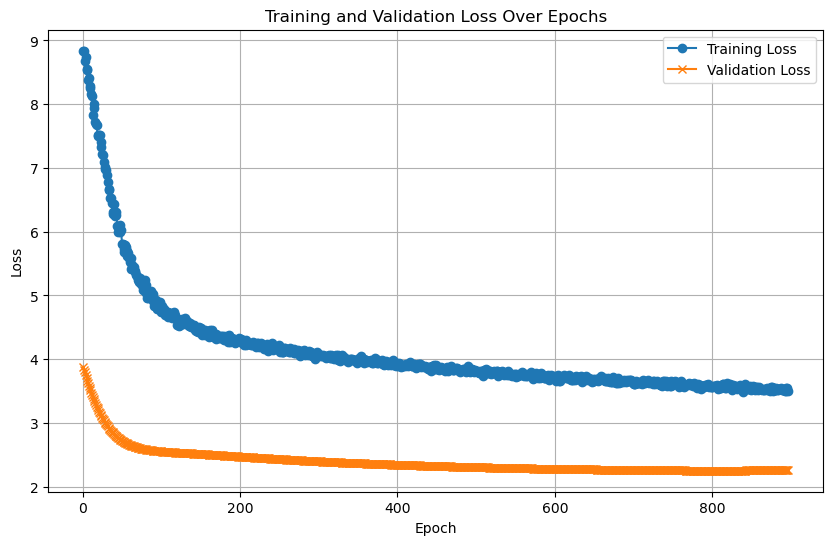

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 5.4438


Test Batch [20/578], Loss: 5.4794
Test Batch [30/578], Loss: 5.4206
Test Batch [40/578], Loss: 5.3355
Test Batch [50/578], Loss: 5.3676
Test Batch [60/578], Loss: 5.3220
Test Batch [70/578], Loss: 5.3499


Test Batch [80/578], Loss: 5.2089
Test Batch [90/578], Loss: 5.3432
Test Batch [100/578], Loss: 5.3270
Test Batch [110/578], Loss: 5.3515
Test Batch [120/578], Loss: 5.3854
Test Batch [130/578], Loss: 5.4063
Test Batch [140/578], Loss: 5.4504
Test Batch [150/578], Loss: 5.4599


Test Batch [160/578], Loss: 5.3495
Test Batch [170/578], Loss: 5.3669
Test Batch [180/578], Loss: 5.3910
Test Batch [190/578], Loss: 5.3865
Test Batch [200/578], Loss: 5.3015
Test Batch [210/578], Loss: 5.2522
Test Batch [220/578], Loss: 5.2240


Test Batch [230/578], Loss: 5.2768
Test Batch [240/578], Loss: 5.1631
Test Batch [250/578], Loss: 5.2064
Test Batch [260/578], Loss: 5.2887
Test Batch [270/578], Loss: 5.2637
Test Batch [280/578], Loss: 5.4218
Test Batch [290/578], Loss: 5.2272


Test Batch [300/578], Loss: 5.0544
Test Batch [310/578], Loss: 5.0207
Test Batch [320/578], Loss: 5.0348
Test Batch [330/578], Loss: 5.0958
Test Batch [340/578], Loss: 5.0071
Test Batch [350/578], Loss: 5.0687
Test Batch [360/578], Loss: 5.1069
Test Batch [370/578], Loss: 5.0266


Test Batch [380/578], Loss: 5.4561
Test Batch [390/578], Loss: 5.0737
Test Batch [400/578], Loss: 5.0566
Test Batch [410/578], Loss: 5.0286
Test Batch [420/578], Loss: 4.9318
Test Batch [430/578], Loss: 5.0984


Test Batch [440/578], Loss: 5.0903
Test Batch [450/578], Loss: 5.0532
Test Batch [460/578], Loss: 5.1486
Test Batch [470/578], Loss: 5.0447
Test Batch [480/578], Loss: 5.3685
Test Batch [490/578], Loss: 5.1668
Test Batch [500/578], Loss: 5.1803
Test Batch [510/578], Loss: 5.1035
Test Batch [520/578], Loss: 5.3916


Test Batch [530/578], Loss: 5.0662
Test Batch [540/578], Loss: 5.5279
Test Batch [550/578], Loss: 5.3568
Test Batch [560/578], Loss: 5.4941
Test Batch [570/578], Loss: 5.4102

Test Loss: 5.2570


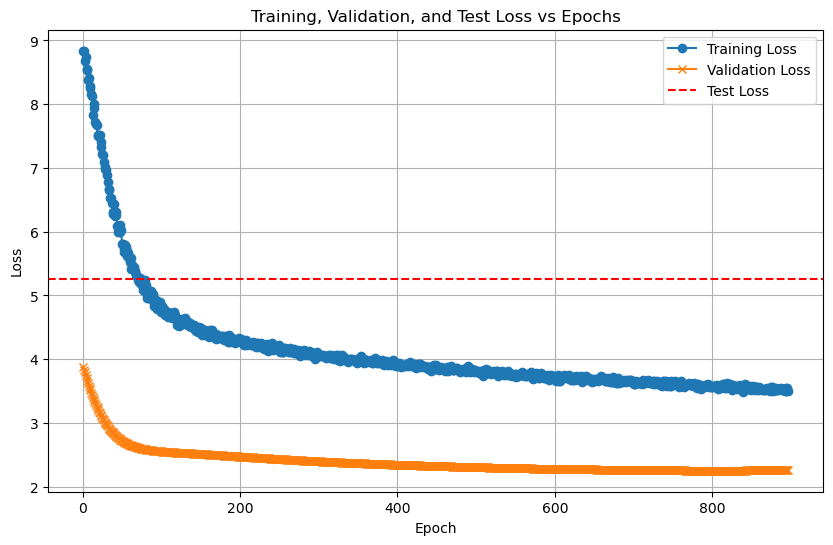

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.


  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.


  Processed batch 80/578 for test dataset.
  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.


  Processed batch 130/578 for test dataset.
  Processed batch 140/578 for test dataset.


  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.
  Processed batch 190/578 for test dataset.


  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.


  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.


  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.


  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.


  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.


  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.


  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.


  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.


  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.


  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.60      0.75         5
           2       0.83      1.00      0.91         5
           3       0.75      0.60      0.67         5
           4       0.80      0.80      0.80         5
           5       0.71      1.00      0.83         5
           6       0.80      0.80      0.80         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.86        45
weighted avg       0.88      0.87      0.86        45


LOG: Evaluating on the test set...
Test Accuracy: 96.50%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65946
           1       0.97      0.84      0.90      7573
           2       0.69      0.91      0.79      3065
           3       0.64      0.78      0.70      2660
           4       0.88      0.91      0.89      6559
           5       0.88      0.96      0.92      9223
           6       0.95      0.84      0.89      7262
           7       1.00      0.98      0.99     42801
           8       0.97      1.00      0.98      2838

    accuracy                           0.96    147927
   macro avg       0.89      0.91      0.90    147927
weighted avg       0.97      0.96      0.97    147927

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5311  |  Val Loss: 2.4491
Validation loss improved from inf to 2.4491.
[Epoch 2/1000] Train Loss: 2.4757  |  Val Loss: 2.4022
Validation loss improved from 2.4491 to 2.4022.
[Epoch 3/1000] Train Loss: 2.4241  |  Val Loss: 2.3579
Validation loss improved from 2.4022 to 2.3579.
[Epoch 4/1000] Train Loss: 2.3737  |  Val Loss: 2.3145
Validation loss improved from 2.3579 to 2.3145.
[Epoch 5/1000] Train Loss: 2.3266  |  Val Loss: 2.2726
Validation loss improved from 2.3145 to 2.2726.
[Epoch 6/1000] Train Loss: 2.2823  |  Val Loss: 2.2331
Validation loss improved from 2.2726 to 2.2331.
[Epoch 7/1000] Train Loss: 2.2392  |  Val Loss: 2.1976
Validation loss improved from 2.2331 to 2.1976.
[Epoch 8/1000] Train Loss: 2.2006  |  Val Loss: 2.1650
Validation loss improved from 2.1976 to 2.1650.
[Epoch 9/1000] Train Loss: 2.1658  |  Val Loss: 2.1332
Validation loss improved from 2.1650 to 2.1332.
[Epoch 10/1000] Train Loss: 2.1320  |  Val Loss: 2.1030
Validation loss impr

[Epoch 28/1000] Train Loss: 1.6588  |  Val Loss: 1.6636
Validation loss improved from 1.6852 to 1.6636.
[Epoch 29/1000] Train Loss: 1.6359  |  Val Loss: 1.6416
Validation loss improved from 1.6636 to 1.6416.
[Epoch 30/1000] Train Loss: 1.6129  |  Val Loss: 1.6200
Validation loss improved from 1.6416 to 1.6200.
[Epoch 31/1000] Train Loss: 1.5898  |  Val Loss: 1.5983
Validation loss improved from 1.6200 to 1.5983.
[Epoch 32/1000] Train Loss: 1.5669  |  Val Loss: 1.5762
Validation loss improved from 1.5983 to 1.5762.
[Epoch 33/1000] Train Loss: 1.5441  |  Val Loss: 1.5540
Validation loss improved from 1.5762 to 1.5540.
[Epoch 34/1000] Train Loss: 1.5210  |  Val Loss: 1.5317
Validation loss improved from 1.5540 to 1.5317.
[Epoch 35/1000] Train Loss: 1.4984  |  Val Loss: 1.5093
Validation loss improved from 1.5317 to 1.5093.
[Epoch 36/1000] Train Loss: 1.4751  |  Val Loss: 1.4872
Validation loss improved from 1.5093 to 1.4872.
[Epoch 37/1000] Train Loss: 1.4519  |  Val Loss: 1.4652
Validati

[Epoch 57/1000] Train Loss: 1.0304  |  Val Loss: 1.0752
Validation loss improved from 1.0924 to 1.0752.
[Epoch 58/1000] Train Loss: 1.0114  |  Val Loss: 1.0582
Validation loss improved from 1.0752 to 1.0582.
[Epoch 59/1000] Train Loss: 0.9926  |  Val Loss: 1.0415
Validation loss improved from 1.0582 to 1.0415.
[Epoch 60/1000] Train Loss: 0.9740  |  Val Loss: 1.0249
Validation loss improved from 1.0415 to 1.0249.
[Epoch 61/1000] Train Loss: 0.9560  |  Val Loss: 1.0083
Validation loss improved from 1.0249 to 1.0083.
[Epoch 62/1000] Train Loss: 0.9377  |  Val Loss: 0.9923
Validation loss improved from 1.0083 to 0.9923.
[Epoch 63/1000] Train Loss: 0.9202  |  Val Loss: 0.9767
Validation loss improved from 0.9923 to 0.9767.
[Epoch 64/1000] Train Loss: 0.9028  |  Val Loss: 0.9611
Validation loss improved from 0.9767 to 0.9611.
[Epoch 65/1000] Train Loss: 0.8854  |  Val Loss: 0.9460
Validation loss improved from 0.9611 to 0.9460.
[Epoch 66/1000] Train Loss: 0.8687  |  Val Loss: 0.9312
Validati

[Epoch 89/1000] Train Loss: 0.5556  |  Val Loss: 0.6614
Validation loss improved from 0.6703 to 0.6614.
[Epoch 90/1000] Train Loss: 0.5450  |  Val Loss: 0.6526
Validation loss improved from 0.6614 to 0.6526.
[Epoch 91/1000] Train Loss: 0.5346  |  Val Loss: 0.6441
Validation loss improved from 0.6526 to 0.6441.
[Epoch 92/1000] Train Loss: 0.5247  |  Val Loss: 0.6358
Validation loss improved from 0.6441 to 0.6358.
[Epoch 93/1000] Train Loss: 0.5149  |  Val Loss: 0.6277
Validation loss improved from 0.6358 to 0.6277.
[Epoch 94/1000] Train Loss: 0.5058  |  Val Loss: 0.6200
Validation loss improved from 0.6277 to 0.6200.
[Epoch 95/1000] Train Loss: 0.4966  |  Val Loss: 0.6124
Validation loss improved from 0.6200 to 0.6124.
[Epoch 96/1000] Train Loss: 0.4876  |  Val Loss: 0.6051
Validation loss improved from 0.6124 to 0.6051.
[Epoch 97/1000] Train Loss: 0.4789  |  Val Loss: 0.5981
Validation loss improved from 0.6051 to 0.5981.
[Epoch 98/1000] Train Loss: 0.4708  |  Val Loss: 0.5914
Validati

[Epoch 121/1000] Train Loss: 0.3222  |  Val Loss: 0.4745
Validation loss improved from 0.4779 to 0.4745.
[Epoch 122/1000] Train Loss: 0.3174  |  Val Loss: 0.4712
Validation loss improved from 0.4745 to 0.4712.
[Epoch 123/1000] Train Loss: 0.3127  |  Val Loss: 0.4675
Validation loss improved from 0.4712 to 0.4675.
[Epoch 124/1000] Train Loss: 0.3079  |  Val Loss: 0.4639
Validation loss improved from 0.4675 to 0.4639.
[Epoch 125/1000] Train Loss: 0.3033  |  Val Loss: 0.4606
Validation loss improved from 0.4639 to 0.4606.
[Epoch 126/1000] Train Loss: 0.2991  |  Val Loss: 0.4570
Validation loss improved from 0.4606 to 0.4570.
[Epoch 127/1000] Train Loss: 0.2943  |  Val Loss: 0.4539
Validation loss improved from 0.4570 to 0.4539.
[Epoch 128/1000] Train Loss: 0.2903  |  Val Loss: 0.4514
Validation loss improved from 0.4539 to 0.4514.
[Epoch 129/1000] Train Loss: 0.2858  |  Val Loss: 0.4484
Validation loss improved from 0.4514 to 0.4484.
[Epoch 130/1000] Train Loss: 0.2819  |  Val Loss: 0.445

[Epoch 154/1000] Train Loss: 0.2050  |  Val Loss: 0.3971
Validation loss improved from 0.3978 to 0.3971.
[Epoch 155/1000] Train Loss: 0.2026  |  Val Loss: 0.3961
Validation loss improved from 0.3971 to 0.3961.
[Epoch 156/1000] Train Loss: 0.2003  |  Val Loss: 0.3947
Validation loss improved from 0.3961 to 0.3947.
[Epoch 157/1000] Train Loss: 0.1980  |  Val Loss: 0.3927
Validation loss improved from 0.3947 to 0.3927.
[Epoch 158/1000] Train Loss: 0.1957  |  Val Loss: 0.3911
Validation loss improved from 0.3927 to 0.3911.
[Epoch 159/1000] Train Loss: 0.1934  |  Val Loss: 0.3902
Validation loss improved from 0.3911 to 0.3902.
[Epoch 160/1000] Train Loss: 0.1914  |  Val Loss: 0.3896
Validation loss improved from 0.3902 to 0.3896.
[Epoch 161/1000] Train Loss: 0.1891  |  Val Loss: 0.3879
Validation loss improved from 0.3896 to 0.3879.
[Epoch 162/1000] Train Loss: 0.1870  |  Val Loss: 0.3864
Validation loss improved from 0.3879 to 0.3864.
[Epoch 163/1000] Train Loss: 0.1849  |  Val Loss: 0.385

[Epoch 187/1000] Train Loss: 0.1454  |  Val Loss: 0.3702
Validation loss improved from 0.3709 to 0.3702.
[Epoch 188/1000] Train Loss: 0.1443  |  Val Loss: 0.3697
Validation loss improved from 0.3702 to 0.3697.
[Epoch 189/1000] Train Loss: 0.1428  |  Val Loss: 0.3687
Validation loss improved from 0.3697 to 0.3687.
[Epoch 190/1000] Train Loss: 0.1415  |  Val Loss: 0.3677
Validation loss improved from 0.3687 to 0.3677.
[Epoch 191/1000] Train Loss: 0.1403  |  Val Loss: 0.3672
Validation loss improved from 0.3677 to 0.3672.
[Epoch 192/1000] Train Loss: 0.1392  |  Val Loss: 0.3669
Validation loss improved from 0.3672 to 0.3669.
[Epoch 193/1000] Train Loss: 0.1382  |  Val Loss: 0.3666
Validation loss improved from 0.3669 to 0.3666.
[Epoch 194/1000] Train Loss: 0.1369  |  Val Loss: 0.3671
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 195/1000] Train Loss: 0.1356  |  Val Loss: 0.3671
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 196/1000] Train Loss: 0.1346  |  Val

[Epoch 217/1000] Train Loss: 0.1150  |  Val Loss: 0.3671
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 218/1000] Train Loss: 0.1141  |  Val Loss: 0.3667
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 219/1000] Train Loss: 0.1134  |  Val Loss: 0.3666
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 220/1000] Train Loss: 0.1126  |  Val Loss: 0.3674
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 221/1000] Train Loss: 0.1118  |  Val Loss: 0.3681
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 222/1000] Train Loss: 0.1111  |  Val Loss: 0.3681
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 223/1000] Train Loss: 0.1104  |  Val Loss: 0.3690
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 224/1000] Train Loss: 0.1098  |  Val Loss: 0.3693
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 225/1000] Train Loss: 0.1090  |  Val Loss: 0.3694
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 249/1000] Train Loss: 0.0951  |  Val Loss: 0.3758
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 250/1000] Train Loss: 0.0945  |  Val Loss: 0.3756
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 251/1000] Train Loss: 0.0939  |  Val Loss: 0.3758
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 252/1000] Train Loss: 0.0934  |  Val Loss: 0.3756
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 253/1000] Train Loss: 0.0929  |  Val Loss: 0.3754
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 254/1000] Train Loss: 0.0924  |  Val Loss: 0.3756
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 255/1000] Train Loss: 0.0921  |  Val Loss: 0.3752
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 256/1000] Train Loss: 0.0919  |  Val Loss: 0.3751
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 257/1000] Train Loss: 0.0911  |  Val Loss: 0.3755
!! Validation loss did NOT improve !! Patience:

[Epoch 281/1000] Train Loss: 0.0816  |  Val Loss: 0.3862
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 282/1000] Train Loss: 0.0811  |  Val Loss: 0.3867
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 283/1000] Train Loss: 0.0808  |  Val Loss: 0.3873
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 284/1000] Train Loss: 0.0805  |  Val Loss: 0.3882
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 285/1000] Train Loss: 0.0803  |  Val Loss: 0.3887
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 286/1000] Train Loss: 0.0798  |  Val Loss: 0.3885
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 287/1000] Train Loss: 0.0797  |  Val Loss: 0.3886
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 288/1000] Train Loss: 0.0794  |  Val Loss: 0.3906
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 289/1000] Train Loss: 0.0788  |  Val Loss: 0.3910
!! Validation loss did NOT improve !! Patience:

[Epoch 312/1000] Train Loss: 0.0724  |  Val Loss: 0.4004
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 313/1000] Train Loss: 0.0720  |  Val Loss: 0.4002
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 314/1000] Train Loss: 0.0718  |  Val Loss: 0.4008
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 314 !!
No improvement for 100 epochs.


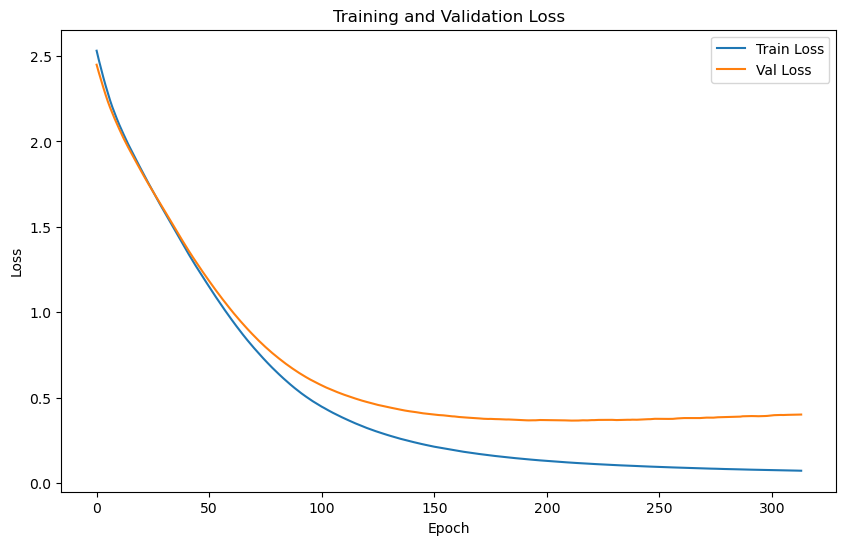

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.1250 | Test Accuracy: 96.40%


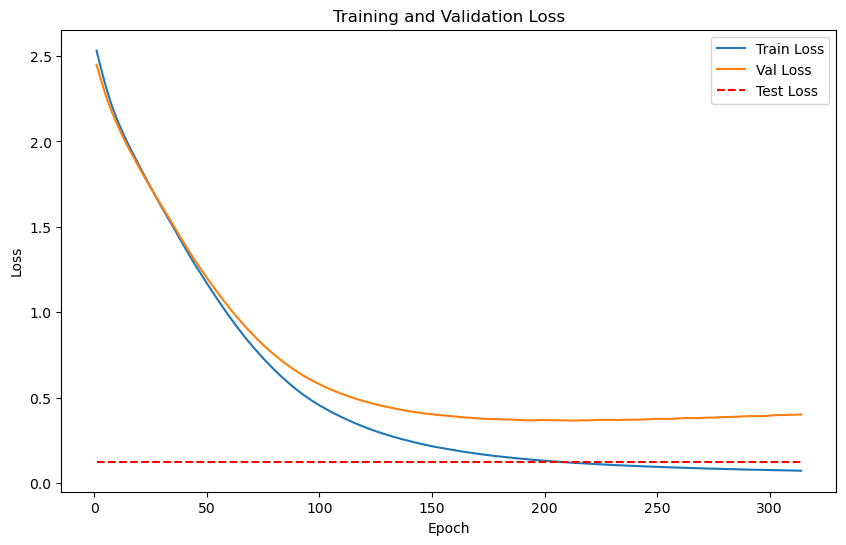

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3636
Epoch [1/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3636

Validation loss improved from inf to 0.3636. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [2/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.3655
Epoch [3/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.3655

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [4/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3655

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.3655
Epoch [5/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3655

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3655
Epoch [6/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3655

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.3656
Epoch [7/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3656

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3654
Epoch [8/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3654

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3646
Epoch [9/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3646

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [10/2000] - Validation


    Batch [1/1], Val Loss: 0.3637
Epoch [10/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3637

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [11/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3629

Validation loss improved from 0.3636 to 0.3629. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [12/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.3619

Validation loss improved from 0.3629 to 0.3619. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3608
Epoch [13/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3608

Validation loss improved from 0.3619 to 0.3608. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.3598
Epoch [14/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.3598

Validation loss improved from 0.3608 to 0.3598. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [15/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3586

Validation loss improved from 0.3598 to 0.3586. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.3573
Epoch [16/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.3573

Validation loss improved from 0.3586 to 0.3573. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3562
Epoch [17/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3562

Validation loss improved from 0.3573 to 0.3562. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4310
LOG: Epoch [18/2000] - Validation


    Batch [1/1], Val Loss: 0.3552
Epoch [18/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.3552

Validation loss improved from 0.3562 to 0.3552. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [19/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.3543

Validation loss improved from 0.3552 to 0.3543. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [20/2000] - Validation


    Batch [1/1], Val Loss: 0.3536
Epoch [20/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.3536

Validation loss improved from 0.3543 to 0.3536. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3528
Epoch [21/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.3528

Validation loss improved from 0.3536 to 0.3528. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3520
Epoch [22/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.3520

Validation loss improved from 0.3528 to 0.3520. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [23/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3513

Validation loss improved from 0.3520 to 0.3513. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [24/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.3505

Validation loss improved from 0.3513 to 0.3505. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.3496
Epoch [25/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3496

Validation loss improved from 0.3505 to 0.3496. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3488
Epoch [26/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.3488

Validation loss improved from 0.3496 to 0.3488. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.3479
Epoch [27/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3479

Validation loss improved from 0.3488 to 0.3479. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [28/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.3471

Validation loss improved from 0.3479 to 0.3471. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [29/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3462

Validation loss improved from 0.3471 to 0.3462. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3454
Epoch [30/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.3454

Validation loss improved from 0.3462 to 0.3454. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3445
Epoch [31/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3445

Validation loss improved from 0.3454 to 0.3445. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [32/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3437

Validation loss improved from 0.3445 to 0.3437. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3429
Epoch [33/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.3429

Validation loss improved from 0.3437 to 0.3429. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [34/2000] - Validation


    Batch [1/1], Val Loss: 0.3421
Epoch [34/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.3421

Validation loss improved from 0.3429 to 0.3421. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [35/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.3412

Validation loss improved from 0.3421 to 0.3412. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [36/2000] - Validation


    Batch [1/1], Val Loss: 0.3405
Epoch [36/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.3405

Validation loss improved from 0.3412 to 0.3405. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3398
Epoch [37/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.3398

Validation loss improved from 0.3405 to 0.3398. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [38/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3390

Validation loss improved from 0.3398 to 0.3390. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [39/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.3383

Validation loss improved from 0.3390 to 0.3383. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [40/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.3376

Validation loss improved from 0.3383 to 0.3376. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [41/2000] - Validation


    Batch [1/1], Val Loss: 0.3368
Epoch [41/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3368

Validation loss improved from 0.3376 to 0.3368. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [42/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3361

Validation loss improved from 0.3368 to 0.3361. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [43/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3355

Validation loss improved from 0.3361 to 0.3355. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [44/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3348

Validation loss improved from 0.3355 to 0.3348. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3341
Epoch [45/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3341

Validation loss improved from 0.3348 to 0.3341. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [46/2000] - Validation


    Batch [1/1], Val Loss: 0.3335
Epoch [46/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3335

Validation loss improved from 0.3341 to 0.3335. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [47/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3328

Validation loss improved from 0.3335 to 0.3328. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [48/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3321

Validation loss improved from 0.3328 to 0.3321. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3315
Epoch [49/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3315

Validation loss improved from 0.3321 to 0.3315. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [50/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3308

Validation loss improved from 0.3315 to 0.3308. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3302
Epoch [51/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3302

Validation loss improved from 0.3308 to 0.3302. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3296
Epoch [52/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3296

Validation loss improved from 0.3302 to 0.3296. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3289
Epoch [53/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3289

Validation loss improved from 0.3296 to 0.3289. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [54/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3283

Validation loss improved from 0.3289 to 0.3283. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3277
Epoch [55/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3277

Validation loss improved from 0.3283 to 0.3277. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [56/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3272

Validation loss improved from 0.3277 to 0.3272. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [57/2000] - Validation


    Batch [1/1], Val Loss: 0.3266
Epoch [57/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3266

Validation loss improved from 0.3272 to 0.3266. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [58/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3260

Validation loss improved from 0.3266 to 0.3260. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [59/2000] - Validation


    Batch [1/1], Val Loss: 0.3255
Epoch [59/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3255

Validation loss improved from 0.3260 to 0.3255. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [60/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3249

Validation loss improved from 0.3255 to 0.3249. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [61/2000] - Validation


    Batch [1/1], Val Loss: 0.3244
Epoch [61/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3244

Validation loss improved from 0.3249 to 0.3244. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [62/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3238

Validation loss improved from 0.3244 to 0.3238. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [63/2000] - Validation


    Batch [1/1], Val Loss: 0.3234
Epoch [63/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3234

Validation loss improved from 0.3238 to 0.3234. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3229
Epoch [64/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3229

Validation loss improved from 0.3234 to 0.3229. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3223
Epoch [65/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.3223

Validation loss improved from 0.3229 to 0.3223. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3218
Epoch [66/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3218

Validation loss improved from 0.3223 to 0.3218. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3213
Epoch [67/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3213

Validation loss improved from 0.3218 to 0.3213. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3208
Epoch [68/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.3208

Validation loss improved from 0.3213 to 0.3208. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [69/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3203

Validation loss improved from 0.3208 to 0.3203. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.3198
Epoch [70/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3198

Validation loss improved from 0.3203 to 0.3198. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [71/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.3193

Validation loss improved from 0.3198 to 0.3193. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [72/2000] - Validation


    Batch [1/1], Val Loss: 0.3188
Epoch [72/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.3188

Validation loss improved from 0.3193 to 0.3188. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3183
Epoch [73/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.3183

Validation loss improved from 0.3188 to 0.3183. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3178
Epoch [74/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3178

Validation loss improved from 0.3183 to 0.3178. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [75/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.3173

Validation loss improved from 0.3178 to 0.3173. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [76/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.3168

Validation loss improved from 0.3173 to 0.3168. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3163
Epoch [77/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.3163

Validation loss improved from 0.3168 to 0.3163. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [78/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.3159

Validation loss improved from 0.3163 to 0.3159. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3154
Epoch [79/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.3154

Validation loss improved from 0.3159 to 0.3154. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [80/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.3149

Validation loss improved from 0.3154 to 0.3149. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3145
Epoch [81/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.3145

Validation loss improved from 0.3149 to 0.3145. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [82/2000] - Validation


    Batch [1/1], Val Loss: 0.3140
Epoch [82/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3140

Validation loss improved from 0.3145 to 0.3140. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [83/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.3136

Validation loss improved from 0.3140 to 0.3136. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3131
Epoch [84/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3131

Validation loss improved from 0.3136 to 0.3131. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3126
Epoch [85/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3126

Validation loss improved from 0.3131 to 0.3126. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [86/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3122

Validation loss improved from 0.3126 to 0.3122. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3117
Epoch [87/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.3117

Validation loss improved from 0.3122 to 0.3117. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [88/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3112

Validation loss improved from 0.3117 to 0.3112. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [89/2000] - Validation


    Batch [1/1], Val Loss: 0.3108
Epoch [89/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3108

Validation loss improved from 0.3112 to 0.3108. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3103
Epoch [90/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.3103

Validation loss improved from 0.3108 to 0.3103. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [91/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3099

Validation loss improved from 0.3103 to 0.3099. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3094
Epoch [92/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3094

Validation loss improved from 0.3099 to 0.3094. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [93/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3090

Validation loss improved from 0.3094 to 0.3090. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3085
Epoch [94/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.3085

Validation loss improved from 0.3090 to 0.3085. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [95/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.3081

Validation loss improved from 0.3085 to 0.3081. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [96/2000] - Validation


    Batch [1/1], Val Loss: 0.3077
Epoch [96/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3077

Validation loss improved from 0.3081 to 0.3077. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [97/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.3072

Validation loss improved from 0.3077 to 0.3072. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [98/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.3068

Validation loss improved from 0.3072 to 0.3068. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [99/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.3064

Validation loss improved from 0.3068 to 0.3064. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [100/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.3059

Validation loss improved from 0.3064 to 0.3059. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.3055
Epoch [101/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.3055

Validation loss improved from 0.3059 to 0.3055. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [102/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.3051

Validation loss improved from 0.3055 to 0.3051. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [103/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3047

Validation loss improved from 0.3051 to 0.3047. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [104/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.3042

Validation loss improved from 0.3047 to 0.3042. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [105/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3038

Validation loss improved from 0.3042 to 0.3038. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [106/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3035

Validation loss improved from 0.3038 to 0.3035. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3031
Epoch [107/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.3031

Validation loss improved from 0.3035 to 0.3031. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [108/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3027

Validation loss improved from 0.3031 to 0.3027. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [109/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.3023

Validation loss improved from 0.3027 to 0.3023. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [110/2000] - Validation


    Batch [1/1], Val Loss: 0.3019
Epoch [110/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.3019

Validation loss improved from 0.3023 to 0.3019. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [111/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.3015

Validation loss improved from 0.3019 to 0.3015. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [112/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.3011

Validation loss improved from 0.3015 to 0.3011. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [113/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3006

Validation loss improved from 0.3011 to 0.3006. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3002
Epoch [114/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3002

Validation loss improved from 0.3006 to 0.3002. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.2998
Epoch [115/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2998

Validation loss improved from 0.3002 to 0.2998. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [116/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2993

Validation loss improved from 0.2998 to 0.2993. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [117/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2989

Validation loss improved from 0.2993 to 0.2989. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.2985
Epoch [118/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2985

Validation loss improved from 0.2989 to 0.2985. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.2981
Epoch [119/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2981

Validation loss improved from 0.2985 to 0.2981. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [120/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2976

Validation loss improved from 0.2981 to 0.2976. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.2972
Epoch [121/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2972

Validation loss improved from 0.2976 to 0.2972. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [122/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2969

Validation loss improved from 0.2972 to 0.2969. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [123/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.2965

Validation loss improved from 0.2969 to 0.2965. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.2962
Epoch [124/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2962

Validation loss improved from 0.2965 to 0.2962. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.2958
Epoch [125/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.2958

Validation loss improved from 0.2962 to 0.2958. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [126/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2955

Validation loss improved from 0.2958 to 0.2955. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.2952
Epoch [127/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2952

Validation loss improved from 0.2955 to 0.2952. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3365
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.2949
Epoch [128/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.2949

Validation loss improved from 0.2952 to 0.2949. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.2946
Epoch [129/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2946

Validation loss improved from 0.2949 to 0.2946. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [130/2000] - Validation


    Batch [1/1], Val Loss: 0.2943
Epoch [130/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.2943

Validation loss improved from 0.2946 to 0.2943. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.2940
Epoch [131/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.2940

Validation loss improved from 0.2943 to 0.2940. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.2937
Epoch [132/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2937

Validation loss improved from 0.2940 to 0.2937. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.2934
Epoch [133/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2934

Validation loss improved from 0.2937 to 0.2934. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [134/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2931

Validation loss improved from 0.2934 to 0.2931. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.2928
Epoch [135/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.2928

Validation loss improved from 0.2931 to 0.2928. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [136/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.2925

Validation loss improved from 0.2928 to 0.2925. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [137/2000] - Validation


    Batch [1/1], Val Loss: 0.2922
Epoch [137/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.2922

Validation loss improved from 0.2925 to 0.2922. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2919
Epoch [138/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2919

Validation loss improved from 0.2922 to 0.2919. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [139/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.2916

Validation loss improved from 0.2919 to 0.2916. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2912
Epoch [140/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2912

Validation loss improved from 0.2916 to 0.2912. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [141/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2909

Validation loss improved from 0.2912 to 0.2909. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [142/2000] - Validation


    Batch [1/1], Val Loss: 0.2906
Epoch [142/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2906

Validation loss improved from 0.2909 to 0.2906. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.2903
Epoch [143/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2903

Validation loss improved from 0.2906 to 0.2903. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2899
Epoch [144/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2899

Validation loss improved from 0.2903 to 0.2899. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [145/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.2896

Validation loss improved from 0.2899 to 0.2896. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [146/2000] - Validation


    Batch [1/1], Val Loss: 0.2893
Epoch [146/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2893

Validation loss improved from 0.2896 to 0.2893. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [147/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.2890

Validation loss improved from 0.2893 to 0.2890. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [148/2000] - Validation


    Batch [1/1], Val Loss: 0.2888
Epoch [148/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2888

Validation loss improved from 0.2890 to 0.2888. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [149/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2884

Validation loss improved from 0.2888 to 0.2884. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [150/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2881

Validation loss improved from 0.2884 to 0.2881. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [151/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2878

Validation loss improved from 0.2881 to 0.2878. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.2876
Epoch [152/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.2876

Validation loss improved from 0.2878 to 0.2876. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [153/2000] - Validation


    Batch [1/1], Val Loss: 0.2873
Epoch [153/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.2873

Validation loss improved from 0.2876 to 0.2873. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.2870
Epoch [154/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.2870

Validation loss improved from 0.2873 to 0.2870. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.2867
Epoch [155/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2867

Validation loss improved from 0.2870 to 0.2867. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3157
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.2864
Epoch [156/2000], Avg Train Loss: 0.3157, Avg Val Loss: 0.2864

Validation loss improved from 0.2867 to 0.2864. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2861
Epoch [157/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2861

Validation loss improved from 0.2864 to 0.2861. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [158/2000] - Validation


    Batch [1/1], Val Loss: 0.2859
Epoch [158/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2859

Validation loss improved from 0.2861 to 0.2859. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.2856
Epoch [159/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.2856

Validation loss improved from 0.2859 to 0.2856. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.2853
Epoch [160/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.2853

Validation loss improved from 0.2856 to 0.2853. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3093
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.2851
Epoch [161/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.2851

Validation loss improved from 0.2853 to 0.2851. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.2848
Epoch [162/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2848

Validation loss improved from 0.2851 to 0.2848. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2845
Epoch [163/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2845

Validation loss improved from 0.2848 to 0.2845. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3076
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2843
Epoch [164/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.2843

Validation loss improved from 0.2845 to 0.2843. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3104
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.2841
Epoch [165/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2841

Validation loss improved from 0.2843 to 0.2841. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.2838
Epoch [166/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.2838

Validation loss improved from 0.2841 to 0.2838. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.2836
Epoch [167/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2836

Validation loss improved from 0.2838 to 0.2836. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.2833
Epoch [168/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.2833

Validation loss improved from 0.2836 to 0.2833. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3008
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.2831
Epoch [169/2000], Avg Train Loss: 0.3008, Avg Val Loss: 0.2831

Validation loss improved from 0.2833 to 0.2831. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.2829
Epoch [170/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.2829

Validation loss improved from 0.2831 to 0.2829. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [171/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.2826

Validation loss improved from 0.2829 to 0.2826. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [172/2000] - Validation


    Batch [1/1], Val Loss: 0.2824
Epoch [172/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.2824

Validation loss improved from 0.2826 to 0.2824. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2822
Epoch [173/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.2822

Validation loss improved from 0.2824 to 0.2822. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3031
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.2820
Epoch [174/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.2820

Validation loss improved from 0.2822 to 0.2820. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.2818
Epoch [175/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.2818

Validation loss improved from 0.2820 to 0.2818. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3049
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.2816
Epoch [176/2000], Avg Train Loss: 0.3049, Avg Val Loss: 0.2816

Validation loss improved from 0.2818 to 0.2816. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2815
Epoch [177/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.2815

Validation loss improved from 0.2816 to 0.2815. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.2813
Epoch [178/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.2813

Validation loss improved from 0.2815 to 0.2813. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.2811
Epoch [179/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.2811

Validation loss improved from 0.2813 to 0.2811. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2809
Epoch [180/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2809

Validation loss improved from 0.2811 to 0.2809. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.2808
Epoch [181/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.2808

Validation loss improved from 0.2809 to 0.2808. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2806
Epoch [182/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.2806

Validation loss improved from 0.2808 to 0.2806. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3051
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.2804
Epoch [183/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.2804

Validation loss improved from 0.2806 to 0.2804. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3007
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2803
Epoch [184/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.2803

Validation loss improved from 0.2804 to 0.2803. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.2801
Epoch [185/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2801

Validation loss improved from 0.2803 to 0.2801. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2799
Epoch [186/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.2799

Validation loss improved from 0.2801 to 0.2799. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [187/2000] - Validation


    Batch [1/1], Val Loss: 0.2798
Epoch [187/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2798

Validation loss improved from 0.2799 to 0.2798. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2796
Epoch [188/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2796

Validation loss improved from 0.2798 to 0.2796. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2795
Epoch [189/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2795

Validation loss improved from 0.2796 to 0.2795. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.2793
Epoch [190/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2793

Validation loss improved from 0.2795 to 0.2793. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2791
Epoch [191/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.2791

Validation loss improved from 0.2793 to 0.2791. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.2789
Epoch [192/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.2789

Validation loss improved from 0.2791 to 0.2789. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2788
Epoch [193/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.2788

Validation loss improved from 0.2789 to 0.2788. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.2786
Epoch [194/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.2786

Validation loss improved from 0.2788 to 0.2786. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2940
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2784
Epoch [195/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.2784

Validation loss improved from 0.2786 to 0.2784. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [196/2000] - Validation


    Batch [1/1], Val Loss: 0.2782
Epoch [196/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2782

Validation loss improved from 0.2784 to 0.2782. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2780
Epoch [197/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.2780

Validation loss improved from 0.2782 to 0.2780. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [198/2000] - Validation


    Batch [1/1], Val Loss: 0.2778
Epoch [198/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.2778

Validation loss improved from 0.2780 to 0.2778. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.2776
Epoch [199/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.2776

Validation loss improved from 0.2778 to 0.2776. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [200/2000] - Validation


    Batch [1/1], Val Loss: 0.2774
Epoch [200/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2774

Validation loss improved from 0.2776 to 0.2774. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2772
Epoch [201/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2772

Validation loss improved from 0.2774 to 0.2772. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2928
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2770
Epoch [202/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.2770

Validation loss improved from 0.2772 to 0.2770. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.2919
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2768
Epoch [203/2000], Avg Train Loss: 0.2919, Avg Val Loss: 0.2768

Validation loss improved from 0.2770 to 0.2768. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2766
Epoch [204/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.2766

Validation loss improved from 0.2768 to 0.2766. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [205/2000] - Validation


    Batch [1/1], Val Loss: 0.2765
Epoch [205/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.2765

Validation loss improved from 0.2766 to 0.2765. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2763
Epoch [206/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2763

Validation loss improved from 0.2765 to 0.2763. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.2761
Epoch [207/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2761

Validation loss improved from 0.2763 to 0.2761. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2759
Epoch [208/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2759

Validation loss improved from 0.2761 to 0.2759. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2757
Epoch [209/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2757

Validation loss improved from 0.2759 to 0.2757. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2755
Epoch [210/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.2755

Validation loss improved from 0.2757 to 0.2755. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2753
Epoch [211/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2753

Validation loss improved from 0.2755 to 0.2753. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2751
Epoch [212/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2751

Validation loss improved from 0.2753 to 0.2751. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.2749
Epoch [213/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2749

Validation loss improved from 0.2751 to 0.2749. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.2747
Epoch [214/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2747

Validation loss improved from 0.2749 to 0.2747. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.2745
Epoch [215/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.2745

Validation loss improved from 0.2747 to 0.2745. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.2743
Epoch [216/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.2743

Validation loss improved from 0.2745 to 0.2743. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2742
Epoch [217/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.2742

Validation loss improved from 0.2743 to 0.2742. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2740
Epoch [218/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2740

Validation loss improved from 0.2742 to 0.2740. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.2738
Epoch [219/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2737
Epoch [220/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2737

Validation loss improved from 0.2738 to 0.2737. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [221/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2736

Validation loss improved from 0.2737 to 0.2736. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [222/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2734

Validation loss improved from 0.2736 to 0.2734. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [223/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2733

Validation loss improved from 0.2734 to 0.2733. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [224/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2732

Validation loss improved from 0.2733 to 0.2732. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [225/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2730

Validation loss improved from 0.2732 to 0.2730. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [226/2000] - Validation


    Batch [1/1], Val Loss: 0.2729
Epoch [226/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.2729

Validation loss improved from 0.2730 to 0.2729. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [227/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2728

Validation loss improved from 0.2729 to 0.2728. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.2727
Epoch [228/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2727

Validation loss improved from 0.2728 to 0.2727. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [229/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2726

Validation loss improved from 0.2727 to 0.2726. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2725
Epoch [230/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2725

Validation loss improved from 0.2726 to 0.2725. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2724
Epoch [231/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2724

Validation loss improved from 0.2725 to 0.2724. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [232/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2723

Validation loss improved from 0.2724 to 0.2723. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [233/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2723

Validation loss improved from 0.2723 to 0.2723. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [234/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2722

Validation loss improved from 0.2723 to 0.2722. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [235/2000] - Validation


    Batch [1/1], Val Loss: 0.2721
Epoch [235/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.2721

Validation loss improved from 0.2722 to 0.2721. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2721
Epoch [236/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.2721

Validation loss improved from 0.2721 to 0.2721. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [237/2000] - Validation


    Batch [1/1], Val Loss: 0.2720
Epoch [237/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.2720

Validation loss improved from 0.2721 to 0.2720. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2719
Epoch [238/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2718
Epoch [239/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2718

Validation loss improved from 0.2719 to 0.2718. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [240/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2717

Validation loss improved from 0.2718 to 0.2717. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.2716
Epoch [241/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2716

Validation loss improved from 0.2717 to 0.2716. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2715
Epoch [242/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2715

Validation loss improved from 0.2716 to 0.2715. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.2715
Epoch [243/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2715

Validation loss improved from 0.2715 to 0.2715. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2714
Epoch [244/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.2713
Epoch [245/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2713

Validation loss improved from 0.2714 to 0.2713. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2713
Epoch [246/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.2712
Epoch [247/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2712

Validation loss improved from 0.2713 to 0.2712. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2711
Epoch [248/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2710
Epoch [249/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2710

Validation loss improved from 0.2711 to 0.2710. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [250/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2709

Validation loss improved from 0.2710 to 0.2709. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [251/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.2708

Validation loss improved from 0.2709 to 0.2708. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2707
Epoch [252/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2707

Validation loss improved from 0.2708 to 0.2707. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [253/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2706

Validation loss improved from 0.2707 to 0.2706. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.2705
Epoch [254/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2705

Validation loss improved from 0.2706 to 0.2705. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.2704
Epoch [255/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2704

Validation loss improved from 0.2705 to 0.2704. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.2703
Epoch [256/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2703

Validation loss improved from 0.2704 to 0.2703. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2702
Epoch [257/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2702

Validation loss improved from 0.2703 to 0.2702. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.2548
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.2701
Epoch [258/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.2701

Validation loss improved from 0.2702 to 0.2701. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2700
Epoch [259/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.2700

Validation loss improved from 0.2701 to 0.2700. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.2588
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.2700
Epoch [260/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.2700

Validation loss improved from 0.2700 to 0.2700. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2699
Epoch [261/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2699

Validation loss improved from 0.2700 to 0.2699. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [262/2000] - Validation


    Batch [1/1], Val Loss: 0.2698
Epoch [262/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2698

Validation loss improved from 0.2699 to 0.2698. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2697
Epoch [263/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2697

Validation loss improved from 0.2698 to 0.2697. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.2697
Epoch [264/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2697

Validation loss improved from 0.2697 to 0.2697. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2696
Epoch [265/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2696

Validation loss improved from 0.2697 to 0.2696. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2696
Epoch [266/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.2696

Validation loss improved from 0.2696 to 0.2696. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2562
LOG: Epoch [267/2000] - Validation


    Batch [1/1], Val Loss: 0.2695
Epoch [267/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.2695

Validation loss improved from 0.2696 to 0.2695. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2695
Epoch [268/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2695

Validation loss improved from 0.2695 to 0.2695. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.2694
Epoch [269/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.2694

Validation loss improved from 0.2695 to 0.2694. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2694
Epoch [270/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2694

Validation loss improved from 0.2694 to 0.2694. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2693
Epoch [271/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2693

Validation loss improved from 0.2694 to 0.2693. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2692
Epoch [272/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.2692

Validation loss improved from 0.2693 to 0.2692. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2602
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2692
Epoch [273/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.2692

Validation loss improved from 0.2692 to 0.2692. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.2588
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2691
Epoch [274/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.2691

Validation loss improved from 0.2692 to 0.2691. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2690
Epoch [275/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2690

Validation loss improved from 0.2691 to 0.2690. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.2690
Epoch [276/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.2690

Validation loss improved from 0.2690 to 0.2690. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2689
Epoch [277/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2689

Validation loss improved from 0.2690 to 0.2689. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2550
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2688
Epoch [278/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.2688

Validation loss improved from 0.2689 to 0.2688. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2687
Epoch [279/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2687

Validation loss improved from 0.2688 to 0.2687. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2528
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.2686
Epoch [280/2000], Avg Train Loss: 0.2528, Avg Val Loss: 0.2686

Validation loss improved from 0.2687 to 0.2686. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2686
Epoch [281/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.2686

Validation loss improved from 0.2686 to 0.2686. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2684
Epoch [282/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.2684

Validation loss improved from 0.2686 to 0.2684. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2683
Epoch [283/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.2683

Validation loss improved from 0.2684 to 0.2683. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2682
Epoch [284/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.2682

Validation loss improved from 0.2683 to 0.2682. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.2681
Epoch [285/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.2681

Validation loss improved from 0.2682 to 0.2681. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [286/2000] - Validation


    Batch [1/1], Val Loss: 0.2680
Epoch [286/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.2680

Validation loss improved from 0.2681 to 0.2680. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2484
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.2679
Epoch [287/2000], Avg Train Loss: 0.2484, Avg Val Loss: 0.2679

Validation loss improved from 0.2680 to 0.2679. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2677
Epoch [288/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2677

Validation loss improved from 0.2679 to 0.2677. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2676
Epoch [289/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.2676

Validation loss improved from 0.2677 to 0.2676. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2675
Epoch [290/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.2675

Validation loss improved from 0.2676 to 0.2675. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [291/2000] - Validation


    Batch [1/1], Val Loss: 0.2674
Epoch [291/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.2674

Validation loss improved from 0.2675 to 0.2674. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2673
Epoch [292/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.2673

Validation loss improved from 0.2674 to 0.2673. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2673
Epoch [293/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.2673

Validation loss improved from 0.2673 to 0.2673. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2672
Epoch [294/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.2672

Validation loss improved from 0.2673 to 0.2672. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2672
Epoch [295/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2672

Validation loss improved from 0.2672 to 0.2672. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2671
Epoch [296/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.2671

Validation loss improved from 0.2672 to 0.2671. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.2670
Epoch [297/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.2670

Validation loss improved from 0.2671 to 0.2670. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.2669
Epoch [298/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.2669

Validation loss improved from 0.2670 to 0.2669. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2668
Epoch [299/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.2668

Validation loss improved from 0.2669 to 0.2668. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2667
Epoch [300/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.2667

Validation loss improved from 0.2668 to 0.2667. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2666
Epoch [301/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.2666

Validation loss improved from 0.2667 to 0.2666. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2666
Epoch [302/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [303/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.2665

Validation loss improved from 0.2666 to 0.2665. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2664
Epoch [304/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2664

Validation loss improved from 0.2665 to 0.2664. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.2663
Epoch [305/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.2663

Validation loss improved from 0.2664 to 0.2663. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2662
Epoch [306/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.2662

Validation loss improved from 0.2663 to 0.2662. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.2662
Epoch [307/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.2662

Validation loss improved from 0.2662 to 0.2662. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2414
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2661
Epoch [308/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.2661

Validation loss improved from 0.2662 to 0.2661. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.2661
Epoch [309/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.2661

Validation loss improved from 0.2661 to 0.2661. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.2660
Epoch [310/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.2660

Validation loss improved from 0.2661 to 0.2660. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2401
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2660
Epoch [311/2000], Avg Train Loss: 0.2401, Avg Val Loss: 0.2660

Validation loss improved from 0.2660 to 0.2660. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2659
Epoch [312/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.2659

Validation loss improved from 0.2660 to 0.2659. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2659
Epoch [313/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.2659

Validation loss improved from 0.2659 to 0.2659. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.2658
Epoch [314/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2658

Validation loss improved from 0.2659 to 0.2658. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2658
Epoch [315/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.2658

Validation loss improved from 0.2658 to 0.2658. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.2657
Epoch [316/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2657

Validation loss improved from 0.2658 to 0.2657. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.2656
Epoch [317/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2656

Validation loss improved from 0.2657 to 0.2656. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.2655
Epoch [318/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2655

Validation loss improved from 0.2656 to 0.2655. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [319/2000] - Validation


    Batch [1/1], Val Loss: 0.2654
Epoch [319/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.2654

Validation loss improved from 0.2655 to 0.2654. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2339
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2653
Epoch [320/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2391
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.2652
Epoch [321/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.2652

Validation loss improved from 0.2653 to 0.2652. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2651
Epoch [322/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.2651

Validation loss improved from 0.2652 to 0.2651. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2361
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2650
Epoch [323/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2649
Epoch [324/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.2649
Epoch [325/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.2649

Validation loss improved from 0.2649 to 0.2649. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.2648
Epoch [326/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2388
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.2647
Epoch [327/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2646
Epoch [328/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.2646

Validation loss improved from 0.2647 to 0.2646. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.2646
Epoch [329/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.2646

Validation loss improved from 0.2646 to 0.2646. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2646
Epoch [330/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2646

Validation loss improved from 0.2646 to 0.2646. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2645
Epoch [331/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.2645

Validation loss improved from 0.2646 to 0.2645. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2645
Epoch [332/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.2645

Validation loss improved from 0.2645 to 0.2645. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.2645
Epoch [333/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.2645

Validation loss improved from 0.2645 to 0.2645. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2371
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2644
Epoch [334/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.2644

Validation loss improved from 0.2645 to 0.2644. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.2644
Epoch [335/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.2644

Validation loss improved from 0.2644 to 0.2644. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [336/2000] - Validation


    Batch [1/1], Val Loss: 0.2643
Epoch [336/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [337/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.2642

Validation loss improved from 0.2643 to 0.2642. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [338/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.2642

Validation loss improved from 0.2642 to 0.2642. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2345
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2641
Epoch [339/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2640
Epoch [340/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.2640

Validation loss improved from 0.2641 to 0.2640. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [341/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.2639

Validation loss improved from 0.2640 to 0.2639. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [342/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [343/2000] - Validation


    Batch [1/1], Val Loss: 0.2637
Epoch [343/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.2636
Epoch [344/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.2636

Validation loss improved from 0.2637 to 0.2636. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [345/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.2635

Validation loss improved from 0.2636 to 0.2635. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2634
Epoch [346/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2633
Epoch [347/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.2633

Validation loss improved from 0.2634 to 0.2633. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [348/2000] - Validation


    Batch [1/1], Val Loss: 0.2632
Epoch [348/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.2632

Validation loss improved from 0.2633 to 0.2632. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2632
Epoch [349/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.2631
Epoch [350/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.2631

Validation loss improved from 0.2632 to 0.2631. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.2630
Epoch [351/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.2630

Validation loss improved from 0.2631 to 0.2630. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.2630
Epoch [352/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.2630

Validation loss improved from 0.2630 to 0.2630. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2290
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2629
Epoch [353/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.2629
Epoch [354/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.2629

Validation loss improved from 0.2629 to 0.2629. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2628
Epoch [355/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.2628

Validation loss improved from 0.2629 to 0.2628. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [356/2000] - Validation


    Batch [1/1], Val Loss: 0.2628
Epoch [356/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.2628

Validation loss improved from 0.2628 to 0.2628. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2242
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2627
Epoch [357/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.2627

Validation loss improved from 0.2628 to 0.2627. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2261
LOG: Epoch [358/2000] - Validation


    Batch [1/1], Val Loss: 0.2626
Epoch [358/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2626
Epoch [359/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.2626

Validation loss improved from 0.2626 to 0.2626. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.2625
Epoch [360/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.2625

Validation loss improved from 0.2626 to 0.2625. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2624
Epoch [361/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [362/2000] - Validation


    Batch [1/1], Val Loss: 0.2623
Epoch [362/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2623

Validation loss improved from 0.2624 to 0.2623. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2622
Epoch [363/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.2622

Validation loss improved from 0.2623 to 0.2622. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2621
Epoch [364/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.2621

Validation loss improved from 0.2622 to 0.2621. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2620
Epoch [365/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.2620

Validation loss improved from 0.2621 to 0.2620. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2209
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.2620
Epoch [366/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.2620

Validation loss improved from 0.2620 to 0.2620. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [367/2000] - Validation


    Batch [1/1], Val Loss: 0.2618
Epoch [367/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.2618

Validation loss improved from 0.2620 to 0.2618. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2618
Epoch [368/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2618

Validation loss improved from 0.2618 to 0.2618. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2200
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2617
Epoch [369/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.2616
Epoch [370/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.2616

Validation loss improved from 0.2617 to 0.2616. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2290
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.2615
Epoch [371/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.2615

Validation loss improved from 0.2616 to 0.2615. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2614
Epoch [372/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2614
Epoch [373/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.2614

Validation loss improved from 0.2614 to 0.2614. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.2613
Epoch [374/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2612
Epoch [375/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.2612

Validation loss improved from 0.2613 to 0.2612. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2612
Epoch [376/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2612

Validation loss improved from 0.2612 to 0.2612. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [377/2000] - Validation


    Batch [1/1], Val Loss: 0.2611
Epoch [377/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.2611

Validation loss improved from 0.2612 to 0.2611. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2611
Epoch [378/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.2611

Validation loss improved from 0.2611 to 0.2611. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2611
Epoch [379/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2611

Validation loss improved from 0.2611 to 0.2611. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2611
Epoch [380/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.2611

Validation loss improved from 0.2611 to 0.2611. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2212
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2611
Epoch [381/2000], Avg Train Loss: 0.2212, Avg Val Loss: 0.2611

Validation loss improved from 0.2611 to 0.2611. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.2610
Epoch [382/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.2610

Validation loss improved from 0.2611 to 0.2610. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2609
Epoch [383/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2609

Validation loss improved from 0.2610 to 0.2609. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.2609
Epoch [384/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.2609

Validation loss improved from 0.2609 to 0.2609. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [385/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.2608

Validation loss improved from 0.2609 to 0.2608. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2607
Epoch [386/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.2607
Epoch [387/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2607

Validation loss improved from 0.2607 to 0.2607. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2606
Epoch [388/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.2606

Validation loss improved from 0.2607 to 0.2606. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.2606
Epoch [389/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.2606

Validation loss improved from 0.2606 to 0.2606. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2605
Epoch [390/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.2605

Validation loss improved from 0.2606 to 0.2605. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2604
Epoch [391/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2603
Epoch [392/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.2603

Validation loss improved from 0.2604 to 0.2603. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2602
Epoch [393/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2602
Epoch [394/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2601
Epoch [395/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2156
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2600
Epoch [396/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.2600

Validation loss improved from 0.2601 to 0.2600. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2600
Epoch [397/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.2600

Validation loss improved from 0.2600 to 0.2600. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2095
LOG: Epoch [398/2000] - Validation


    Batch [1/1], Val Loss: 0.2599
Epoch [398/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.2599

Validation loss improved from 0.2600 to 0.2599. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.2598
Epoch [399/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.2598

Validation loss improved from 0.2599 to 0.2598. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [400/2000] - Validation


    Batch [1/1], Val Loss: 0.2597
Epoch [400/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2596
Epoch [401/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.2595
Epoch [402/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.2594
Epoch [403/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.2594

Validation loss improved from 0.2595 to 0.2594. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.2593
Epoch [404/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.2593

Validation loss improved from 0.2594 to 0.2593. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [405/2000] - Validation


    Batch [1/1], Val Loss: 0.2592
Epoch [405/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.2592

Validation loss improved from 0.2593 to 0.2592. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2133
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.2591
Epoch [406/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.2591

Validation loss improved from 0.2592 to 0.2591. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2590
Epoch [407/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.2589
Epoch [408/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2588
Epoch [409/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2111
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2587
Epoch [410/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [411/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [412/2000] - Validation


    Batch [1/1], Val Loss: 0.2586
Epoch [412/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.2585
Epoch [413/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [414/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.2584

Validation loss improved from 0.2585 to 0.2584. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [415/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.2584

Validation loss improved from 0.2584 to 0.2584. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2583
Epoch [416/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [417/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [418/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [419/2000] - Validation


    Batch [1/1], Val Loss: 0.2581
Epoch [419/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2580
Epoch [420/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2580
Epoch [421/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2579
Epoch [422/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2578
Epoch [423/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2577
Epoch [424/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [425/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.2575
Epoch [426/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2574
Epoch [427/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [428/2000] - Validation


    Batch [1/1], Val Loss: 0.2573
Epoch [428/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2572
Epoch [429/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2572
Epoch [430/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.2572

Validation loss improved from 0.2572 to 0.2572. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.2571
Epoch [431/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.2571
Epoch [432/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.2571

Validation loss improved from 0.2571 to 0.2571. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.2570
Epoch [433/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [434/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [435/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [436/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.2568

Validation loss improved from 0.2568 to 0.2568. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [437/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [438/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [439/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.2566

Validation loss improved from 0.2566 to 0.2566. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [440/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [441/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [442/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2563
Epoch [443/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2563
Epoch [444/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2562
Epoch [445/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.2562

Validation loss improved from 0.2563 to 0.2562. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2005
LOG: Epoch [446/2000] - Validation


    Batch [1/1], Val Loss: 0.2561
Epoch [446/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.2561

Validation loss improved from 0.2562 to 0.2561. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.1975
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2560
Epoch [447/2000], Avg Train Loss: 0.1975, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2560
Epoch [448/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.1936
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2559
Epoch [449/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.2559

Validation loss improved from 0.2560 to 0.2559. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [450/2000] - Validation


    Batch [1/1], Val Loss: 0.2558
Epoch [450/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2558

Validation loss improved from 0.2559 to 0.2558. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2557
Epoch [451/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2557
Epoch [452/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.2557

Validation loss improved from 0.2557 to 0.2557. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2556
Epoch [453/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2555
Epoch [454/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2554
Epoch [455/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.2554

Validation loss improved from 0.2555 to 0.2554. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [456/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.2553

Validation loss improved from 0.2554 to 0.2553. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [457/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2552
Epoch [458/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.2551
Epoch [459/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2551
Epoch [460/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [461/2000] - Validation


    Batch [1/1], Val Loss: 0.2551
Epoch [461/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2550
Epoch [462/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [463/2000] - Validation


    Batch [1/1], Val Loss: 0.2550
Epoch [463/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [464/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [465/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [466/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [467/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [468/2000] - Validation


    Batch [1/1], Val Loss: 0.2548
Epoch [468/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [469/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [470/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [471/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [472/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2544
Epoch [473/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2544
Epoch [474/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [475/2000] - Validation


    Batch [1/1], Val Loss: 0.2544
Epoch [475/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.2544
Epoch [476/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [477/2000] - Validation


    Batch [1/1], Val Loss: 0.2544
Epoch [477/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [478/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.2543
Epoch [479/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2542
Epoch [480/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [481/2000] - Validation


    Batch [1/1], Val Loss: 0.2541
Epoch [481/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2540
Epoch [482/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [483/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2538
Epoch [484/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.2538

Validation loss improved from 0.2539 to 0.2538. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.2536
Epoch [485/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.2536

Validation loss improved from 0.2538 to 0.2536. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [486/2000] - Validation


    Batch [1/1], Val Loss: 0.2535
Epoch [486/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.2534
Epoch [487/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.2534

Validation loss improved from 0.2535 to 0.2534. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.1840
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2533
Epoch [488/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.2533

Validation loss improved from 0.2534 to 0.2533. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.2532
Epoch [489/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [490/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.2531

Validation loss improved from 0.2532 to 0.2531. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.2530
Epoch [491/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2529
Epoch [492/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2528
Epoch [493/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2527
Epoch [494/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.2526
Epoch [495/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [496/2000] - Validation


    Batch [1/1], Val Loss: 0.2525
Epoch [496/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.2525

Validation loss improved from 0.2526 to 0.2525. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.1858
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [497/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.2524

Validation loss improved from 0.2525 to 0.2524. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [498/2000] - Validation


    Batch [1/1], Val Loss: 0.2523
Epoch [498/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [499/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2523

Validation loss improved from 0.2523 to 0.2523. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1869
LOG: Epoch [500/2000] - Validation


    Batch [1/1], Val Loss: 0.2522
Epoch [500/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.2522

Validation loss improved from 0.2523 to 0.2522. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [501/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.2521

Validation loss improved from 0.2522 to 0.2521. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.1829
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [502/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2520
Epoch [503/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.2520

Validation loss improved from 0.2521 to 0.2520. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [504/2000] - Validation


    Batch [1/1], Val Loss: 0.2520
Epoch [504/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2520

Validation loss improved from 0.2520 to 0.2520. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [505/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.2519

Validation loss improved from 0.2520 to 0.2519. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [506/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [507/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.1837
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [508/2000], Avg Train Loss: 0.1837, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [509/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.2519

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.2520
Epoch [510/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2520

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.1796
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.2520
Epoch [511/2000], Avg Train Loss: 0.1796, Avg Val Loss: 0.2520

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [512/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.1800
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [513/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.1750
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [514/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [515/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [516/2000] - Validation


    Batch [1/1], Val Loss: 0.2521
Epoch [516/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [517/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1789
LOG: Epoch [518/2000] - Validation


    Batch [1/1], Val Loss: 0.2521
Epoch [518/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [519/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.2521
Epoch [520/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [521/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2521

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2520
Epoch [522/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2520

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.1756
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.2520
Epoch [523/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.2520

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1829
LOG: Epoch [524/2000] - Validation


    Batch [1/1], Val Loss: 0.2519
Epoch [524/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.2519

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.1845
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [525/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [526/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [527/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2518
Epoch [528/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.2518

Validation loss improved from 0.2519 to 0.2518. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1771
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [529/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.2517

Validation loss improved from 0.2518 to 0.2517. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [530/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.2517

Validation loss improved from 0.2517 to 0.2517. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2516
Epoch [531/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.2516

Validation loss improved from 0.2517 to 0.2516. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2515
Epoch [532/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.2515

Validation loss improved from 0.2516 to 0.2515. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2515
Epoch [533/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.2515

Validation loss improved from 0.2515 to 0.2515. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [534/2000] - Validation


    Batch [1/1], Val Loss: 0.2514
Epoch [534/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2514
Epoch [535/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.2514

Validation loss improved from 0.2514 to 0.2514. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [536/2000] - Validation


    Batch [1/1], Val Loss: 0.2513
Epoch [536/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [537/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.2513

Validation loss improved from 0.2513 to 0.2513. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1757
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.2512
Epoch [538/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.2512

Validation loss improved from 0.2513 to 0.2512. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.1706
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [539/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.2511

Validation loss improved from 0.2512 to 0.2511. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [540/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.2511

Validation loss improved from 0.2511 to 0.2511. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1767
LOG: Epoch [541/2000] - Validation


    Batch [1/1], Val Loss: 0.2510
Epoch [541/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2509
Epoch [542/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2509

Validation loss improved from 0.2510 to 0.2509. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1708
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2509
Epoch [543/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.2509

Validation loss improved from 0.2509 to 0.2509. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [544/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1730
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [545/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.2508

Validation loss improved from 0.2508 to 0.2508. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [546/2000] - Validation


    Batch [1/1], Val Loss: 0.2508
Epoch [546/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2508

Validation loss improved from 0.2508 to 0.2508. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [547/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.2508

Validation loss improved from 0.2508 to 0.2508. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2507
Epoch [548/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2507

Validation loss improved from 0.2508 to 0.2507. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.2507
Epoch [549/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2507

Validation loss improved from 0.2507 to 0.2507. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2507
Epoch [550/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.2507

Validation loss improved from 0.2507 to 0.2507. Saving model...
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.1763
LOG: Epoch [551/2000] - Validation


    Batch [1/1], Val Loss: 0.2506
Epoch [551/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.2506

Validation loss improved from 0.2507 to 0.2506. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1760
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2506
Epoch [552/2000], Avg Train Loss: 0.1760, Avg Val Loss: 0.2506

Validation loss improved from 0.2506 to 0.2506. Saving model...
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.1671
LOG: Epoch [553/2000] - Validation


    Batch [1/1], Val Loss: 0.2505
Epoch [553/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.2505

Validation loss improved from 0.2506 to 0.2505. Saving model...
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1747
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [554/2000], Avg Train Loss: 0.1747, Avg Val Loss: 0.2504

Validation loss improved from 0.2505 to 0.2504. Saving model...
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [555/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.2503

Validation loss improved from 0.2504 to 0.2503. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.1741
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [556/2000], Avg Train Loss: 0.1741, Avg Val Loss: 0.2502

Validation loss improved from 0.2503 to 0.2502. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [557/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2502

Validation loss improved from 0.2502 to 0.2502. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [558/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.2501

Validation loss improved from 0.2502 to 0.2501. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [559/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.2500

Validation loss improved from 0.2501 to 0.2500. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1671
LOG: Epoch [560/2000] - Validation


    Batch [1/1], Val Loss: 0.2500
Epoch [560/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1675
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [561/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.2499

Validation loss improved from 0.2500 to 0.2499. Saving model...
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.1737
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [562/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.2499

Validation loss improved from 0.2499 to 0.2499. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [563/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.2498

Validation loss improved from 0.2499 to 0.2498. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [564/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2498

Validation loss improved from 0.2498 to 0.2498. Saving model...
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [565/2000] - Validation


    Batch [1/1], Val Loss: 0.2497
Epoch [565/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.2497

Validation loss improved from 0.2498 to 0.2497. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1684
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2497
Epoch [566/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.2497

Validation loss improved from 0.2497 to 0.2497. Saving model...
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2496
Epoch [567/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.2496

Validation loss improved from 0.2497 to 0.2496. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2496
Epoch [568/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.2496

Validation loss improved from 0.2496 to 0.2496. Saving model...
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.1706
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2495
Epoch [569/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.2495

Validation loss improved from 0.2496 to 0.2495. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [570/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2494

Validation loss improved from 0.2495 to 0.2494. Saving model...
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.1763
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [571/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.2494

Validation loss improved from 0.2494 to 0.2494. Saving model...
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [572/2000] - Validation


    Batch [1/1], Val Loss: 0.2493
Epoch [572/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.2493

Validation loss improved from 0.2494 to 0.2493. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [573/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [574/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.1731
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [575/2000], Avg Train Loss: 0.1731, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1665
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [576/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.2490

Validation loss improved from 0.2491 to 0.2490. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.1704
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [577/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.2489

Validation loss improved from 0.2490 to 0.2489. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [578/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.2489

Validation loss improved from 0.2489 to 0.2489. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.1675
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [579/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.2489

Validation loss improved from 0.2489 to 0.2489. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1684
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [580/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.2489

Validation loss improved from 0.2489 to 0.2489. Saving model...
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [581/2000] - Validation


    Batch [1/1], Val Loss: 0.2488
Epoch [581/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.2488

Validation loss improved from 0.2489 to 0.2488. Saving model...
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [582/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.2488

Validation loss improved from 0.2488 to 0.2488. Saving model...
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [583/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.2488

Validation loss improved from 0.2488 to 0.2488. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.1727
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [584/2000], Avg Train Loss: 0.1727, Avg Val Loss: 0.2488

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1728
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.2488
Epoch [585/2000], Avg Train Loss: 0.1728, Avg Val Loss: 0.2488

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [586/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [587/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.1682
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [588/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.2490

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1684
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [589/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.2490

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1674
LOG: Epoch [590/2000] - Validation


    Batch [1/1], Val Loss: 0.2490
Epoch [590/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.2490

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1631
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [591/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.2490

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [592/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.2490

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1661
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [593/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [594/2000] - Validation


    Batch [1/1], Val Loss: 0.2491
Epoch [594/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1697
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [595/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1586
LOG: Epoch [596/2000] - Validation


    Batch [1/1], Val Loss: 0.2491
Epoch [596/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [597/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1674
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [598/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [599/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [600/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [601/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1614
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [602/2000], Avg Train Loss: 0.1614, Avg Val Loss: 0.2490

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1635
LOG: Epoch [603/2000] - Validation


    Batch [1/1], Val Loss: 0.2490
Epoch [603/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.2490

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [604/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.2489
Epoch [605/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2489

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1651
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [606/2000], Avg Train Loss: 0.1651, Avg Val Loss: 0.2487

Validation loss improved from 0.2488 to 0.2487. Saving model...
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.1673
LOG: Epoch [607/2000] - Validation


    Batch [1/1], Val Loss: 0.2486
Epoch [607/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.2486

Validation loss improved from 0.2487 to 0.2486. Saving model...
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2484
Epoch [608/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.2484

Validation loss improved from 0.2486 to 0.2484. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1612
LOG: Epoch [609/2000] - Validation


    Batch [1/1], Val Loss: 0.2482
Epoch [609/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.2482

Validation loss improved from 0.2484 to 0.2482. Saving model...
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1601
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.2481
Epoch [610/2000], Avg Train Loss: 0.1601, Avg Val Loss: 0.2481

Validation loss improved from 0.2482 to 0.2481. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2479
Epoch [611/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.2479

Validation loss improved from 0.2481 to 0.2479. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2478
Epoch [612/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2478

Validation loss improved from 0.2479 to 0.2478. Saving model...
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [613/2000] - Validation


    Batch [1/1], Val Loss: 0.2477
Epoch [613/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.2477

Validation loss improved from 0.2478 to 0.2477. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1593
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.2476
Epoch [614/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.2476

Validation loss improved from 0.2477 to 0.2476. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.2475
Epoch [615/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.2475

Validation loss improved from 0.2476 to 0.2475. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.1616
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.2475
Epoch [616/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.2475

Validation loss improved from 0.2475 to 0.2475. Saving model...
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2475
Epoch [617/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2475

Validation loss improved from 0.2475 to 0.2475. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.1620
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [618/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.2474

Validation loss improved from 0.2475 to 0.2474. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1550
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [619/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.2474

Validation loss improved from 0.2474 to 0.2474. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.1615
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [620/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.2473

Validation loss improved from 0.2474 to 0.2473. Saving model...
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1639
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [621/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.2473

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1595
LOG: Epoch [622/2000] - Validation


    Batch [1/1], Val Loss: 0.2473
Epoch [622/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.2473

Validation loss improved from 0.2473 to 0.2473. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [623/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.2472

Validation loss improved from 0.2473 to 0.2472. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1595
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.2472
Epoch [624/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.2472

Validation loss improved from 0.2472 to 0.2472. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.1677
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [625/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.2471

Validation loss improved from 0.2472 to 0.2471. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1605
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [626/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.2471

Validation loss improved from 0.2471 to 0.2471. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.1603
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [627/2000], Avg Train Loss: 0.1603, Avg Val Loss: 0.2471

Validation loss improved from 0.2471 to 0.2471. Saving model...
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1590
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [628/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.2470

Validation loss improved from 0.2471 to 0.2470. Saving model...
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [629/2000] - Validation


    Batch [1/1], Val Loss: 0.2470
Epoch [629/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.2470

Validation loss improved from 0.2470 to 0.2470. Saving model...
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1605
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.2469
Epoch [630/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.2469

Validation loss improved from 0.2470 to 0.2469. Saving model...
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1557
LOG: Epoch [631/2000] - Validation


    Batch [1/1], Val Loss: 0.2469
Epoch [631/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.2469

Validation loss improved from 0.2469 to 0.2469. Saving model...
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1595
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [632/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1589
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [633/2000], Avg Train Loss: 0.1589, Avg Val Loss: 0.2468

Validation loss improved from 0.2468 to 0.2468. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.1585
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [634/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.1635
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [635/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.2467

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [636/2000] - Validation


    Batch [1/1], Val Loss: 0.2468
Epoch [636/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [637/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.1583
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [638/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.2468

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [639/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.2467

Validation loss improved from 0.2467 to 0.2467. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1593
LOG: Epoch [640/2000] - Validation


    Batch [1/1], Val Loss: 0.2467
Epoch [640/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.2467

Validation loss improved from 0.2467 to 0.2467. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1564
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [641/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.2467

Validation loss improved from 0.2467 to 0.2467. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1563
LOG: Epoch [642/2000] - Validation


    Batch [1/1], Val Loss: 0.2466
Epoch [642/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [643/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.1555
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2465
Epoch [644/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.2465

Validation loss improved from 0.2466 to 0.2465. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.1533
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2465
Epoch [645/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.2465

Validation loss improved from 0.2465 to 0.2465. Saving model...
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.1518
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [646/2000], Avg Train Loss: 0.1518, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1574
LOG: Epoch [647/2000] - Validation


    Batch [1/1], Val Loss: 0.2464
Epoch [647/2000], Avg Train Loss: 0.1574, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [648/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1625
LOG: Epoch [649/2000] - Validation


    Batch [1/1], Val Loss: 0.2464
Epoch [649/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [650/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [651/2000] - Validation


    Batch [1/1], Val Loss: 0.2464
Epoch [651/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [652/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1528
LOG: Epoch [653/2000] - Validation


    Batch [1/1], Val Loss: 0.2464
Epoch [653/2000], Avg Train Loss: 0.1528, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1497
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [654/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1507
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [655/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [656/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1539
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [657/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2464

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.1560
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.2463
Epoch [658/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2463

Validation loss improved from 0.2464 to 0.2463. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1525
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.2462
Epoch [659/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.2462

Validation loss improved from 0.2463 to 0.2462. Saving model...
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [660/2000] - Validation


    Batch [1/1], Val Loss: 0.2461
Epoch [660/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2461

Validation loss improved from 0.2462 to 0.2461. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2460
Epoch [661/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.1536
LOG: Epoch [662/2000] - Validation


    Batch [1/1], Val Loss: 0.2459
Epoch [662/2000], Avg Train Loss: 0.1536, Avg Val Loss: 0.2459

Validation loss improved from 0.2460 to 0.2459. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1506
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [663/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2458

Validation loss improved from 0.2459 to 0.2458. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [664/2000] - Validation


    Batch [1/1], Val Loss: 0.2457
Epoch [664/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.2457

Validation loss improved from 0.2458 to 0.2457. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [665/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [666/2000] - Validation


    Batch [1/1], Val Loss: 0.2456
Epoch [666/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2456

Validation loss improved from 0.2457 to 0.2456. Saving model...
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [667/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.2455

Validation loss improved from 0.2456 to 0.2455. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1497
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [668/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [669/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2454

Validation loss improved from 0.2455 to 0.2454. Saving model...
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1502
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [670/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.2453

Validation loss improved from 0.2454 to 0.2453. Saving model...
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [671/2000] - Validation


    Batch [1/1], Val Loss: 0.2452
Epoch [671/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.2452

Validation loss improved from 0.2453 to 0.2452. Saving model...
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.1571
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [672/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.2451

Validation loss improved from 0.2452 to 0.2451. Saving model...
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [673/2000] - Validation


    Batch [1/1], Val Loss: 0.2450
Epoch [673/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.2450

Validation loss improved from 0.2451 to 0.2450. Saving model...
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1491
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [674/2000], Avg Train Loss: 0.1491, Avg Val Loss: 0.2449

Validation loss improved from 0.2450 to 0.2449. Saving model...
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.2448
Epoch [675/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.2448

Validation loss improved from 0.2449 to 0.2448. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.1557
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [676/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.2447

Validation loss improved from 0.2448 to 0.2447. Saving model...
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [677/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2446

Validation loss improved from 0.2447 to 0.2446. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.1545
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [678/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [679/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [680/2000] - Validation


    Batch [1/1], Val Loss: 0.2445
Epoch [680/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [681/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.1533
LOG: Epoch [682/2000] - Validation


    Batch [1/1], Val Loss: 0.2445
Epoch [682/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [683/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.2444

Validation loss improved from 0.2445 to 0.2444. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1479
LOG: Epoch [684/2000] - Validation


    Batch [1/1], Val Loss: 0.2444
Epoch [684/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.2444

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [685/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [686/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.1494
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [687/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.2443

Validation loss improved from 0.2444 to 0.2443. Saving model...
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [688/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2442

Validation loss improved from 0.2443 to 0.2442. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.2441
Epoch [689/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.2441

Validation loss improved from 0.2442 to 0.2441. Saving model...
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.1519
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.2441
Epoch [690/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.2441

Validation loss improved from 0.2441 to 0.2441. Saving model...
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [691/2000] - Validation


    Batch [1/1], Val Loss: 0.2440
Epoch [691/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2440

Validation loss improved from 0.2441 to 0.2440. Saving model...
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.1467
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.2439
Epoch [692/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.2439

Validation loss improved from 0.2440 to 0.2439. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [693/2000] - Validation


    Batch [1/1], Val Loss: 0.2439
Epoch [693/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.2439

Validation loss improved from 0.2439 to 0.2439. Saving model...
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.1439
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.2438
Epoch [694/2000], Avg Train Loss: 0.1439, Avg Val Loss: 0.2438

Validation loss improved from 0.2439 to 0.2438. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.2437
Epoch [695/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2437

Validation loss improved from 0.2438 to 0.2437. Saving model...
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.1505
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.2435
Epoch [696/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.2435

Validation loss improved from 0.2437 to 0.2435. Saving model...
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1478
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.2435
Epoch [697/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.2435

Validation loss improved from 0.2435 to 0.2435. Saving model...
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [698/2000] - Validation


    Batch [1/1], Val Loss: 0.2434
Epoch [698/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.2434

Validation loss improved from 0.2435 to 0.2434. Saving model...
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.2433
Epoch [699/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.2433

Validation loss improved from 0.2434 to 0.2433. Saving model...
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1469
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.2433
Epoch [700/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.2433

Validation loss improved from 0.2433 to 0.2433. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.1452
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.2432
Epoch [701/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.1513
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.2432
Epoch [702/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.2432

Validation loss improved from 0.2432 to 0.2432. Saving model...
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.1451
LOG: Epoch [703/2000] - Validation


    Batch [1/1], Val Loss: 0.2431
Epoch [703/2000], Avg Train Loss: 0.1451, Avg Val Loss: 0.2431

Validation loss improved from 0.2432 to 0.2431. Saving model...
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [704/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.2431

Validation loss improved from 0.2431 to 0.2431. Saving model...
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.1439
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [705/2000], Avg Train Loss: 0.1439, Avg Val Loss: 0.2431

Validation loss improved from 0.2431 to 0.2431. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.1468
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.2430
Epoch [706/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.2430
Epoch [707/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2430

Validation loss improved from 0.2430 to 0.2430. Saving model...
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.1458
LOG: Epoch [708/2000] - Validation


    Batch [1/1], Val Loss: 0.2430
Epoch [708/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.2430

Validation loss improved from 0.2430 to 0.2430. Saving model...
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.1422
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.2429
Epoch [709/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.2429

Validation loss improved from 0.2430 to 0.2429. Saving model...
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.2429
Epoch [710/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2429

Validation loss improved from 0.2429 to 0.2429. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.1433
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.2428
Epoch [711/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.2428

Validation loss improved from 0.2429 to 0.2428. Saving model...
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.2427
Epoch [712/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2427

Validation loss improved from 0.2428 to 0.2427. Saving model...
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.1414
LOG: Epoch [713/2000] - Validation


    Batch [1/1], Val Loss: 0.2427
Epoch [713/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.2427

Validation loss improved from 0.2427 to 0.2427. Saving model...
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.2427
Epoch [714/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.2427

Validation loss improved from 0.2427 to 0.2427. Saving model...
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [715/2000] - Validation


    Batch [1/1], Val Loss: 0.2427
Epoch [715/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.2427

Validation loss improved from 0.2427 to 0.2427. Saving model...
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.2427
Epoch [716/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.2427

Validation loss improved from 0.2427 to 0.2427. Saving model...
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.1449
LOG: Epoch [717/2000] - Validation


    Batch [1/1], Val Loss: 0.2426
Epoch [717/2000], Avg Train Loss: 0.1449, Avg Val Loss: 0.2426

Validation loss improved from 0.2427 to 0.2426. Saving model...
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1521
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.2425
Epoch [718/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.2425

Validation loss improved from 0.2426 to 0.2425. Saving model...
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [719/2000] - Validation


    Batch [1/1], Val Loss: 0.2425
Epoch [719/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2425

Validation loss improved from 0.2425 to 0.2425. Saving model...
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.2425
Epoch [720/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.2425

Validation loss improved from 0.2425 to 0.2425. Saving model...
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [721/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.1477
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [722/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1465
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [723/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.1402
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [724/2000], Avg Train Loss: 0.1402, Avg Val Loss: 0.2424

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [725/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.2424

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.1405
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [726/2000], Avg Train Loss: 0.1405, Avg Val Loss: 0.2424

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [727/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.2424

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [728/2000] - Validation


    Batch [1/1], Val Loss: 0.2424
Epoch [728/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.2424

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.1414
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [729/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.1433
LOG: Epoch [730/2000] - Validation


    Batch [1/1], Val Loss: 0.2423
Epoch [730/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.1405
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.2422
Epoch [731/2000], Avg Train Loss: 0.1405, Avg Val Loss: 0.2422

Validation loss improved from 0.2423 to 0.2422. Saving model...
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.1450
LOG: Epoch [732/2000] - Validation


    Batch [1/1], Val Loss: 0.2422
Epoch [732/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.2422

Validation loss improved from 0.2422 to 0.2422. Saving model...
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.2421
Epoch [733/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.2421

Validation loss improved from 0.2422 to 0.2421. Saving model...
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [734/2000] - Validation
    Batch [1/1], Val Loss: 0.2420
Epoch [734/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.2420

Validation loss improved from 0.2421 to 0.2420. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.1386
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.2418
Epoch [735/2000], Avg Train Loss: 0.1386, Avg Val Loss: 0.2418

Validation loss improved from 0.2420 to 0.2418. Saving model...
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.1418
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.2418
Epoch [736/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.2418

Validation loss improved from 0.2418 to 0.2418. Saving model...
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.1457
LOG: Epoch [737/2000] - Validation


    Batch [1/1], Val Loss: 0.2416
Epoch [737/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.2416

Validation loss improved from 0.2418 to 0.2416. Saving model...
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1424
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.2415
Epoch [738/2000], Avg Train Loss: 0.1424, Avg Val Loss: 0.2415

Validation loss improved from 0.2416 to 0.2415. Saving model...
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1361
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.2414
Epoch [739/2000], Avg Train Loss: 0.1361, Avg Val Loss: 0.2414

Validation loss improved from 0.2415 to 0.2414. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.1415
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.2413
Epoch [740/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.2413

Validation loss improved from 0.2414 to 0.2413. Saving model...
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.2412
Epoch [741/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.2412

Validation loss improved from 0.2413 to 0.2412. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.1412
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.2412
Epoch [742/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.2412

Validation loss improved from 0.2412 to 0.2412. Saving model...
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1344
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [743/2000], Avg Train Loss: 0.1344, Avg Val Loss: 0.2411

Validation loss improved from 0.2412 to 0.2411. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.1386
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [744/2000], Avg Train Loss: 0.1386, Avg Val Loss: 0.2411

Validation loss improved from 0.2411 to 0.2411. Saving model...
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [745/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2411

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [746/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.2411

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [747/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.2411

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1459
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [748/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.2411

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.1370
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [749/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.2411

Validation loss improved from 0.2411 to 0.2411. Saving model...
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [750/2000] - Validation
    Batch [1/1], Val Loss: 0.2410
Epoch [750/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.2410

Validation loss improved from 0.2411 to 0.2410. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.2410
Epoch [751/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2410

Validation loss improved from 0.2410 to 0.2410. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1384
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.2410
Epoch [752/2000], Avg Train Loss: 0.1384, Avg Val Loss: 0.2410

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1399
LOG: Epoch [753/2000] - Validation


    Batch [1/1], Val Loss: 0.2410
Epoch [753/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.2410

Validation loss improved from 0.2410 to 0.2410. Saving model...
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.1414
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.2410
Epoch [754/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.2410

Validation loss improved from 0.2410 to 0.2410. Saving model...
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [755/2000] - Validation


    Batch [1/1], Val Loss: 0.2410
Epoch [755/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.2410

Validation loss improved from 0.2410 to 0.2410. Saving model...
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.2410
Epoch [756/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.2410

Validation loss improved from 0.2410 to 0.2410. Saving model...
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.1382
LOG: Epoch [757/2000] - Validation
    Batch [1/1], Val Loss: 0.2409
Epoch [757/2000], Avg Train Loss: 0.1382, Avg Val Loss: 0.2409

Validation loss improved from 0.2410 to 0.2409. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.1403
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.2409
Epoch [758/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.2409

Validation loss improved from 0.2409 to 0.2409. Saving model...
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [759/2000] - Validation
    Batch [1/1], Val Loss: 0.2408
Epoch [759/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.2408
Epoch [760/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2408

Validation loss improved from 0.2408 to 0.2408. Saving model...
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1400
LOG: Epoch [761/2000] - Validation
    Batch [1/1], Val Loss: 0.2408
Epoch [761/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.2408

Validation loss improved from 0.2408 to 0.2408. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.2408
Epoch [762/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.2408

Validation loss improved from 0.2408 to 0.2408. Saving model...
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1350
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.2407
Epoch [763/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.2407

Validation loss improved from 0.2408 to 0.2407. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.1351
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.2407
Epoch [764/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.2407

Validation loss improved from 0.2407 to 0.2407. Saving model...
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.1345
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.2406
Epoch [765/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.2406

Validation loss improved from 0.2407 to 0.2406. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.2406
Epoch [766/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.2406

Validation loss improved from 0.2406 to 0.2406. Saving model...
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.1313
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.2405
Epoch [767/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.2405

Validation loss improved from 0.2406 to 0.2405. Saving model...
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.1421
LOG: Epoch [768/2000] - Validation


    Batch [1/1], Val Loss: 0.2405
Epoch [768/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.2405

Validation loss improved from 0.2405 to 0.2405. Saving model...
LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [769/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.2404

Validation loss improved from 0.2405 to 0.2404. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1428
LOG: Epoch [770/2000] - Validation


    Batch [1/1], Val Loss: 0.2404
Epoch [770/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.2404

Validation loss improved from 0.2404 to 0.2404. Saving model...
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.1364
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [771/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.2404

Validation loss improved from 0.2404 to 0.2404. Saving model...
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.2403
Epoch [772/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.2403

Validation loss improved from 0.2404 to 0.2403. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.1358
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [773/2000], Avg Train Loss: 0.1358, Avg Val Loss: 0.2402

Validation loss improved from 0.2403 to 0.2402. Saving model...
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.1343
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [774/2000], Avg Train Loss: 0.1343, Avg Val Loss: 0.2402

Validation loss improved from 0.2402 to 0.2402. Saving model...
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.1371
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [775/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.2402

Validation loss improved from 0.2402 to 0.2402. Saving model...
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [776/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [777/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [778/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.1360
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [779/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.1347
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [780/2000], Avg Train Loss: 0.1347, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.1398
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [781/2000], Avg Train Loss: 0.1398, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.1358
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [782/2000], Avg Train Loss: 0.1358, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.1349
LOG: Epoch [783/2000] - Validation


    Batch [1/1], Val Loss: 0.2401
Epoch [783/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.2401

Validation loss improved from 0.2402 to 0.2401. Saving model...
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.1331
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [784/2000], Avg Train Loss: 0.1331, Avg Val Loss: 0.2401

Validation loss improved from 0.2401 to 0.2401. Saving model...
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [785/2000] - Validation
    Batch [1/1], Val Loss: 0.2400
Epoch [785/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.2400

Validation loss improved from 0.2401 to 0.2400. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.2400
Epoch [786/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.2400

Validation loss improved from 0.2400 to 0.2400. Saving model...
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.1297
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [787/2000], Avg Train Loss: 0.1297, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.1346
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [788/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.1412
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [789/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [790/2000] - Validation


    Batch [1/1], Val Loss: 0.2401
Epoch [790/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [791/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.1389
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [792/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.1356
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [793/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [794/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.1376
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [795/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.1346
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [796/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [797/2000] - Validation


    Batch [1/1], Val Loss: 0.2401
Epoch [797/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [798/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2401

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1325
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.2400
Epoch [799/2000], Avg Train Loss: 0.1325, Avg Val Loss: 0.2400

Validation loss improved from 0.2400 to 0.2400. Saving model...
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.1366
LOG: Epoch [800/2000] - Validation
    Batch [1/1], Val Loss: 0.2400
Epoch [800/2000], Avg Train Loss: 0.1366, Avg Val Loss: 0.2400

Validation loss improved from 0.2400 to 0.2400. Saving model...
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1305
LOG: Epoch [801/2000] - Validation
    Batch [1/1], Val Loss: 0.2399
Epoch [801/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.2399

Validation loss improved from 0.2400 to 0.2399. Saving model...
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.2399
Epoch [802/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.2399

Validation loss improved from 0.2399 to 0.2399. Saving model...
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.1296
LOG: Epoch [803/2000] - Validation
    Batch [1/1], Val Loss: 0.2399
Epoch [803/2000], Avg Train Loss: 0.1296, Avg Val Loss: 0.2399

Validation loss improved from 0.2399 to 0.2399. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.1346
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.2398
Epoch [804/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.2398

Validation loss improved from 0.2399 to 0.2398. Saving model...
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [805/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.1314
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [806/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.2397

Validation loss improved from 0.2397 to 0.2397. Saving model...
LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [807/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2397

Validation loss improved from 0.2397 to 0.2397. Saving model...
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [808/2000] - Validation


    Batch [1/1], Val Loss: 0.2397
Epoch [808/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [809/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [810/2000] - Validation


    Batch [1/1], Val Loss: 0.2397
Epoch [810/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.2397

Validation loss improved from 0.2397 to 0.2397. Saving model...
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [811/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [811/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.2397

Validation loss improved from 0.2397 to 0.2397. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.1318
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [812/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.2396

Validation loss improved from 0.2397 to 0.2396. Saving model...
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.1297
LOG: Epoch [813/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [813/2000], Avg Train Loss: 0.1297, Avg Val Loss: 0.2396

Validation loss improved from 0.2396 to 0.2396. Saving model...
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.1372
LOG: Epoch [814/2000] - Validation


    Batch [1/1], Val Loss: 0.2395
Epoch [814/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.1395
LOG: Epoch [815/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [815/2000], Avg Train Loss: 0.1395, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 0.1365
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.2393
Epoch [816/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [817/2000] - Validation
    Batch [1/1], Val Loss: 0.2393
Epoch [817/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2393

Validation loss improved from 0.2393 to 0.2393. Saving model...
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.2392
Epoch [818/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.1314
LOG: Epoch [819/2000] - Validation
    Batch [1/1], Val Loss: 0.2391
Epoch [819/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [820/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [820/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2390

Validation loss improved from 0.2391 to 0.2390. Saving model...
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [821/2000] - Validation


    Batch [1/1], Val Loss: 0.2389
Epoch [821/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.1269
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.2388
Epoch [822/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.2387
Epoch [823/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.2387

Validation loss improved from 0.2388 to 0.2387. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.1305
LOG: Epoch [824/2000] - Validation
    Batch [1/1], Val Loss: 0.2387
Epoch [824/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.2387

Validation loss improved from 0.2387 to 0.2387. Saving model...
LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.2386
Epoch [825/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.2386

Validation loss improved from 0.2387 to 0.2386. Saving model...
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [826/2000] - Validation


    Batch [1/1], Val Loss: 0.2386
Epoch [826/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2386

Validation loss improved from 0.2386 to 0.2386. Saving model...
LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.2385
Epoch [827/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2385

Validation loss improved from 0.2386 to 0.2385. Saving model...
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.1334
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.2385
Epoch [828/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.2385

Validation loss improved from 0.2385 to 0.2385. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [829/2000] - Validation
    Batch [1/1], Val Loss: 0.2384
Epoch [829/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2384

Validation loss improved from 0.2385 to 0.2384. Saving model...
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [830/2000] - Validation
    Batch [1/1], Val Loss: 0.2382
Epoch [830/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2382

Validation loss improved from 0.2384 to 0.2382. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [831/2000] - Validation
    Batch [1/1], Val Loss: 0.2382
Epoch [831/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2382

Validation loss improved from 0.2382 to 0.2382. Saving model...
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.2381
Epoch [832/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.2381

Validation loss improved from 0.2382 to 0.2381. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [833/2000] - Validation
    Batch [1/1], Val Loss: 0.2379
Epoch [833/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2379

Validation loss improved from 0.2381 to 0.2379. Saving model...
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.1287
LOG: Epoch [834/2000] - Validation
    Batch [1/1], Val Loss: 0.2378
Epoch [834/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.2378

Validation loss improved from 0.2379 to 0.2378. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [835/2000] - Validation
    Batch [1/1], Val Loss: 0.2377
Epoch [835/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2377

Validation loss improved from 0.2378 to 0.2377. Saving model...
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.2376
Epoch [836/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.2376

Validation loss improved from 0.2377 to 0.2376. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [837/2000] - Validation
    Batch [1/1], Val Loss: 0.2376
Epoch [837/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2376

Validation loss improved from 0.2376 to 0.2376. Saving model...
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [838/2000] - Validation
    Batch [1/1], Val Loss: 0.2376
Epoch [838/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2376

Validation loss improved from 0.2376 to 0.2376. Saving model...
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [839/2000] - Validation


    Batch [1/1], Val Loss: 0.2375
Epoch [839/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2375

Validation loss improved from 0.2376 to 0.2375. Saving model...
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.1312
LOG: Epoch [840/2000] - Validation
    Batch [1/1], Val Loss: 0.2374
Epoch [840/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.2374

Validation loss improved from 0.2375 to 0.2374. Saving model...
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.1183
LOG: Epoch [841/2000] - Validation


    Batch [1/1], Val Loss: 0.2374
Epoch [841/2000], Avg Train Loss: 0.1183, Avg Val Loss: 0.2374

Validation loss improved from 0.2374 to 0.2374. Saving model...
LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 0.1289
LOG: Epoch [842/2000] - Validation
    Batch [1/1], Val Loss: 0.2373
Epoch [842/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.2373

Validation loss improved from 0.2374 to 0.2373. Saving model...
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [843/2000] - Validation
    Batch [1/1], Val Loss: 0.2374
Epoch [843/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2374

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [844/2000] - Validation
    Batch [1/1], Val Loss: 0.2374
Epoch [844/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2374

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [845/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [845/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [846/2000] - Validation


    Batch [1/1], Val Loss: 0.2376
Epoch [846/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.1301
LOG: Epoch [847/2000] - Validation
    Batch [1/1], Val Loss: 0.2377
Epoch [847/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [848/2000] - Validation
    Batch [1/1], Val Loss: 0.2377
Epoch [848/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [849/2000] - Validation
    Batch [1/1], Val Loss: 0.2377
Epoch [849/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [850/2000] - Validation
    Batch [1/1], Val Loss: 0.2377
Epoch [850/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [851/2000] - Validation
    Batch [1/1], Val Loss: 0.2377
Epoch [851/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2377

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [852/2000] - Validation
    Batch [1/1], Val Loss: 0.2376
Epoch [852/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.2376

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [853/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [853/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [854/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [854/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [855/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [855/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [856/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [856/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [857/2000] - Validation


    Batch [1/1], Val Loss: 0.2375
Epoch [857/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [858/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [858/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [859/2000] - Validation


    Batch [1/1], Val Loss: 0.2375
Epoch [859/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2375

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [860/2000] - Validation
    Batch [1/1], Val Loss: 0.2374
Epoch [860/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2374

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [861/2000] - Validation


    Batch [1/1], Val Loss: 0.2373
Epoch [861/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2373

Validation loss improved from 0.2373 to 0.2373. Saving model...
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [862/2000] - Validation
    Batch [1/1], Val Loss: 0.2372
Epoch [862/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2372

Validation loss improved from 0.2373 to 0.2372. Saving model...
LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [863/2000] - Validation
    Batch [1/1], Val Loss: 0.2371
Epoch [863/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2371

Validation loss improved from 0.2372 to 0.2371. Saving model...
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [864/2000] - Validation
    Batch [1/1], Val Loss: 0.2370
Epoch [864/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [865/2000] - Validation
    Batch [1/1], Val Loss: 0.2370
Epoch [865/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2370

Validation loss improved from 0.2370 to 0.2370. Saving model...
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [866/2000] - Validation


    Batch [1/1], Val Loss: 0.2369
Epoch [866/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.2369

Validation loss improved from 0.2370 to 0.2369. Saving model...
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [867/2000] - Validation
    Batch [1/1], Val Loss: 0.2368
Epoch [867/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [868/2000] - Validation


    Batch [1/1], Val Loss: 0.2368
Epoch [868/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2368

Validation loss improved from 0.2368 to 0.2368. Saving model...
LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [869/2000] - Validation
    Batch [1/1], Val Loss: 0.2368
Epoch [869/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2368

Validation loss improved from 0.2368 to 0.2368. Saving model...
LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 0.1297
LOG: Epoch [870/2000] - Validation


    Batch [1/1], Val Loss: 0.2367
Epoch [870/2000], Avg Train Loss: 0.1297, Avg Val Loss: 0.2367

Validation loss improved from 0.2368 to 0.2367. Saving model...
LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [871/2000] - Validation
    Batch [1/1], Val Loss: 0.2367
Epoch [871/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [872/2000] - Validation


    Batch [1/1], Val Loss: 0.2366
Epoch [872/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2366

Validation loss improved from 0.2367 to 0.2366. Saving model...
LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [873/2000] - Validation
    Batch [1/1], Val Loss: 0.2365
Epoch [873/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.2365

Validation loss improved from 0.2366 to 0.2365. Saving model...
LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 0.1303
LOG: Epoch [874/2000] - Validation
    Batch [1/1], Val Loss: 0.2365


Epoch [874/2000], Avg Train Loss: 0.1303, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [875/2000] - Validation
    Batch [1/1], Val Loss: 0.2365
Epoch [875/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [876/2000] - Validation
    Batch [1/1], Val Loss: 0.2365
Epoch [876/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [877/2000] - Validation
    Batch [1/1], Val Loss: 0.2366
Epoch [877/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [878/2000] - Validation
    Batch [1/1], Val Loss: 0.2366
Epoch [878/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [879/2000] - Validation


    Batch [1/1], Val Loss: 0.2366
Epoch [879/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [880/2000] - Validation
    Batch [1/1], Val Loss: 0.2366
Epoch [880/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [881/2000] - Validation
    Batch [1/1], Val Loss: 0.2366
Epoch [881/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [882/2000] - Validation
    Batch [1/1], Val Loss: 0.2365
Epoch [882/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [883/2000] - Validation


    Batch [1/1], Val Loss: 0.2364
Epoch [883/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2364

Validation loss improved from 0.2365 to 0.2364. Saving model...
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.1245
LOG: Epoch [884/2000] - Validation
    Batch [1/1], Val Loss: 0.2364
Epoch [884/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.2364

Validation loss improved from 0.2364 to 0.2364. Saving model...
LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [885/2000] - Validation
    Batch [1/1], Val Loss: 0.2363
Epoch [885/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.2363

Validation loss improved from 0.2364 to 0.2363. Saving model...
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [886/2000] - Validation
    Batch [1/1], Val Loss: 0.2361
Epoch [886/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2361

Validation loss improved from 0.2363 to 0.2361. Saving model...
LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [887/2000] - Validation
    Batch [1/1], Val Loss: 0.2360
Epoch [887/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2360

Validation loss improved from 0.2361 to 0.2360. Saving model...
LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [888/2000] - Validation


    Batch [1/1], Val Loss: 0.2359
Epoch [888/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2359

Validation loss improved from 0.2360 to 0.2359. Saving model...
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [889/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [889/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.2357

Validation loss improved from 0.2359 to 0.2357. Saving model...
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [890/2000] - Validation


    Batch [1/1], Val Loss: 0.2356
Epoch [890/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.2356

Validation loss improved from 0.2357 to 0.2356. Saving model...
LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [891/2000] - Validation
    Batch [1/1], Val Loss: 0.2354
Epoch [891/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2354

Validation loss improved from 0.2356 to 0.2354. Saving model...
LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [892/2000] - Validation
    Batch [1/1], Val Loss: 0.2352
Epoch [892/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.2352

Validation loss improved from 0.2354 to 0.2352. Saving model...
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [893/2000] - Validation
    Batch [1/1], Val Loss: 0.2351
Epoch [893/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2351

Validation loss improved from 0.2352 to 0.2351. Saving model...
LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 0.1188
LOG: Epoch [894/2000] - Validation
    Batch [1/1], Val Loss: 0.2349
Epoch [894/2000], Avg Train Loss: 0.1188, Avg Val Loss: 0.2349

Validation loss improved from 0.2351 to 0.2349. Saving model...
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [895/2000] - Validation
    Batch [1/1], Val Loss: 0.2348
Epoch [895/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2348

Validation loss improved from 0.2349 to 0.2348. Saving model...
LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [896/2000] - Validation
    Batch [1/1], Val Loss: 0.2348
Epoch [896/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2348

Validation loss improved from 0.2348 to 0.2348. Saving model...
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [897/2000] - Validation
    Batch [1/1], Val Loss: 0.2348
Epoch [897/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2348

Validation loss improved from 0.2348 to 0.2348. Saving model...
LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [898/2000] - Validation
    Batch [1/1], Val Loss: 0.2348
Epoch [898/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [899/2000] - Validation


    Batch [1/1], Val Loss: 0.2348
Epoch [899/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [900/2000] - Validation
    Batch [1/1], Val Loss: 0.2349
Epoch [900/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [901/2000] - Validation


    Batch [1/1], Val Loss: 0.2350
Epoch [901/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [902/2000] - Validation
    Batch [1/1], Val Loss: 0.2351
Epoch [902/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.2351

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [903/2000] - Validation
    Batch [1/1], Val Loss: 0.2352
Epoch [903/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.2352

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [904/2000] - Validation
    Batch [1/1], Val Loss: 0.2353
Epoch [904/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2353

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.1182
LOG: Epoch [905/2000] - Validation
    Batch [1/1], Val Loss: 0.2355
Epoch [905/2000], Avg Train Loss: 0.1182, Avg Val Loss: 0.2355

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 0.1196
LOG: Epoch [906/2000] - Validation
    Batch [1/1], Val Loss: 0.2356
Epoch [906/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.2356

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [907/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [907/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [908/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [908/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [909/2000] - Validation


    Batch [1/1], Val Loss: 0.2358
Epoch [909/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [910/2000] - Validation
    Batch [1/1], Val Loss: 0.2359
Epoch [910/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [911/2000] - Validation


    Batch [1/1], Val Loss: 0.2360
Epoch [911/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.1191
LOG: Epoch [912/2000] - Validation
    Batch [1/1], Val Loss: 0.2360
Epoch [912/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [913/2000] - Validation


    Batch [1/1], Val Loss: 0.2360
Epoch [913/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [914/2000] - Validation
    Batch [1/1], Val Loss: 0.2360
Epoch [914/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [915/2000] - Validation


    Batch [1/1], Val Loss: 0.2359
Epoch [915/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [916/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [916/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.1162
LOG: Epoch [917/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [917/2000], Avg Train Loss: 0.1162, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.1219
LOG: Epoch [918/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [918/2000], Avg Train Loss: 0.1219, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 0.1141
LOG: Epoch [919/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [919/2000], Avg Train Loss: 0.1141, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [920/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [920/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [921/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [921/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [922/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [922/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.1172
LOG: Epoch [923/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [923/2000], Avg Train Loss: 0.1172, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [924/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [924/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.1178
LOG: Epoch [925/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [925/2000], Avg Train Loss: 0.1178, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [926/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [926/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [927/2000] - Validation


    Batch [1/1], Val Loss: 0.2358
Epoch [927/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 0.1178
LOG: Epoch [928/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [928/2000], Avg Train Loss: 0.1178, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.1168
LOG: Epoch [929/2000] - Validation


    Batch [1/1], Val Loss: 0.2358
Epoch [929/2000], Avg Train Loss: 0.1168, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.1160
LOG: Epoch [930/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [930/2000], Avg Train Loss: 0.1160, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [931/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [931/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [932/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [932/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [933/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [933/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.1157
LOG: Epoch [934/2000] - Validation


    Batch [1/1], Val Loss: 0.2358
Epoch [934/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.1177
LOG: Epoch [935/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [935/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [936/2000] - Validation


    Batch [1/1], Val Loss: 0.2358
Epoch [936/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.1145
LOG: Epoch [937/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [937/2000], Avg Train Loss: 0.1145, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [938/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [938/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [939/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [939/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [940/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [940/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.1177
LOG: Epoch [941/2000] - Validation


    Batch [1/1], Val Loss: 0.2358
Epoch [941/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [942/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [942/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [943/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [943/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.1185
LOG: Epoch [944/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [944/2000], Avg Train Loss: 0.1185, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.1191
LOG: Epoch [945/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [945/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [946/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [946/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 0.1155
LOG: Epoch [947/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [947/2000], Avg Train Loss: 0.1155, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [948/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [948/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [949/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [949/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 0.1172
LOG: Epoch [950/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [950/2000], Avg Train Loss: 0.1172, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [951/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [951/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 0.1170
LOG: Epoch [952/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [952/2000], Avg Train Loss: 0.1170, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [953/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [953/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [954/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [954/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.1135
LOG: Epoch [955/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [955/2000], Avg Train Loss: 0.1135, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [956/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [956/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.1153
LOG: Epoch [957/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [957/2000], Avg Train Loss: 0.1153, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.1172
LOG: Epoch [958/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [958/2000], Avg Train Loss: 0.1172, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 0.1198
LOG: Epoch [959/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [959/2000], Avg Train Loss: 0.1198, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [960/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [960/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [961/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [961/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.1199
LOG: Epoch [962/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [962/2000], Avg Train Loss: 0.1199, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 0.1126
LOG: Epoch [963/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [963/2000], Avg Train Loss: 0.1126, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [964/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [964/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [965/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [965/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 0.1196
LOG: Epoch [966/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [966/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [967/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [967/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [968/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [968/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.1153
LOG: Epoch [969/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [969/2000], Avg Train Loss: 0.1153, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [970/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [970/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 0.1184
LOG: Epoch [971/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [971/2000], Avg Train Loss: 0.1184, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [972/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [972/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [973/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [973/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [974/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [974/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [975/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [975/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.1219
LOG: Epoch [976/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [976/2000], Avg Train Loss: 0.1219, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [977/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [977/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [978/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [978/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 0.1178
LOG: Epoch [979/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [979/2000], Avg Train Loss: 0.1178, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [980/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [980/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.1182
LOG: Epoch [981/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [981/2000], Avg Train Loss: 0.1182, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [982/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [982/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [983/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [983/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [984/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [984/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 0.1157
LOG: Epoch [985/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [985/2000], Avg Train Loss: 0.1157, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.1201
LOG: Epoch [986/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [986/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 0.1165
LOG: Epoch [987/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [987/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [988/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [988/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [989/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [989/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 0.1148
LOG: Epoch [990/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [990/2000], Avg Train Loss: 0.1148, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 0.1199
LOG: Epoch [991/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [991/2000], Avg Train Loss: 0.1199, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [992/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [992/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [993/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [993/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [994/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [994/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.1160
LOG: Epoch [995/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [995/2000], Avg Train Loss: 0.1160, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [996/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [996/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [997/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [997/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 997!!
No improvement for 100 epochs


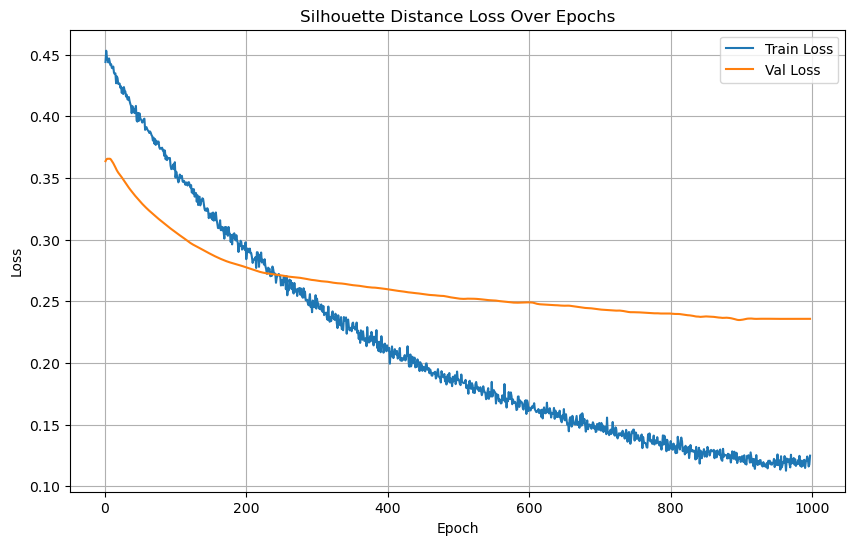

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2312], Loss: 0.0697


Test Batch [20/2312], Loss: 0.1194
Test Batch [30/2312], Loss: 0.5000
Test Batch [40/2312], Loss: 0.0808
Test Batch [50/2312], Loss: 0.5000
Test Batch [60/2312], Loss: 0.5000


Test Batch [70/2312], Loss: 0.5000


Test Batch [80/2312], Loss: 0.1258
Test Batch [90/2312], Loss: 0.5000
Test Batch [100/2312], Loss: 0.0723
Test Batch [110/2312], Loss: 0.5000
Test Batch [120/2312], Loss: 0.1166
Test Batch [130/2312], Loss: 0.5000


Test Batch [140/2312], Loss: 0.5000
Test Batch [150/2312], Loss: 0.5000
Test Batch [160/2312], Loss: 0.0806
Test Batch [170/2312], Loss: 0.5000
Test Batch [180/2312], Loss: 0.5000
Test Batch [190/2312], Loss: 0.5000
Test Batch [200/2312], Loss: 0.1291


Test Batch [210/2312], Loss: 0.5000
Test Batch [220/2312], Loss: 0.5000
Test Batch [230/2312], Loss: 0.0770
Test Batch [240/2312], Loss: 0.5000
Test Batch [250/2312], Loss: 0.1244
Test Batch [260/2312], Loss: 0.5000
Test Batch [270/2312], Loss: 0.5000


Test Batch [280/2312], Loss: 0.5000
Test Batch [290/2312], Loss: 0.0293
Test Batch [300/2312], Loss: 0.1383
Test Batch [310/2312], Loss: 0.5000
Test Batch [320/2312], Loss: 0.1045
Test Batch [330/2312], Loss: 0.5000
Test Batch [340/2312], Loss: 0.5000


Test Batch [350/2312], Loss: 0.0438
Test Batch [360/2312], Loss: 0.1471
Test Batch [370/2312], Loss: 0.0963
Test Batch [380/2312], Loss: 0.1104
Test Batch [390/2312], Loss: 0.0382
Test Batch [400/2312], Loss: 0.5000
Test Batch [410/2312], Loss: 0.0669


Test Batch [420/2312], Loss: 0.0796
Test Batch [430/2312], Loss: 0.1151
Test Batch [440/2312], Loss: 0.5000
Test Batch [450/2312], Loss: 0.0741
Test Batch [460/2312], Loss: 0.5000
Test Batch [470/2312], Loss: 0.0638


Test Batch [480/2312], Loss: 0.0168
Test Batch [490/2312], Loss: 0.0133
Test Batch [500/2312], Loss: 0.0657
Test Batch [510/2312], Loss: 0.0108
Test Batch [520/2312], Loss: 0.1252
Test Batch [530/2312], Loss: 0.5000
Test Batch [540/2312], Loss: 0.5000


Test Batch [550/2312], Loss: 0.1020
Test Batch [560/2312], Loss: 0.5000
Test Batch [570/2312], Loss: 0.5000
Test Batch [580/2312], Loss: 0.0376
Test Batch [590/2312], Loss: 0.0907
Test Batch [600/2312], Loss: 0.5000


Test Batch [610/2312], Loss: 0.5000
Test Batch [620/2312], Loss: 0.0444
Test Batch [630/2312], Loss: 0.0214
Test Batch [640/2312], Loss: 0.1185
Test Batch [650/2312], Loss: 0.5000
Test Batch [660/2312], Loss: 0.0932


Test Batch [670/2312], Loss: 0.0365
Test Batch [680/2312], Loss: 0.5000
Test Batch [690/2312], Loss: 0.1201
Test Batch [700/2312], Loss: 0.0769
Test Batch [710/2312], Loss: 0.0150
Test Batch [720/2312], Loss: 0.5000
Test Batch [730/2312], Loss: 0.0447


Test Batch [740/2312], Loss: 0.5000
Test Batch [750/2312], Loss: 0.0676
Test Batch [760/2312], Loss: 0.0967
Test Batch [770/2312], Loss: 0.5000
Test Batch [780/2312], Loss: 0.5000
Test Batch [790/2312], Loss: 0.0205


Test Batch [800/2312], Loss: 0.1006
Test Batch [810/2312], Loss: 0.5000
Test Batch [820/2312], Loss: 0.1003
Test Batch [830/2312], Loss: 0.5000
Test Batch [840/2312], Loss: 0.0697
Test Batch [850/2312], Loss: 0.2362


Test Batch [860/2312], Loss: 0.0359
Test Batch [870/2312], Loss: 0.1300
Test Batch [880/2312], Loss: 0.0146
Test Batch [890/2312], Loss: 0.5000
Test Batch [900/2312], Loss: 0.5000
Test Batch [910/2312], Loss: 0.5000
Test Batch [920/2312], Loss: 0.0497
Test Batch [930/2312], Loss: 0.1142


Test Batch [940/2312], Loss: 0.0535
Test Batch [950/2312], Loss: 0.5000
Test Batch [960/2312], Loss: 0.5000
Test Batch [970/2312], Loss: 0.5000
Test Batch [980/2312], Loss: 0.0771
Test Batch [990/2312], Loss: 0.0384
Test Batch [1000/2312], Loss: 0.0531


Test Batch [1010/2312], Loss: 0.0251
Test Batch [1020/2312], Loss: 0.1521
Test Batch [1030/2312], Loss: 0.5000
Test Batch [1040/2312], Loss: 0.0544
Test Batch [1050/2312], Loss: 0.0763
Test Batch [1060/2312], Loss: 0.0654


Test Batch [1070/2312], Loss: 0.0856
Test Batch [1080/2312], Loss: 0.0683
Test Batch [1090/2312], Loss: 0.1542
Test Batch [1100/2312], Loss: 0.1234
Test Batch [1110/2312], Loss: 0.1210


Test Batch [1120/2312], Loss: 0.0379
Test Batch [1130/2312], Loss: 0.0458
Test Batch [1140/2312], Loss: 0.5000
Test Batch [1150/2312], Loss: 0.0462
Test Batch [1160/2312], Loss: 0.1179


Test Batch [1170/2312], Loss: 0.1044
Test Batch [1180/2312], Loss: 0.1861
Test Batch [1190/2312], Loss: 0.0191
Test Batch [1200/2312], Loss: 0.1872
Test Batch [1210/2312], Loss: 0.1471


Test Batch [1220/2312], Loss: 0.1817
Test Batch [1230/2312], Loss: 0.1898
Test Batch [1240/2312], Loss: 0.1030
Test Batch [1250/2312], Loss: 0.5000
Test Batch [1260/2312], Loss: 0.0562


Test Batch [1270/2312], Loss: 0.1132
Test Batch [1280/2312], Loss: 0.2601
Test Batch [1290/2312], Loss: 0.5000
Test Batch [1300/2312], Loss: 0.1285


Test Batch [1310/2312], Loss: 0.0765
Test Batch [1320/2312], Loss: 0.1243
Test Batch [1330/2312], Loss: 0.0905


Test Batch [1340/2312], Loss: 0.0278
Test Batch [1350/2312], Loss: 0.1325
Test Batch [1360/2312], Loss: 0.2357
Test Batch [1370/2312], Loss: 0.1592


Test Batch [1380/2312], Loss: 0.1996
Test Batch [1390/2312], Loss: 0.1291
Test Batch [1400/2312], Loss: 0.1230


Test Batch [1410/2312], Loss: 0.1541
Test Batch [1420/2312], Loss: 0.1068
Test Batch [1430/2312], Loss: 0.5000
Test Batch [1440/2312], Loss: 0.1266


Test Batch [1450/2312], Loss: 0.5000
Test Batch [1460/2312], Loss: 0.1426
Test Batch [1470/2312], Loss: 0.0996
Test Batch [1480/2312], Loss: 0.1648


Test Batch [1490/2312], Loss: 0.1361
Test Batch [1500/2312], Loss: 0.5000
Test Batch [1510/2312], Loss: 0.1083
Test Batch [1520/2312], Loss: 0.5000


Test Batch [1530/2312], Loss: 0.1278
Test Batch [1540/2312], Loss: 0.1337
Test Batch [1550/2312], Loss: 0.0961
Test Batch [1560/2312], Loss: 0.1054


Test Batch [1570/2312], Loss: 0.1287
Test Batch [1580/2312], Loss: 0.0768
Test Batch [1590/2312], Loss: 0.0880
Test Batch [1600/2312], Loss: 0.0689


Test Batch [1610/2312], Loss: 0.1143
Test Batch [1620/2312], Loss: 0.2703
Test Batch [1630/2312], Loss: 0.1720
Test Batch [1640/2312], Loss: 0.1371


Test Batch [1650/2312], Loss: 0.0533
Test Batch [1660/2312], Loss: 0.1057
Test Batch [1670/2312], Loss: 0.1549
Test Batch [1680/2312], Loss: 0.1314


Test Batch [1690/2312], Loss: 0.1910
Test Batch [1700/2312], Loss: 0.1217
Test Batch [1710/2312], Loss: 0.0943
Test Batch [1720/2312], Loss: 0.0461
Test Batch [1730/2312], Loss: 0.1230


Test Batch [1740/2312], Loss: 0.5000
Test Batch [1750/2312], Loss: 0.0706
Test Batch [1760/2312], Loss: 0.0900
Test Batch [1770/2312], Loss: 0.0536
Test Batch [1780/2312], Loss: 0.0818
Test Batch [1790/2312], Loss: 0.1036
Test Batch [1800/2312], Loss: 0.0752


Test Batch [1810/2312], Loss: 0.0799
Test Batch [1820/2312], Loss: 0.1518
Test Batch [1830/2312], Loss: 0.0325
Test Batch [1840/2312], Loss: 0.1185
Test Batch [1850/2312], Loss: 0.1011
Test Batch [1860/2312], Loss: 0.0820


Test Batch [1870/2312], Loss: 0.0951
Test Batch [1880/2312], Loss: 0.1254
Test Batch [1890/2312], Loss: 0.0892
Test Batch [1900/2312], Loss: 0.1314
Test Batch [1910/2312], Loss: 0.1445


Test Batch [1920/2312], Loss: 0.2019
Test Batch [1930/2312], Loss: 0.1334
Test Batch [1940/2312], Loss: 0.0907
Test Batch [1950/2312], Loss: 0.0950
Test Batch [1960/2312], Loss: 0.0989
Test Batch [1970/2312], Loss: 0.1010


Test Batch [1980/2312], Loss: 0.0718
Test Batch [1990/2312], Loss: 0.0671
Test Batch [2000/2312], Loss: 0.0780
Test Batch [2010/2312], Loss: 0.0590
Test Batch [2020/2312], Loss: 0.0963
Test Batch [2030/2312], Loss: 0.0730


Test Batch [2040/2312], Loss: 0.1241
Test Batch [2050/2312], Loss: 0.1445
Test Batch [2060/2312], Loss: 0.1510
Test Batch [2070/2312], Loss: 0.0903
Test Batch [2080/2312], Loss: 0.5000
Test Batch [2090/2312], Loss: 0.0941


Test Batch [2100/2312], Loss: 0.1850
Test Batch [2110/2312], Loss: 0.1149
Test Batch [2120/2312], Loss: 0.1522
Test Batch [2130/2312], Loss: 0.0463
Test Batch [2140/2312], Loss: 0.1014
Test Batch [2150/2312], Loss: 0.2266
Test Batch [2160/2312], Loss: 0.0177


Test Batch [2170/2312], Loss: 0.5000
Test Batch [2180/2312], Loss: 0.5000
Test Batch [2190/2312], Loss: 0.5000
Test Batch [2200/2312], Loss: 0.5000
Test Batch [2210/2312], Loss: 0.5000
Test Batch [2220/2312], Loss: 0.1084


Test Batch [2230/2312], Loss: 0.0371
Test Batch [2240/2312], Loss: 0.1242
Test Batch [2250/2312], Loss: 0.0368
Test Batch [2260/2312], Loss: 0.5000
Test Batch [2270/2312], Loss: 0.1128
Test Batch [2280/2312], Loss: 0.5000
Test Batch [2290/2312], Loss: 0.0307


Test Batch [2300/2312], Loss: 0.5000
Test Batch [2310/2312], Loss: 0.5000

Test Loss: 0.2176


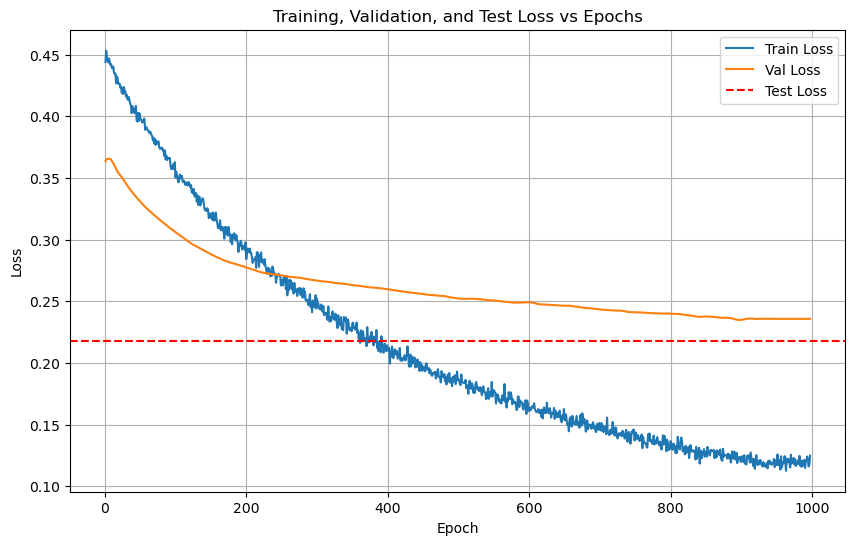

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/2312 for test dataset.
  Processed batch 20/2312 for test dataset.
  Processed batch 30/2312 for test dataset.


  Processed batch 40/2312 for test dataset.


  Processed batch 50/2312 for test dataset.
  Processed batch 60/2312 for test dataset.
  Processed batch 70/2312 for test dataset.


  Processed batch 80/2312 for test dataset.
  Processed batch 90/2312 for test dataset.
  Processed batch 100/2312 for test dataset.
  Processed batch 110/2312 for test dataset.


  Processed batch 120/2312 for test dataset.
  Processed batch 130/2312 for test dataset.
  Processed batch 140/2312 for test dataset.


  Processed batch 150/2312 for test dataset.
  Processed batch 160/2312 for test dataset.
  Processed batch 170/2312 for test dataset.
  Processed batch 180/2312 for test dataset.


  Processed batch 190/2312 for test dataset.
  Processed batch 200/2312 for test dataset.
  Processed batch 210/2312 for test dataset.
  Processed batch 220/2312 for test dataset.


  Processed batch 230/2312 for test dataset.
  Processed batch 240/2312 for test dataset.
  Processed batch 250/2312 for test dataset.
  Processed batch 260/2312 for test dataset.


  Processed batch 270/2312 for test dataset.
  Processed batch 280/2312 for test dataset.
  Processed batch 290/2312 for test dataset.
  Processed batch 300/2312 for test dataset.


  Processed batch 310/2312 for test dataset.
  Processed batch 320/2312 for test dataset.
  Processed batch 330/2312 for test dataset.
  Processed batch 340/2312 for test dataset.


  Processed batch 350/2312 for test dataset.
  Processed batch 360/2312 for test dataset.
  Processed batch 370/2312 for test dataset.
  Processed batch 380/2312 for test dataset.


  Processed batch 390/2312 for test dataset.
  Processed batch 400/2312 for test dataset.
  Processed batch 410/2312 for test dataset.


  Processed batch 420/2312 for test dataset.
  Processed batch 430/2312 for test dataset.
  Processed batch 440/2312 for test dataset.
  Processed batch 450/2312 for test dataset.


  Processed batch 460/2312 for test dataset.
  Processed batch 470/2312 for test dataset.
  Processed batch 480/2312 for test dataset.
  Processed batch 490/2312 for test dataset.


  Processed batch 500/2312 for test dataset.
  Processed batch 510/2312 for test dataset.
  Processed batch 520/2312 for test dataset.
  Processed batch 530/2312 for test dataset.


  Processed batch 540/2312 for test dataset.
  Processed batch 550/2312 for test dataset.
  Processed batch 560/2312 for test dataset.
  Processed batch 570/2312 for test dataset.


  Processed batch 580/2312 for test dataset.
  Processed batch 590/2312 for test dataset.
  Processed batch 600/2312 for test dataset.
  Processed batch 610/2312 for test dataset.


  Processed batch 620/2312 for test dataset.
  Processed batch 630/2312 for test dataset.
  Processed batch 640/2312 for test dataset.
  Processed batch 650/2312 for test dataset.


  Processed batch 660/2312 for test dataset.
  Processed batch 670/2312 for test dataset.
  Processed batch 680/2312 for test dataset.
  Processed batch 690/2312 for test dataset.


  Processed batch 700/2312 for test dataset.
  Processed batch 710/2312 for test dataset.
  Processed batch 720/2312 for test dataset.


  Processed batch 730/2312 for test dataset.
  Processed batch 740/2312 for test dataset.
  Processed batch 750/2312 for test dataset.


  Processed batch 760/2312 for test dataset.
  Processed batch 770/2312 for test dataset.
  Processed batch 780/2312 for test dataset.
  Processed batch 790/2312 for test dataset.


  Processed batch 800/2312 for test dataset.
  Processed batch 810/2312 for test dataset.
  Processed batch 820/2312 for test dataset.
  Processed batch 830/2312 for test dataset.


  Processed batch 840/2312 for test dataset.
  Processed batch 850/2312 for test dataset.
  Processed batch 860/2312 for test dataset.
  Processed batch 870/2312 for test dataset.


  Processed batch 880/2312 for test dataset.
  Processed batch 890/2312 for test dataset.
  Processed batch 900/2312 for test dataset.
  Processed batch 910/2312 for test dataset.


  Processed batch 920/2312 for test dataset.
  Processed batch 930/2312 for test dataset.
  Processed batch 940/2312 for test dataset.


  Processed batch 950/2312 for test dataset.
  Processed batch 960/2312 for test dataset.
  Processed batch 970/2312 for test dataset.
  Processed batch 980/2312 for test dataset.


  Processed batch 990/2312 for test dataset.
  Processed batch 1000/2312 for test dataset.
  Processed batch 1010/2312 for test dataset.
  Processed batch 1020/2312 for test dataset.


  Processed batch 1030/2312 for test dataset.
  Processed batch 1040/2312 for test dataset.
  Processed batch 1050/2312 for test dataset.


  Processed batch 1060/2312 for test dataset.
  Processed batch 1070/2312 for test dataset.
  Processed batch 1080/2312 for test dataset.
  Processed batch 1090/2312 for test dataset.


  Processed batch 1100/2312 for test dataset.
  Processed batch 1110/2312 for test dataset.
  Processed batch 1120/2312 for test dataset.
  Processed batch 1130/2312 for test dataset.


  Processed batch 1140/2312 for test dataset.
  Processed batch 1150/2312 for test dataset.
  Processed batch 1160/2312 for test dataset.


  Processed batch 1170/2312 for test dataset.
  Processed batch 1180/2312 for test dataset.
  Processed batch 1190/2312 for test dataset.
  Processed batch 1200/2312 for test dataset.


  Processed batch 1210/2312 for test dataset.
  Processed batch 1220/2312 for test dataset.
  Processed batch 1230/2312 for test dataset.
  Processed batch 1240/2312 for test dataset.


  Processed batch 1250/2312 for test dataset.
  Processed batch 1260/2312 for test dataset.
  Processed batch 1270/2312 for test dataset.


  Processed batch 1280/2312 for test dataset.
  Processed batch 1290/2312 for test dataset.
  Processed batch 1300/2312 for test dataset.


  Processed batch 1310/2312 for test dataset.
  Processed batch 1320/2312 for test dataset.
  Processed batch 1330/2312 for test dataset.
  Processed batch 1340/2312 for test dataset.


  Processed batch 1350/2312 for test dataset.
  Processed batch 1360/2312 for test dataset.
  Processed batch 1370/2312 for test dataset.
  Processed batch 1380/2312 for test dataset.


  Processed batch 1390/2312 for test dataset.
  Processed batch 1400/2312 for test dataset.
  Processed batch 1410/2312 for test dataset.
  Processed batch 1420/2312 for test dataset.


  Processed batch 1430/2312 for test dataset.
  Processed batch 1440/2312 for test dataset.
  Processed batch 1450/2312 for test dataset.
  Processed batch 1460/2312 for test dataset.


  Processed batch 1470/2312 for test dataset.
  Processed batch 1480/2312 for test dataset.
  Processed batch 1490/2312 for test dataset.


  Processed batch 1500/2312 for test dataset.
  Processed batch 1510/2312 for test dataset.
  Processed batch 1520/2312 for test dataset.
  Processed batch 1530/2312 for test dataset.


  Processed batch 1540/2312 for test dataset.
  Processed batch 1550/2312 for test dataset.
  Processed batch 1560/2312 for test dataset.
  Processed batch 1570/2312 for test dataset.


  Processed batch 1580/2312 for test dataset.
  Processed batch 1590/2312 for test dataset.
  Processed batch 1600/2312 for test dataset.


  Processed batch 1610/2312 for test dataset.
  Processed batch 1620/2312 for test dataset.
  Processed batch 1630/2312 for test dataset.
  Processed batch 1640/2312 for test dataset.


  Processed batch 1650/2312 for test dataset.
  Processed batch 1660/2312 for test dataset.
  Processed batch 1670/2312 for test dataset.


  Processed batch 1680/2312 for test dataset.
  Processed batch 1690/2312 for test dataset.
  Processed batch 1700/2312 for test dataset.
  Processed batch 1710/2312 for test dataset.


  Processed batch 1720/2312 for test dataset.
  Processed batch 1730/2312 for test dataset.
  Processed batch 1740/2312 for test dataset.
  Processed batch 1750/2312 for test dataset.


  Processed batch 1760/2312 for test dataset.
  Processed batch 1770/2312 for test dataset.
  Processed batch 1780/2312 for test dataset.


  Processed batch 1790/2312 for test dataset.
  Processed batch 1800/2312 for test dataset.
  Processed batch 1810/2312 for test dataset.


  Processed batch 1820/2312 for test dataset.
  Processed batch 1830/2312 for test dataset.
  Processed batch 1840/2312 for test dataset.
  Processed batch 1850/2312 for test dataset.


  Processed batch 1860/2312 for test dataset.
  Processed batch 1870/2312 for test dataset.
  Processed batch 1880/2312 for test dataset.


  Processed batch 1890/2312 for test dataset.
  Processed batch 1900/2312 for test dataset.
  Processed batch 1910/2312 for test dataset.
  Processed batch 1920/2312 for test dataset.


  Processed batch 1930/2312 for test dataset.
  Processed batch 1940/2312 for test dataset.
  Processed batch 1950/2312 for test dataset.
  Processed batch 1960/2312 for test dataset.


  Processed batch 1970/2312 for test dataset.
  Processed batch 1980/2312 for test dataset.
  Processed batch 1990/2312 for test dataset.


  Processed batch 2000/2312 for test dataset.
  Processed batch 2010/2312 for test dataset.
  Processed batch 2020/2312 for test dataset.
  Processed batch 2030/2312 for test dataset.


  Processed batch 2040/2312 for test dataset.
  Processed batch 2050/2312 for test dataset.
  Processed batch 2060/2312 for test dataset.
  Processed batch 2070/2312 for test dataset.


  Processed batch 2080/2312 for test dataset.
  Processed batch 2090/2312 for test dataset.
  Processed batch 2100/2312 for test dataset.
  Processed batch 2110/2312 for test dataset.


  Processed batch 2120/2312 for test dataset.
  Processed batch 2130/2312 for test dataset.
  Processed batch 2140/2312 for test dataset.
  Processed batch 2150/2312 for test dataset.


  Processed batch 2160/2312 for test dataset.
  Processed batch 2170/2312 for test dataset.
  Processed batch 2180/2312 for test dataset.
  Processed batch 2190/2312 for test dataset.


  Processed batch 2200/2312 for test dataset.
  Processed batch 2210/2312 for test dataset.
  Processed batch 2220/2312 for test dataset.
  Processed batch 2230/2312 for test dataset.


  Processed batch 2240/2312 for test dataset.
  Processed batch 2250/2312 for test dataset.
  Processed batch 2260/2312 for test dataset.


  Processed batch 2270/2312 for test dataset.
  Processed batch 2280/2312 for test dataset.
  Processed batch 2290/2312 for test dataset.
  Processed batch 2300/2312 for test dataset.


  Processed batch 2310/2312 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.60      0.75         5
           2       0.71      1.00      0.83         5
           3       0.75      0.60      0.67         5
           4       0.80      0.80      0.80         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.88        45
weighted avg       0.90      0.89      0.88        45


LOG: Evaluating on the test set...
Test Accuracy: 95.82%

Test Classifica

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3255  |  Val Loss: 2.2769
Validation loss improved from inf to 2.2769.
[Epoch 2/1000] Train Loss: 2.2534  |  Val Loss: 2.2150
Validation loss improved from 2.2769 to 2.2150.
[Epoch 3/1000] Train Loss: 2.1837  |  Val Loss: 2.1552
Validation loss improved from 2.2150 to 2.1552.
[Epoch 4/1000] Train Loss: 2.1192  |  Val Loss: 2.0990
Validation loss improved from 2.1552 to 2.0990.
[Epoch 5/1000] Train Loss: 2.0517  |  Val Loss: 2.0445
Validation loss improved from 2.0990 to 2.0445.
[Epoch 6/1000] Train Loss: 1.9910  |  Val Loss: 1.9925
Validation loss improved from 2.0445 to 1.9925.
[Epoch 7/1000] Train Loss: 1.9317  |  Val Loss: 1.9433
Validation loss improved from 1.9925 to 1.9433.
[Epoch 8/1000] Train Loss: 1.8743  |  Val Loss: 1.8955
Validation loss improved from 1.9433 to 1.8955.
[Epoch 9/1000] Train Loss: 1.8200  |  Val Loss: 1.8503
Validation loss improved from 1.8955 to 1.8503.
[Epoch 10/1000] Train Loss: 1.7678  |  Val Loss: 1.8079
Validation loss impr

[Epoch 24/1000] Train Loss: 1.2565  |  Val Loss: 1.3776
Validation loss improved from 1.4023 to 1.3776.
[Epoch 25/1000] Train Loss: 1.2279  |  Val Loss: 1.3536
Validation loss improved from 1.3776 to 1.3536.
[Epoch 26/1000] Train Loss: 1.1996  |  Val Loss: 1.3304
Validation loss improved from 1.3536 to 1.3304.
[Epoch 27/1000] Train Loss: 1.1733  |  Val Loss: 1.3079
Validation loss improved from 1.3304 to 1.3079.
[Epoch 28/1000] Train Loss: 1.1472  |  Val Loss: 1.2863
Validation loss improved from 1.3079 to 1.2863.
[Epoch 29/1000] Train Loss: 1.1223  |  Val Loss: 1.2657
Validation loss improved from 1.2863 to 1.2657.
[Epoch 30/1000] Train Loss: 1.0981  |  Val Loss: 1.2457
Validation loss improved from 1.2657 to 1.2457.
[Epoch 31/1000] Train Loss: 1.0748  |  Val Loss: 1.2265
Validation loss improved from 1.2457 to 1.2265.
[Epoch 32/1000] Train Loss: 1.0525  |  Val Loss: 1.2079
Validation loss improved from 1.2265 to 1.2079.
[Epoch 33/1000] Train Loss: 1.0307  |  Val Loss: 1.1899
Validati

[Epoch 53/1000] Train Loss: 0.7005  |  Val Loss: 0.9236
Validation loss improved from 0.9338 to 0.9236.
[Epoch 54/1000] Train Loss: 0.6869  |  Val Loss: 0.9138
Validation loss improved from 0.9236 to 0.9138.
[Epoch 55/1000] Train Loss: 0.6737  |  Val Loss: 0.9042
Validation loss improved from 0.9138 to 0.9042.
[Epoch 56/1000] Train Loss: 0.6606  |  Val Loss: 0.8948
Validation loss improved from 0.9042 to 0.8948.
[Epoch 57/1000] Train Loss: 0.6478  |  Val Loss: 0.8857
Validation loss improved from 0.8948 to 0.8857.
[Epoch 58/1000] Train Loss: 0.6353  |  Val Loss: 0.8766
Validation loss improved from 0.8857 to 0.8766.
[Epoch 59/1000] Train Loss: 0.6225  |  Val Loss: 0.8678
Validation loss improved from 0.8766 to 0.8678.
[Epoch 60/1000] Train Loss: 0.6099  |  Val Loss: 0.8591
Validation loss improved from 0.8678 to 0.8591.
[Epoch 61/1000] Train Loss: 0.5979  |  Val Loss: 0.8504
Validation loss improved from 0.8591 to 0.8504.
[Epoch 62/1000] Train Loss: 0.5854  |  Val Loss: 0.8419
Validati

[Epoch 85/1000] Train Loss: 0.3399  |  Val Loss: 0.6928
Validation loss improved from 0.6972 to 0.6928.
[Epoch 86/1000] Train Loss: 0.3314  |  Val Loss: 0.6886
Validation loss improved from 0.6928 to 0.6886.
[Epoch 87/1000] Train Loss: 0.3230  |  Val Loss: 0.6846
Validation loss improved from 0.6886 to 0.6846.
[Epoch 88/1000] Train Loss: 0.3150  |  Val Loss: 0.6808
Validation loss improved from 0.6846 to 0.6808.
[Epoch 89/1000] Train Loss: 0.3069  |  Val Loss: 0.6770
Validation loss improved from 0.6808 to 0.6770.
[Epoch 90/1000] Train Loss: 0.2986  |  Val Loss: 0.6734
Validation loss improved from 0.6770 to 0.6734.
[Epoch 91/1000] Train Loss: 0.2910  |  Val Loss: 0.6699
Validation loss improved from 0.6734 to 0.6699.
[Epoch 92/1000] Train Loss: 0.2832  |  Val Loss: 0.6666
Validation loss improved from 0.6699 to 0.6666.
[Epoch 93/1000] Train Loss: 0.2758  |  Val Loss: 0.6635
Validation loss improved from 0.6666 to 0.6635.
[Epoch 94/1000] Train Loss: 0.2684  |  Val Loss: 0.6607
Validati

[Epoch 116/1000] Train Loss: 0.1546  |  Val Loss: 0.6358
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 117/1000] Train Loss: 0.1513  |  Val Loss: 0.6359
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 118/1000] Train Loss: 0.1480  |  Val Loss: 0.6362
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 119/1000] Train Loss: 0.1448  |  Val Loss: 0.6367
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 120/1000] Train Loss: 0.1417  |  Val Loss: 0.6370
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 121/1000] Train Loss: 0.1386  |  Val Loss: 0.6377
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 122/1000] Train Loss: 0.1357  |  Val Loss: 0.6383
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 123/1000] Train Loss: 0.1329  |  Val Loss: 0.6390
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 124/1000] Train Loss: 0.1301  |  Val Loss: 0.6397
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 145/1000] Train Loss: 0.0881  |  Val Loss: 0.6658
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 146/1000] Train Loss: 0.0866  |  Val Loss: 0.6673
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 147/1000] Train Loss: 0.0852  |  Val Loss: 0.6686
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 148/1000] Train Loss: 0.0839  |  Val Loss: 0.6699
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 149/1000] Train Loss: 0.0826  |  Val Loss: 0.6714
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 150/1000] Train Loss: 0.0813  |  Val Loss: 0.6726
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 151/1000] Train Loss: 0.0800  |  Val Loss: 0.6740
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 152/1000] Train Loss: 0.0788  |  Val Loss: 0.6753
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 153/1000] Train Loss: 0.0776  |  Val Loss: 0.6769
!! Validation loss did NOT improve !! Patience:

[Epoch 174/1000] Train Loss: 0.0587  |  Val Loss: 0.7114
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 175/1000] Train Loss: 0.0581  |  Val Loss: 0.7128
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 176/1000] Train Loss: 0.0574  |  Val Loss: 0.7148
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 177/1000] Train Loss: 0.0568  |  Val Loss: 0.7164
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 178/1000] Train Loss: 0.0561  |  Val Loss: 0.7182
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 179/1000] Train Loss: 0.0555  |  Val Loss: 0.7201
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 180/1000] Train Loss: 0.0549  |  Val Loss: 0.7217
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 181/1000] Train Loss: 0.0543  |  Val Loss: 0.7237
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 182/1000] Train Loss: 0.0537  |  Val Loss: 0.7251
!! Validation loss did NOT improve !! Patience:

[Epoch 205/1000] Train Loss: 0.0429  |  Val Loss: 0.7599
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 206/1000] Train Loss: 0.0425  |  Val Loss: 0.7615
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 207/1000] Train Loss: 0.0422  |  Val Loss: 0.7630
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 208/1000] Train Loss: 0.0418  |  Val Loss: 0.7643
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 209/1000] Train Loss: 0.0415  |  Val Loss: 0.7659
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 210/1000] Train Loss: 0.0411  |  Val Loss: 0.7673
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 211/1000] Train Loss: 0.0408  |  Val Loss: 0.7684
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 212/1000] Train Loss: 0.0404  |  Val Loss: 0.7702
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 213/1000] Train Loss: 0.0401  |  Val Loss: 0.7717
!! Validation loss did NOT improve !! Patience:

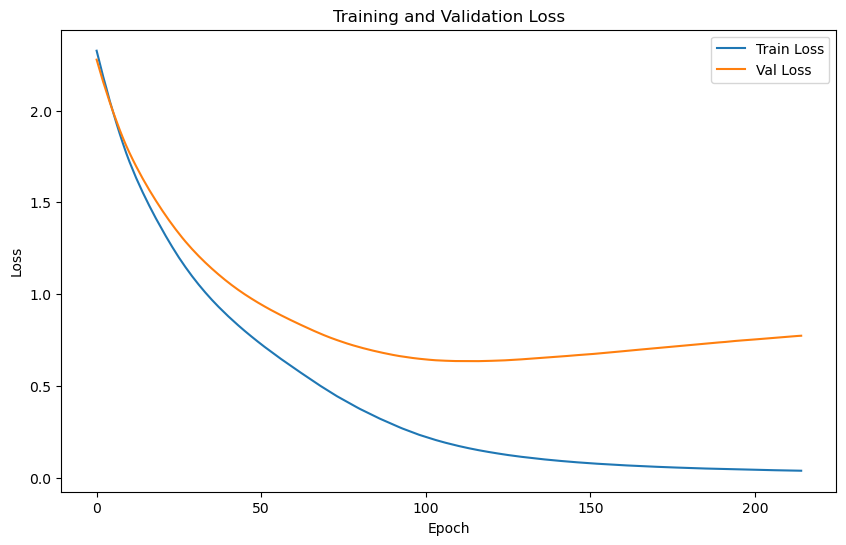

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.1854 | Test Accuracy: 96.17%


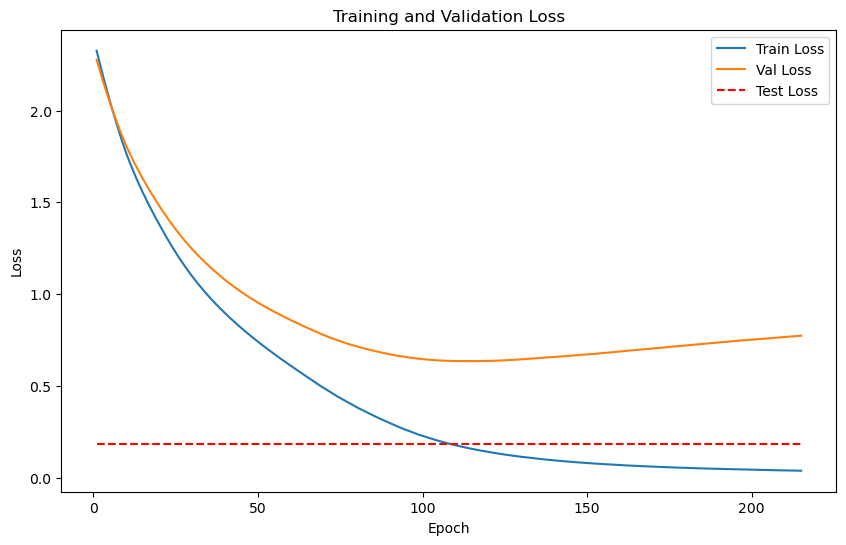

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


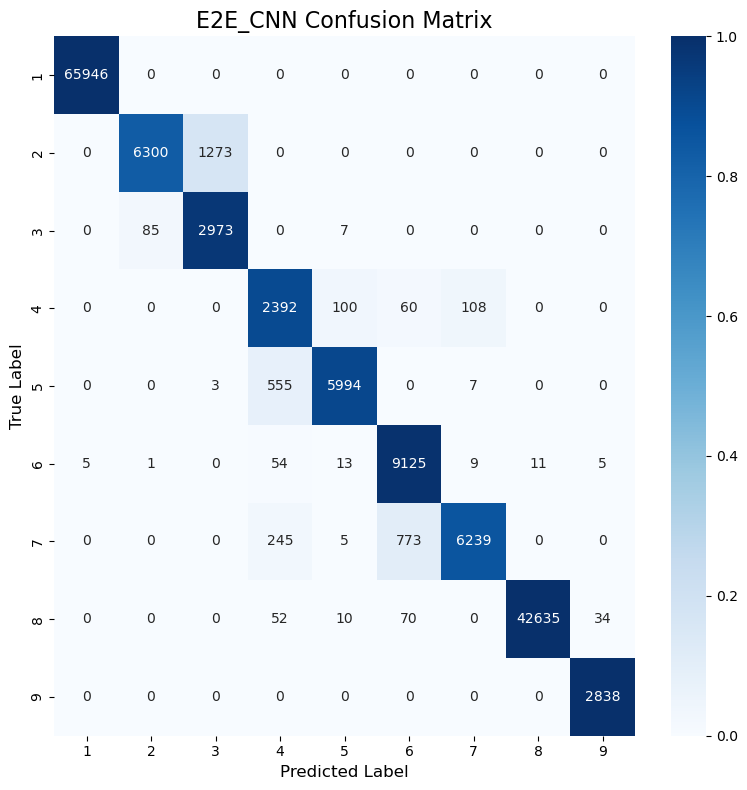

Classification Accuracy: 97.64%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


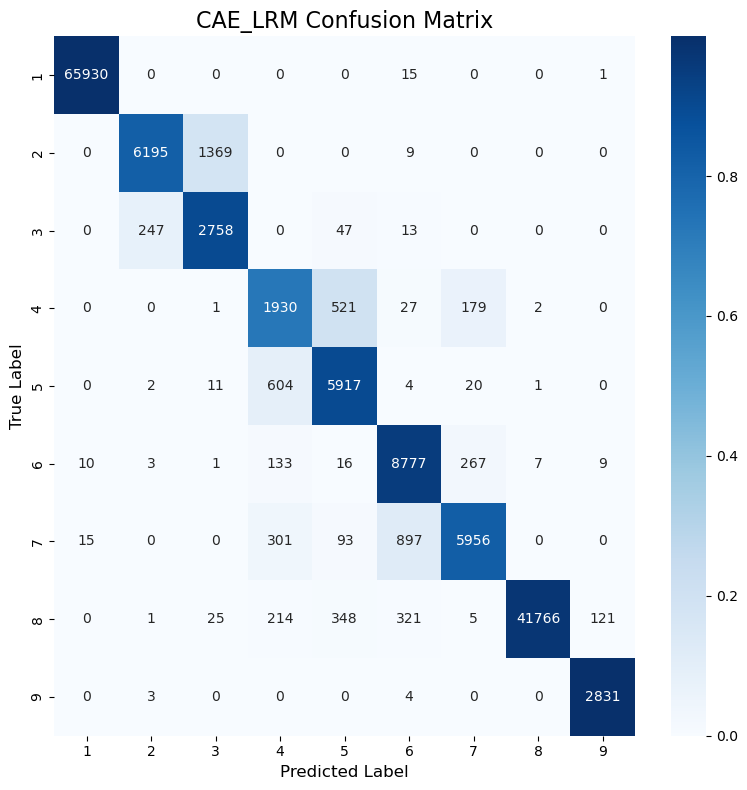

Classification Accuracy: 96.03%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


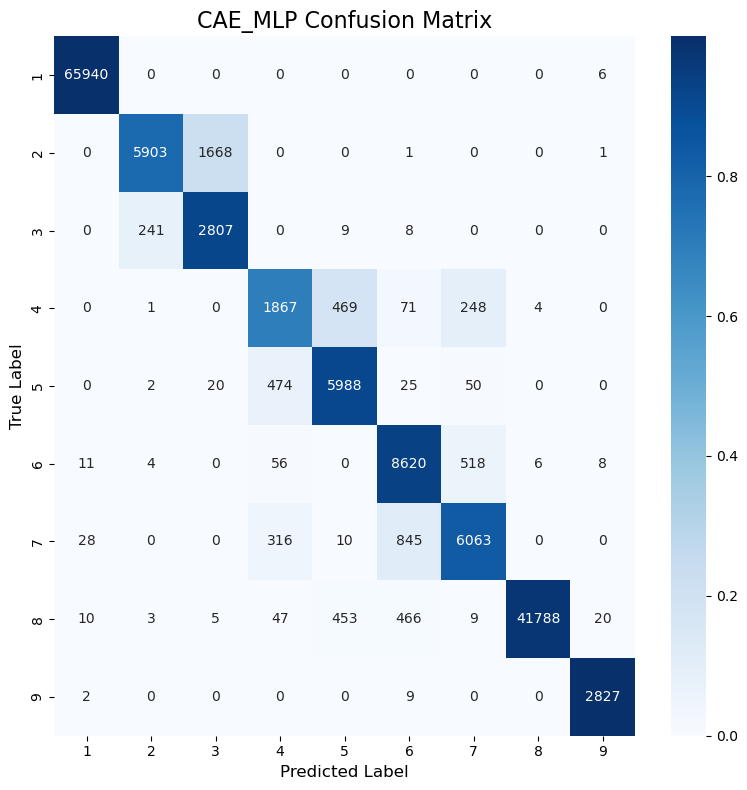

Classification Accuracy: 95.86%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


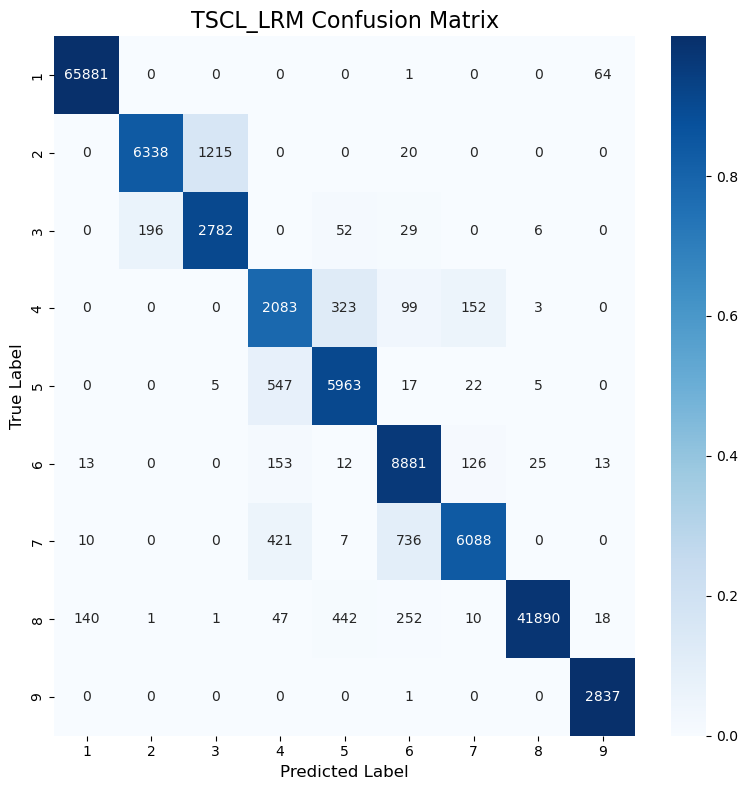

Classification Accuracy: 96.50%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


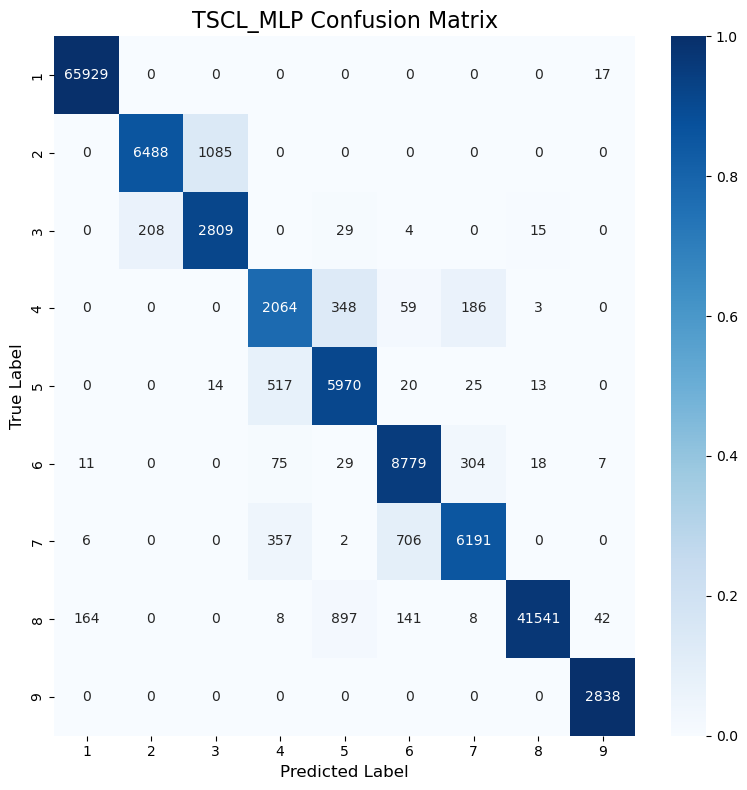

Classification Accuracy: 96.40%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


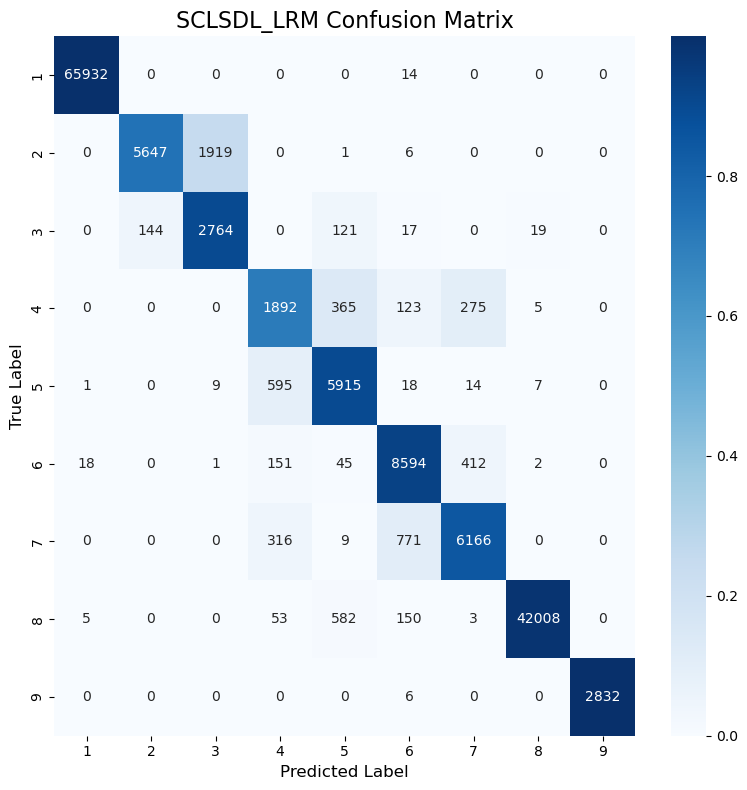

Classification Accuracy: 95.82%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


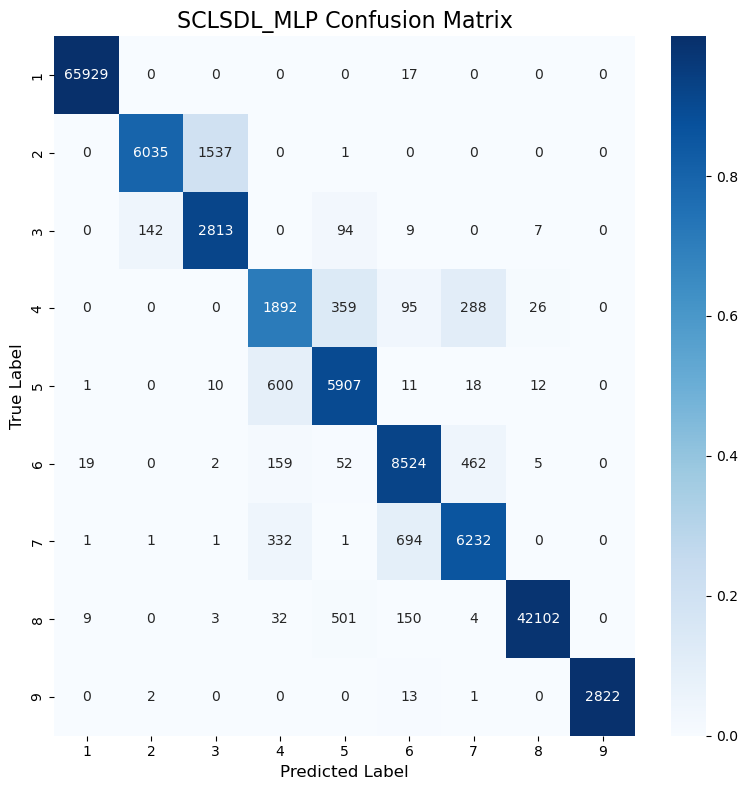

Classification Accuracy: 96.17%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.64
1    LRM (CAE)          96.03
2    MLP (CAE)          95.86
3     TSCL LRM          96.50
4     TSCL MLP          96.40
5  SCL_SDL LRM          95.82
6  SCL_SDL MLP          96.17

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.64
3     TSCL LRM          96.50
4     TSCL MLP          96.40
6  SCL_SDL MLP          96.17
1    LRM (CAE)          96.03
2    MLP (CAE)          95.86
5  SCL_SDL LRM          95.82
